In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import sys
import dask as dd
from dask import dataframe
sys.path.insert(0, "C:/workspace/stress_test_sim//libs")

from monte_carlo import CauchyGenerator, PoissonGenerator, NormalGenerator, ParetoGenerator, LognormalGenerator, Transaction, MonteCarloTransactionSimulator, CauchyParameterSearcher, LognormalParameterSearcher
from uniswap_v2_extractor import get_pool_v2_reserves_history, get_pool_v2_history, list_to_transaction_dictionary, list_to_reserves_dictionary, pool_reserves_to_df, pool_history_to_df, get_pool_v2_mints, get_pool_v2_burns, list_to_mints_dictionary, pool_mints_to_df, pool_burns_to_df
from dima_trubca_v2_plots import show_swaps_count_moving_averages, show_swaps_reserves_evolution_through_time, show_pool_price_evolution_from_reserves, show_swaps_amount_in_moving_averages

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [2]:
def calc_price_and_increase_rates(df: pd.DataFrame):
    """Append prices conform reserves changes and find price increase rates

    Args:
        df (pd.DataFrame): reserves dataframe
    """
    #   setting current price for each reserves update
    first_price_sequence = df.reserve0 / df.reserve1
    second_price_sequence = df.reserve1 / df.reserve0
    df['first_price'] = first_price_sequence
    df['second_price'] = second_price_sequence

    first_price_sequence = first_price_sequence.shift(periods=-1)
    second_price_sequence = second_price_sequence.shift(periods=-1)

    df['first_price_increase_rate'] = ((df.first_price - first_price_sequence) / first_price_sequence) * 100
    df['second_price_increase_rate'] = ((df.second_price - second_price_sequence) / second_price_sequence) * 100

In [3]:
def increase_rate_moving_averages(df: pd.DataFrame, first_plot_name: str, second_plot_name: str, x_size: int=10, y_size: int=5, wspace: int=0.1, hspace: int=0.1):
    """plot information about increasing rates

    Args:
        df (pd.DataFrame): reserves dataframe
        first_plot_name (str): name of first plot
        second_plot_name (str): name of second plot
        x_size (int, optional): x-size of window. Defaults to 10.
        y_size (int, optional): y-size of window. Defaults to 5.
        wspace (int, optional): space between plots. Defaults to 0.1.
        hspace (int, optional): height space between plots. Defaults to 0.1.
    """
    # copy dataframe and get date as index
    transactions_time = df.copy()
    transactions_time.index = transactions_time.date
    
    # resample data and find rolling average per week
    transactions_time = transactions_time.resample('7D').mean()
    transactions_avg_time = transactions_time.rolling('14D').mean()
    
    fig = plt.subplots(figsize=(x_size, y_size))
    
    plt.subplot(1, 2, 1)
    sns.lineplot(data=transactions_time, x='date', y='first_price_increase_rate', color='green', label='7 days mean')
    plt.subplot(1, 2, 1)
    sns.lineplot(data=transactions_avg_time, x='date', y='first_price_increase_rate', color='red', label='14 days rolling mean').set_title(first_plot_name)
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=transactions_time, x='date', y='second_price_increase_rate', color='green', label='7 days mean')
    plt.subplot(1, 2, 2)
    sns.lineplot(data=transactions_avg_time, x='date', y='second_price_increase_rate', color='red', label='14 days rolling mean').set_title(second_plot_name)
    
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()

In [4]:
def swaps_price_increase_rates_moving_averages(df: pd.DataFrame, first_token: str, second_token: str, first_plot_name: str, second_plot_name: str, 
                                               x_size: int=10, y_size: int=5, wspace: int=0.1, hspace: int=0.1):
    first_transactions_time = df[df.token_in == first_token]
    second_transactions_time = df[df.token_in == second_token]
    first_transactions_time.index = first_transactions_time.timestamp
    second_transactions_time.index = second_transactions_time.timestamp
    
    first_transactions_time = first_transactions_time.resample('7D').mean()
    first_transactions_avg_time = first_transactions_time.rolling('14D').mean()
    second_transactions_time = second_transactions_time.resample('7D').mean()
    second_transactions_avg_time = second_transactions_time.rolling('14D').mean()
    
    fig = plt.subplots(figsize=(x_size, y_size))
    
    plt.subplot(1, 2, 1)
    sns.lineplot(data=first_transactions_time, x='timestamp', y='price_change_rate', color='green', label='7 days mean')
    plt.subplot(1, 2, 1)
    sns.lineplot(data=first_transactions_avg_time, x='timestamp', y='price_change_rate', 
                 color='red', label='14 days rolling mean').set_title(first_plot_name)
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=second_transactions_time, x='timestamp', y='price_change_rate', color='green', label='7 days mean')
    plt.subplot(1, 2, 2)
    sns.lineplot(data=second_transactions_avg_time, x='timestamp', y='price_change_rate', 
                 color='red', label='14 days rolling mean').set_title(second_plot_name)
    
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()

# Reading data from pickle files

## WBTC/USDC

In [6]:
wbtc_usdc_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\wbtc_usdc_swaps.pkl')
wbtc_usdc_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\wbtc_usdc_mints.pkl")
wbtc_usdc_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\wbtc_usdc_burns.pkl")
wbtc_usdc_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\wbtc_usdc_reserves.pkl")

### Plot swapping in moving averages

In [7]:
wbtc_usdc_df

token_in token_out     amount_in  amount_out   amount_usd  \
0         USDC      WBTC  1.534170e-01    0.000016     0.152773   
1         WBTC      USDC  2.501000e-04    2.367365     2.331250   
2         WBTC      USDC  1.047330e-03    9.603013     9.597534   
3         USDC      WBTC  8.923190e-01    0.000098     0.889846   
4         WBTC      USDC  1.100000e-07    0.001000     0.000989   
...        ...       ...           ...         ...          ...   
67641     USDC      WBTC  4.033455e+03    0.059772  4032.191782   
67642     USDC      WBTC  4.062171e+03    0.059772  4062.419264   
67643     WBTC      USDC  4.481900e-04   30.384136    30.383452   
67644     USDC      WBTC  1.500000e+03    0.021965  1500.204784   
67645     USDC      WBTC  2.645937e+03    0.038606  2648.510924   

                timestamp  
0     2020-05-19 23:44:23  
1     2020-05-21 14:39:56  
2     2020-05-22 20:47:02  
3     2020-05-23 14:00:42  
4     2020-05-24 17:37:32  
...                   ...  
67641 2021-11-10 13:55:45  
67642 2021-11-10 13:57:02  
67643 2021-11-10 14:10:02  
67644 2021-11-10 14:25:11  
67645 2021-11-10 16:05:00  

[67646 rows x 6 columns]

In [7]:
wbtc_usdc_df['first_to_second_price'] = wbtc_usdc_df.amount_out / wbtc_usdc_df.amount_in
wbtc_usdc_df['price_change_rate'] = np.ones(len(wbtc_usdc_df))

wbtc_price_story = wbtc_usdc_df[wbtc_usdc_df.token_in == 'WBTC'].first_to_second_price
usdc_price_story = wbtc_usdc_df[wbtc_usdc_df.token_in == 'USDC'].first_to_second_price
wbtc_price_story = wbtc_price_story.shift(periods=-1)
usdc_price_story = usdc_price_story.shift(periods=-1)

wbtc_wbtc_usdc_df = wbtc_usdc_df[wbtc_usdc_df.token_in == 'WBTC']
usdc_wbtc_usdc_df = wbtc_usdc_df[wbtc_usdc_df.token_in == 'USDC']

wbtc_wbtc_usdc_df.price_change_rate = ((wbtc_wbtc_usdc_df.first_to_second_price - wbtc_price_story) / wbtc_price_story) * 100
usdc_wbtc_usdc_df.price_change_rate = ((usdc_wbtc_usdc_df.first_to_second_price - usdc_price_story) / usdc_price_story) * 100

wbtc_usdc_df = pd.concat([wbtc_wbtc_usdc_df, usdc_wbtc_usdc_df])
wbtc_usdc_df.sort_index(inplace=True)

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


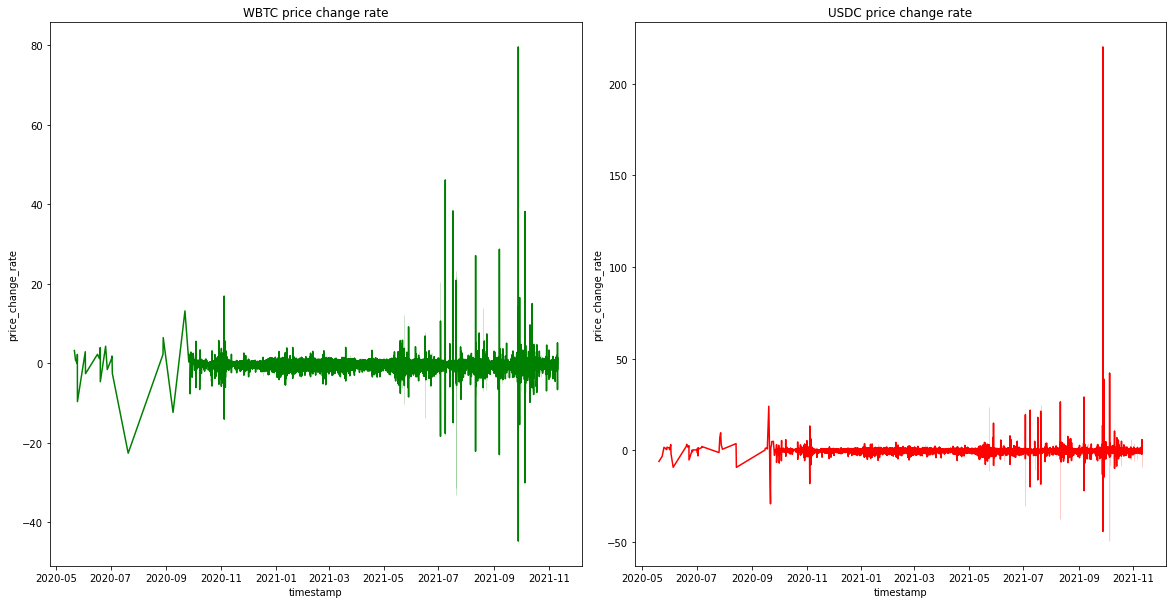

In [8]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=wbtc_usdc_df[wbtc_usdc_df.token_in == 'WBTC'], x='timestamp', y='price_change_rate', color='green').set_title('WBTC price change rate')
plt.subplot(1, 2, 2)
sns.lineplot(data=wbtc_usdc_df[wbtc_usdc_df.token_in == 'USDC'], x='timestamp', y='price_change_rate', color='red').set_title('USDC price change rate')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

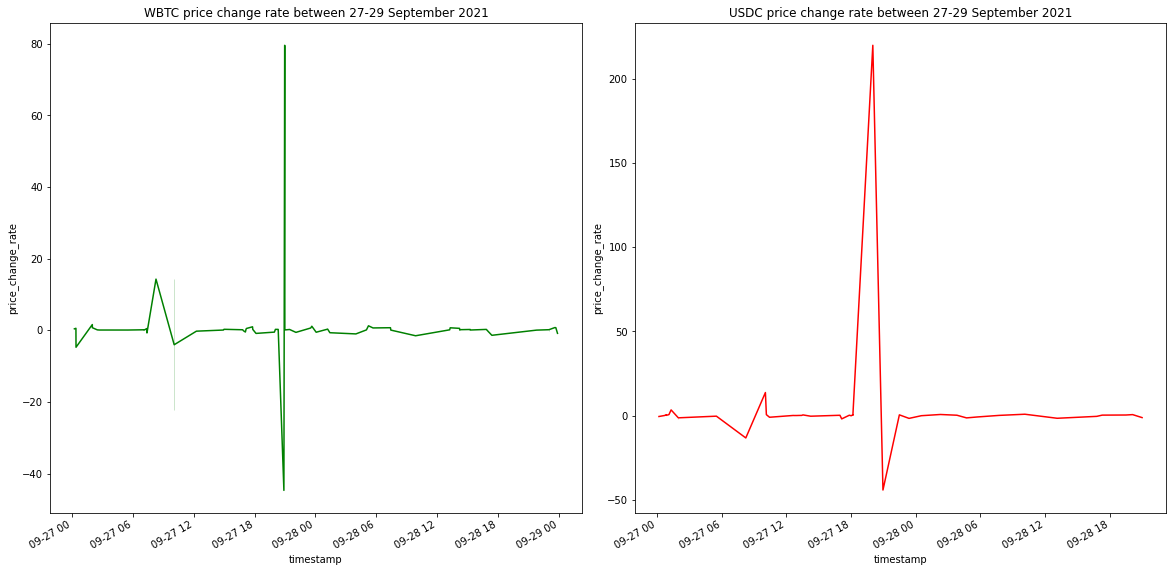

In [9]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=wbtc_usdc_df[(wbtc_usdc_df.token_in == 'WBTC') & (wbtc_usdc_df.timestamp > datetime(2021, 9, 27)) & 
                    (wbtc_usdc_df.timestamp < datetime(2021, 9, 29))], x='timestamp', y='price_change_rate', 
                    color='green').set_title('WBTC price change rate between 27-29 September 2021')
plt.subplot(1, 2, 2)
sns.lineplot(data=wbtc_usdc_df[(wbtc_usdc_df.token_in == 'USDC') & (wbtc_usdc_df.timestamp > datetime(2021, 9, 27)) & 
                    (wbtc_usdc_df.timestamp < datetime(2021, 9, 29))], x='timestamp', y='price_change_rate', 
                    color='red').set_title('USDC price change rate between 27-29 September 2021')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.autofmt_xdate()
plt.show()

In [10]:
wbtc_usdc_df[(wbtc_usdc_df.price_change_rate < -40) | (wbtc_usdc_df.price_change_rate > 60)]

token_in token_out      amount_in     amount_out     amount_usd  \
65603     USDC      WBTC    6000.000000       0.138634    6005.143255   
65607     WBTC      USDC       0.006960     297.845610     297.760491   
65608     USDC      WBTC   12797.000000       0.092386   12787.458570   
65609     USDC      WBTC  976323.861321      12.689636  975595.915259   
65610     WBTC      USDC      12.689636  981830.211723  981098.160132   
66006     USDC      WBTC    5875.205194       0.059231    5878.316962   

                timestamp  first_to_second_price  price_change_rate  
65603 2021-09-27 20:01:41               0.000023         220.049757  
65607 2021-09-27 20:53:21           42791.511683         -44.694234  
65608 2021-09-27 20:58:07               0.000007         -44.455047  
65609 2021-09-27 20:58:07               0.000013         -44.027899  
65610 2021-09-27 20:58:07           77372.604033          79.600818  
66006 2021-10-05 09:00:00               0.000010         -49.563526

In [11]:
wbtc_usdc_df[wbtc_usdc_df.timestamp == datetime(2021, 9, 27, 20, 58, 7)]

token_in token_out      amount_in     amount_out     amount_usd  \
65608     USDC      WBTC   12797.000000       0.092386   12787.458570   
65609     USDC      WBTC  976323.861321      12.689636  975595.915259   
65610     WBTC      USDC      12.689636  981830.211723  981098.160132   

                timestamp  first_to_second_price  price_change_rate  
65608 2021-09-27 20:58:07               0.000007         -44.455047  
65609 2021-09-27 20:58:07               0.000013         -44.027899  
65610 2021-09-27 20:58:07           77372.604033          79.600818

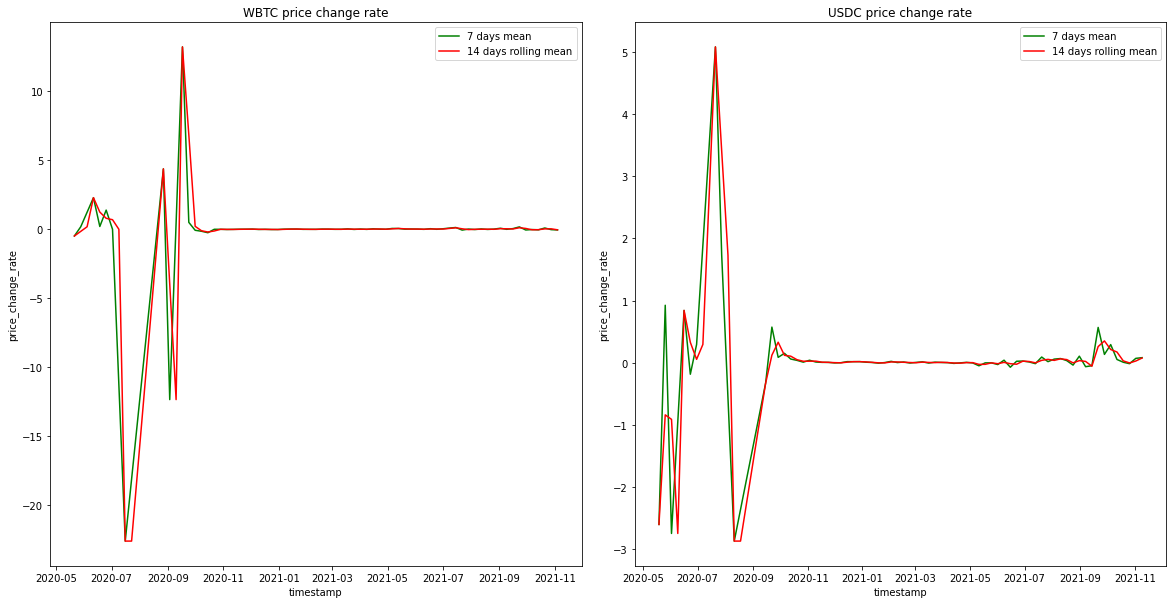

In [23]:
swaps_price_increase_rates_moving_averages(wbtc_usdc_df, first_token='WBTC', second_token='USDC', 
                                           first_plot_name='WBTC price change rate', second_plot_name='USDC price change rate', 
                                           x_size=20, y_size=10)

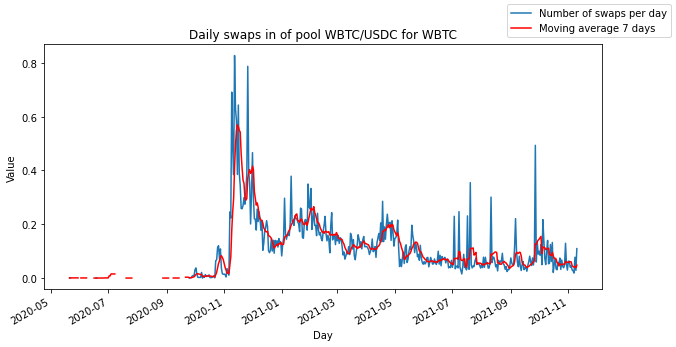

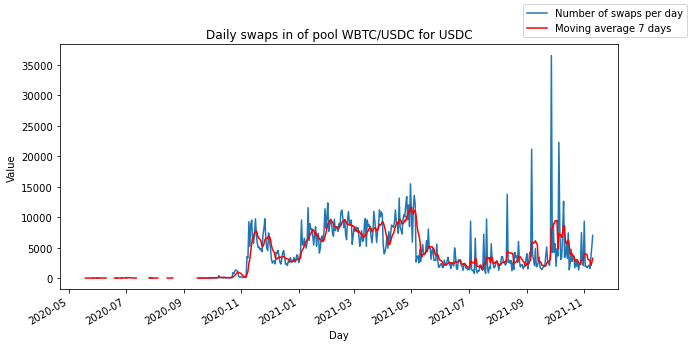

In [3]:
show_swaps_amount_in_moving_averages(swaps_df=wbtc_usdc_df[(wbtc_usdc_df.token_in == 'WBTC')], 
                                     pool_name="WBTC/USDC for WBTC")
show_swaps_amount_in_moving_averages(swaps_df=wbtc_usdc_df[(wbtc_usdc_df.token_in == 'USDC')], 
                                     pool_name="WBTC/USDC for USDC")

### Swaps values histograms

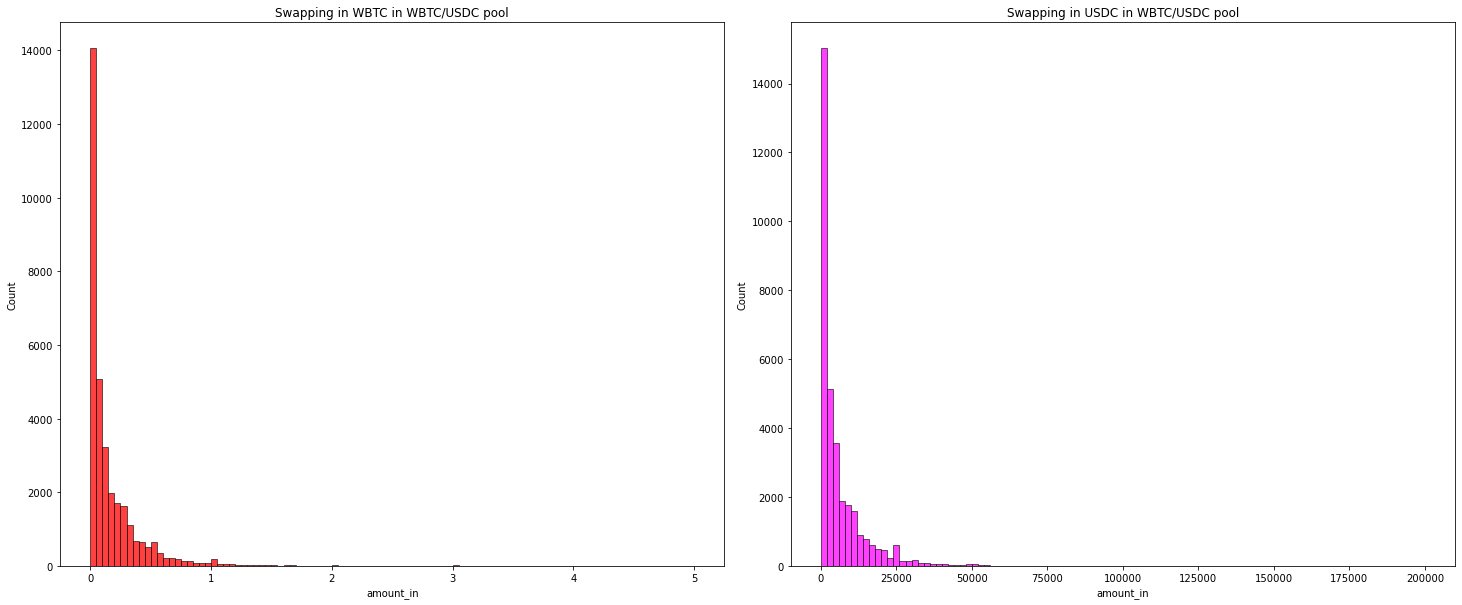

In [118]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=wbtc_usdc_df[wbtc_usdc_df.token_in == 'WBTC'], x='amount_in', bins=100, 
             color='red', binrange=[0, 5]).set_title("Swapping in WBTC in WBTC/USDC pool")
plt.subplot(1, 2, 2)
sns.histplot(data=wbtc_usdc_df[wbtc_usdc_df.token_in == 'USDC'], x='amount_in', bins=100, 
             color='magenta', binrange=[0, 200000]).set_title("Swapping in USDC in WBTC/USDC pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

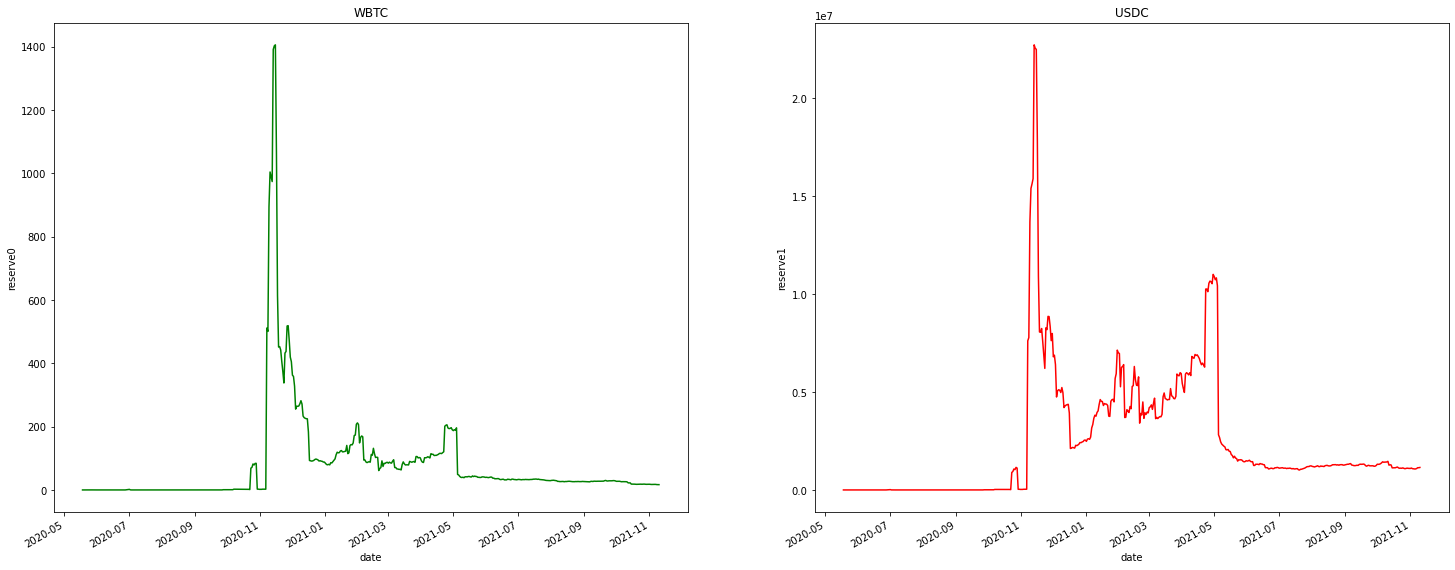

In [110]:
show_swaps_reserves_evolution_through_time(wbtc_usdc_reserves_df, first_token_reserve_name="WBTC", 
                                           second_token_reserve_name="USDC", x=25, y=10)

In [207]:
wbtc_usdc_reserves_df

reserve0      reserve1    reserveUSD  dailyVolumeToken0  \
0     0.000038  3.685930e-01  7.349464e-01           0.000000   
1     0.042824  4.157976e+02  8.294344e+02           0.000016   
2     0.010993  1.067343e+02  2.135402e+02           0.000000   
3     0.011243  1.043669e+02  2.075372e+02           0.000250   
4     0.112290  1.023060e+03  2.051484e+03           0.001047   
..         ...           ...           ...                ...   
452  17.582937  1.072743e+06  2.151174e+06           0.888925   
453  17.524837  1.095700e+06  2.197354e+06           0.546572   
454  16.907084  1.136411e+06  2.271292e+06           3.409224   
455  16.935825  1.134730e+06  2.272722e+06           1.227878   
456  16.756473  1.147624e+06  2.300608e+06           3.680584   

     dailyVolumeToken1       date  
0             0.000000 2020-05-18  
1             0.153417 2020-05-19  
2             0.000000 2020-05-20  
3             2.367365 2020-05-21  
4             9.603013 2020-05-22  
..                 ...        ...  
452       53698.423442 2021-11-06  
453       34049.114076 2021-11-07  
454      222629.015497 2021-11-08  
455       83062.706083 2021-11-09  
456      252909.725500 2021-11-10  

[457 rows x 6 columns]

In [208]:
wbtc_usdc_reserves_df[wbtc_usdc_reserves_df.date == datetime(2021, 9, 27)]

reserve0      reserve1    reserveUSD  dailyVolumeToken0  \
412  28.928488  1.233699e+06  2.465626e+06          38.289849   

     dailyVolumeToken1       date  
412       2.487946e+06 2021-09-27

### Plotting price distribution in pool

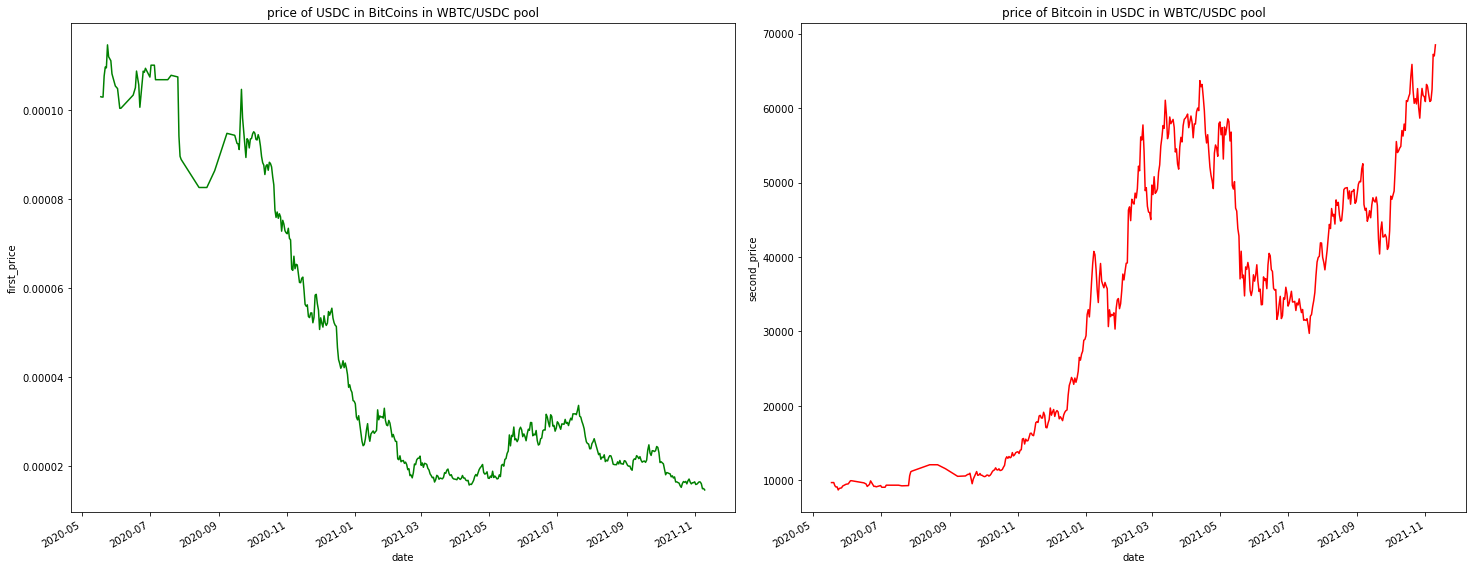

In [109]:
show_pool_price_evolution_from_reserves(wbtc_usdc_reserves_df, first_token_price_name="price of USDC in BitCoins in WBTC/USDC pool", 
                                        second_token_price_name="price of Bitcoin in USDC in WBTC/USDC pool", x=25, y=10, wspace=0.1)

### Plot price increase rates distribution and their mean distribution

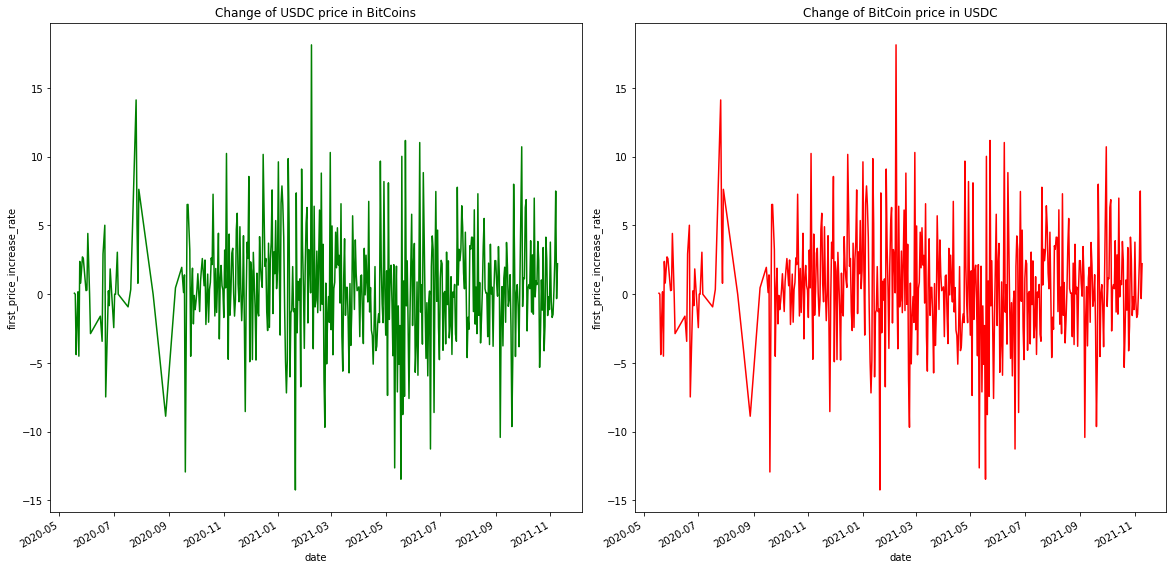

In [42]:
calc_price_and_increase_rates(wbtc_usdc_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=wbtc_usdc_reserves_df, x='date', y='first_price_increase_rate', color='green'
             ).set_title('Change of USDC price in BitCoins')
plt.subplot(1, 2, 2)
sns.lineplot(data=wbtc_usdc_reserves_df, x='date', y='first_price_increase_rate', color='red'
             ).set_title('Change of BitCoin price in USDC')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

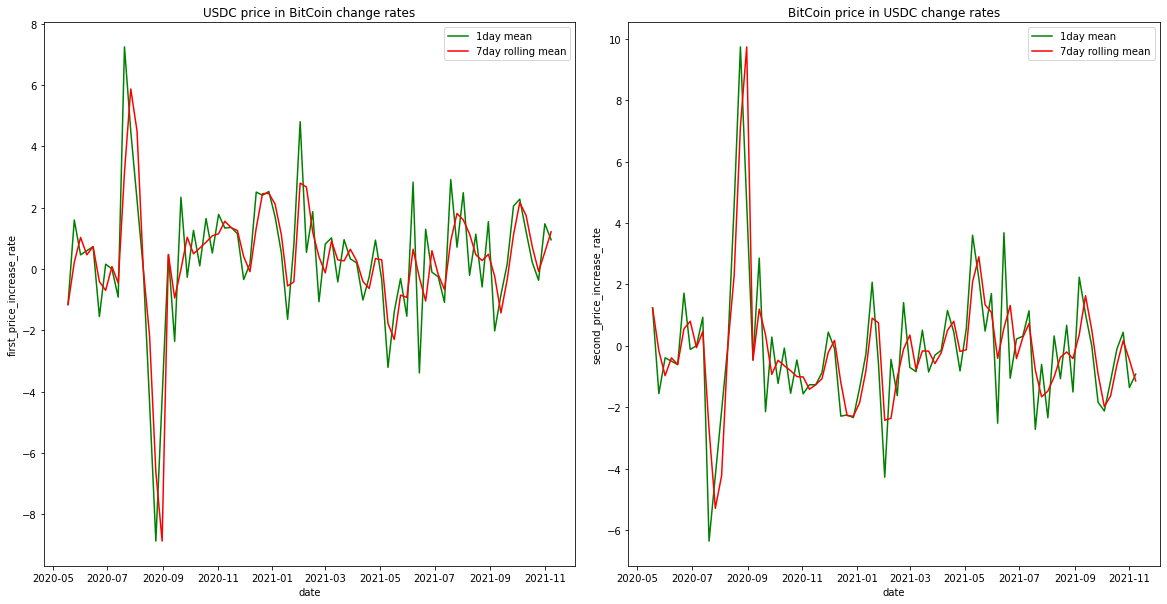

In [39]:
increase_rate_moving_averages(wbtc_usdc_reserves_df, 'USDC price in BitCoin change rates', 'BitCoin price in USDC change rates', x_size=20, y_size=10)

## ETH/USDC

In [8]:
weth_usdc_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\weth_usdc_swaps.pkl')
weth_usdc_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\weth_usdc_mints.pkl")
weth_usdc_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\weth_usdc_burns.pkl")
weth_usdc_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\weth_usdc_reserves.pkl")

## Plotting swapping in moving averages

In [9]:
weth_usdc_df['first_to_second_price'] = weth_usdc_df.amount_out / weth_usdc_df.amount_in
weth_usdc_df['price_change_rate'] = np.ones(len(weth_usdc_df))

weth_price_story = weth_usdc_df[weth_usdc_df.token_in == 'WETH'].first_to_second_price
usdc_price_story = weth_usdc_df[weth_usdc_df.token_in == 'USDC'].first_to_second_price
weth_price_story = weth_price_story.shift(periods=-1)
usdc_price_story = usdc_price_story.shift(periods=-1)

weth_weth_usdc_df = weth_usdc_df[weth_usdc_df.token_in == 'WETH']
usdc_weth_usdc_df = weth_usdc_df[weth_usdc_df.token_in == 'USDC']

weth_weth_usdc_df.price_change_rate = ((weth_weth_usdc_df.first_to_second_price - weth_price_story) / 
                                       weth_price_story) * 100
usdc_weth_usdc_df.price_change_rate = ((usdc_weth_usdc_df.first_to_second_price - usdc_price_story) / 
                                       usdc_price_story) * 100

weth_usdc_df = pd.concat([weth_weth_usdc_df, usdc_weth_usdc_df])
weth_usdc_df.sort_index(inplace=True)

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


First version of plotting the data, using ```seaborn``` module

In [ ]:
%%time
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=weth_usdc_df[weth_usdc_df.token_in == 'WETH'], 
             x='timestamp', y='price_change_rate', color='green').set_title('WETH price change rate')
plt.subplot(1, 2, 2)
sns.lineplot(data=weth_usdc_df[weth_usdc_df.token_in == 'USDC'], 
             x='timestamp', y='price_change_rate', color='red').set_title('USDC price change rate')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

C:\Users\Zbook\anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Second version of plotting the data using ```matplotlib``` module

In [ ]:
%%time
fig, ax = fig.subplots(figsize(10, 10))
fig.autofmt_xdate()

# plot presented information
ax.plot_date(weth_usdc_df[weth_usdc_df.token_in == 'WETH'].timestamp, 
             weth_usdc_df[weth_usdc_df.token_in == 'WETH'].price_change_rate, 
             linestyle='solid', marker=None, 
             label='Ethereum price change rates')
# plot presented information
ax.plot_date(weth_usdc_df[weth_usdc_df.token_in == 'USDC'].timestamp, 
             weth_usdc_df[weth_usdc_df.token_in == 'USDC'].price_change_rate, 
             linestyle='solid', marker=None, color='red',
             label='Ethereum price change rates')
    
# set labels
ax.set_xlabel("Day")
ax.set_ylabel("Value")
ax.set_title("Daily swaps in of pool " + pool_name)
fig.legend()

In [ ]:
swaps_price_increase_rates_moving_averages(weth_usdc_df, first_token='WETH', second_token='USDC', 
                                           first_plot_name='WETH price change rate', second_plot_name='USDC price change rate', 
                                           x_size=20, y_size=10)

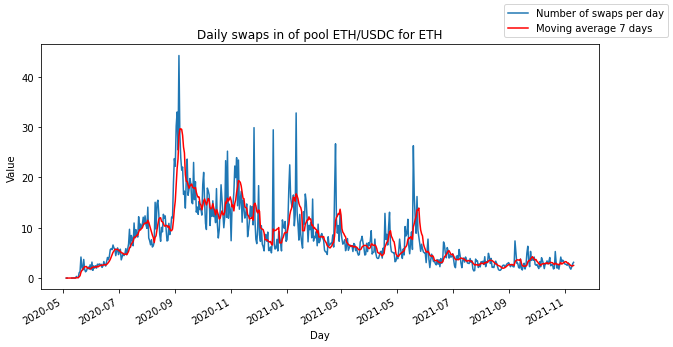

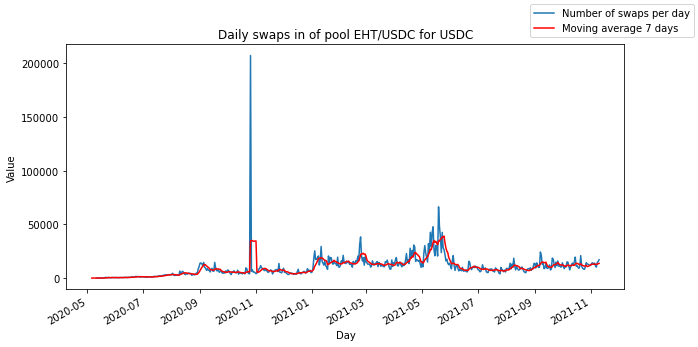

In [8]:
show_swaps_amount_in_moving_averages(swaps_df=weth_usdc_df[(weth_usdc_df.token_in == 'WETH')], pool_name="ETH/USDC for ETH")
show_swaps_amount_in_moving_averages(swaps_df=weth_usdc_df[(weth_usdc_df.token_in == 'USDC')], pool_name="EHT/USDC for USDC")

### Swaps value histograms

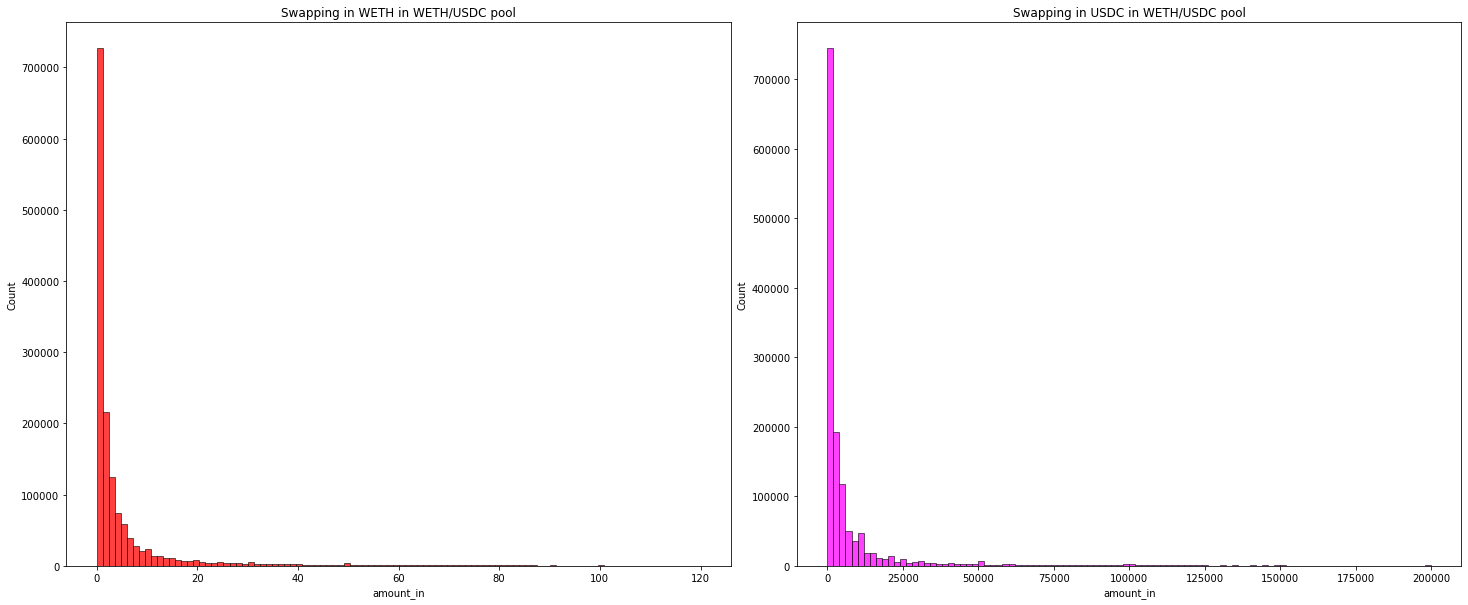

In [127]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=weth_usdc_df[weth_usdc_df.token_in == 'WETH'], x='amount_in', bins=100, color='red', binrange=[0, 120]).set_title("Swapping in WETH in WETH/USDC pool")
plt.subplot(1, 2, 2)
sns.histplot(data=weth_usdc_df[weth_usdc_df.token_in == 'USDC'], x='amount_in', bins=100, color='magenta', binrange=[0, 200000]).set_title("Swapping in USDC in WETH/USDC pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

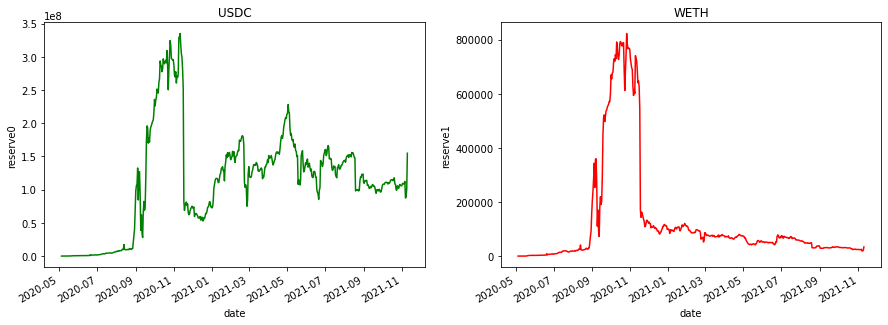

In [11]:
show_swaps_reserves_evolution_through_time(weth_usdc_reserves_df, first_token_reserve_name="USDC", second_token_reserve_name="WETH", x=15)

### Plottting price distribution for pool

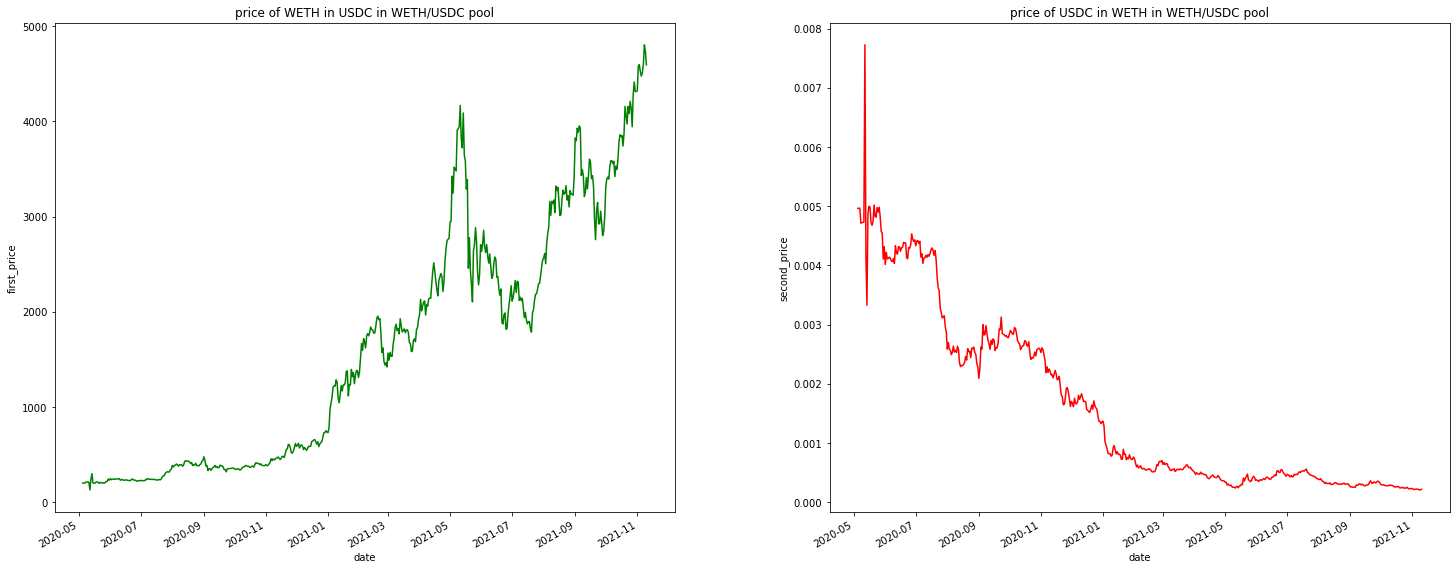

In [107]:
show_pool_price_evolution_from_reserves(weth_usdc_reserves_df, first_token_price_name="price of WETH in USDC in WETH/USDC pool", 
                                        second_token_price_name="price of USDC in WETH in WETH/USDC pool", x=25, y=10)

### Plotting price change rates and their mean distributions

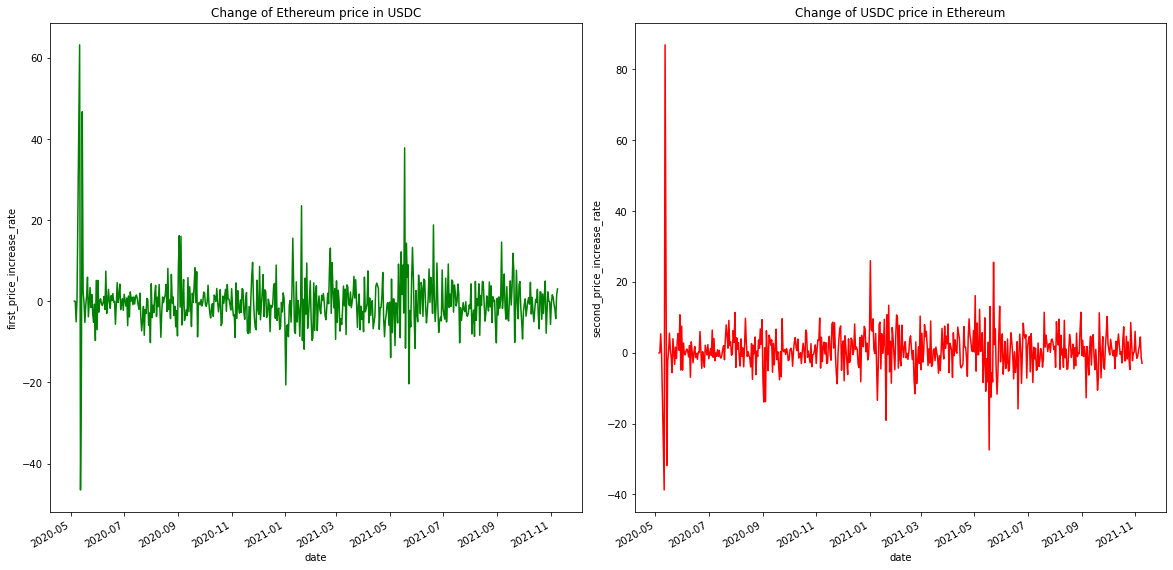

In [71]:
calc_price_and_increase_rates(weth_usdc_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=weth_usdc_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in USDC')
plt.subplot(1, 2, 2)
sns.lineplot(data=weth_usdc_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of USDC price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

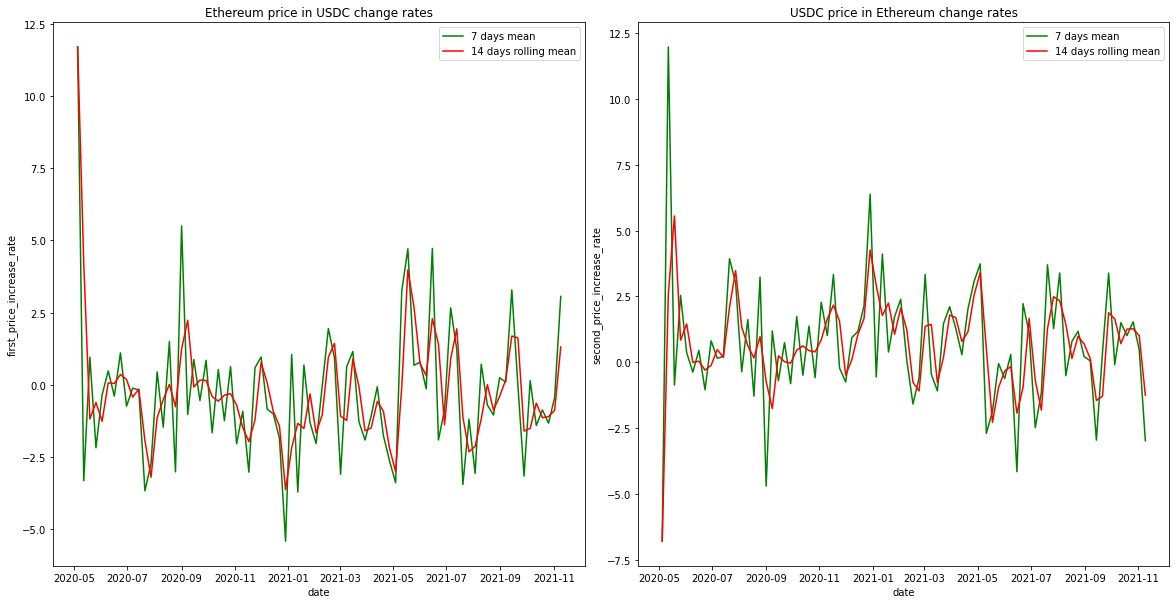

In [48]:
increase_rate_moving_averages(weth_usdc_reserves_df, 'Ethereum price in USDC change rates', 'USDC price in Ethereum change rates', x_size=20, y_size=10)

## WBTC/DAI (fixed pickle)

In [49]:
wbtc_dai_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\wbtc_dai_swaps.pkl')
wbtc_dai_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\wbtc_dai_mints.pkl")
wbtc_dai_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\wbtc_dai_burns.pkl")
wbtc_dai_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\wbtc_dai_reserves.pkl")

### Plotting swapping in moving averages

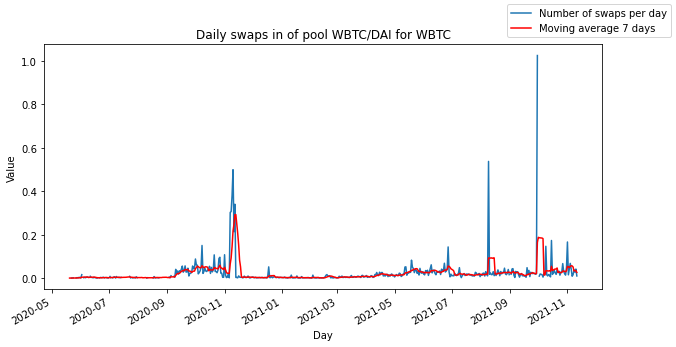

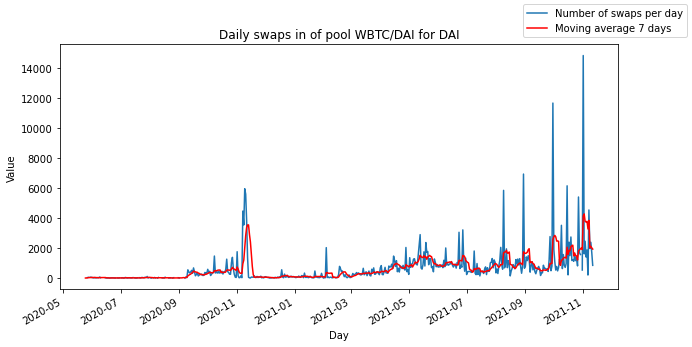

In [14]:
show_swaps_amount_in_moving_averages(swaps_df=wbtc_dai_df[(wbtc_dai_df.token_in == 'WBTC')], pool_name="WBTC/DAI for WBTC")
show_swaps_amount_in_moving_averages(swaps_df=wbtc_dai_df[(wbtc_dai_df.token_in == 'DAI')], pool_name="WBTC/DAI for DAI")

### Swaps values histograms

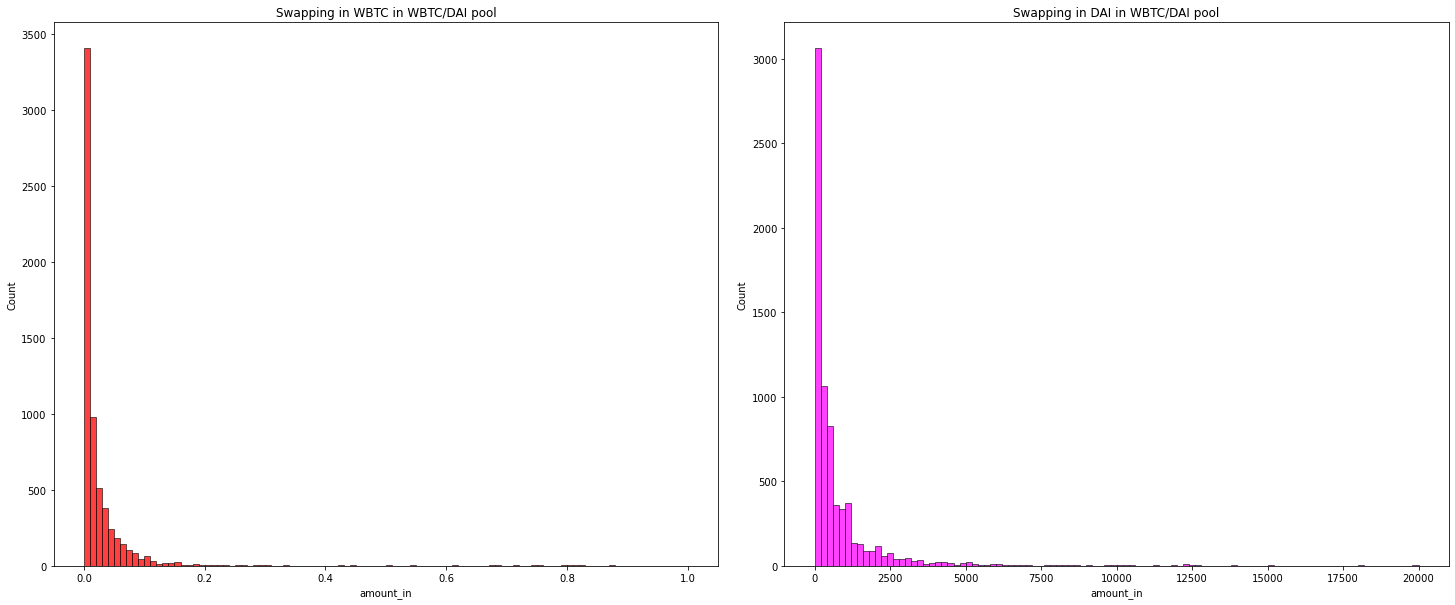

In [130]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=wbtc_dai_df[wbtc_dai_df.token_in == 'WBTC'], x='amount_in', bins=100, color='red', binrange=[0, 1]).set_title("Swapping in WBTC in WBTC/DAI pool")
plt.subplot(1, 2, 2)
sns.histplot(data=wbtc_dai_df[wbtc_dai_df.token_in == 'DAI'], x='amount_in', bins=100, color='magenta', binrange=[0, 20000]).set_title("Swapping in DAI in WBTC/DAI pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

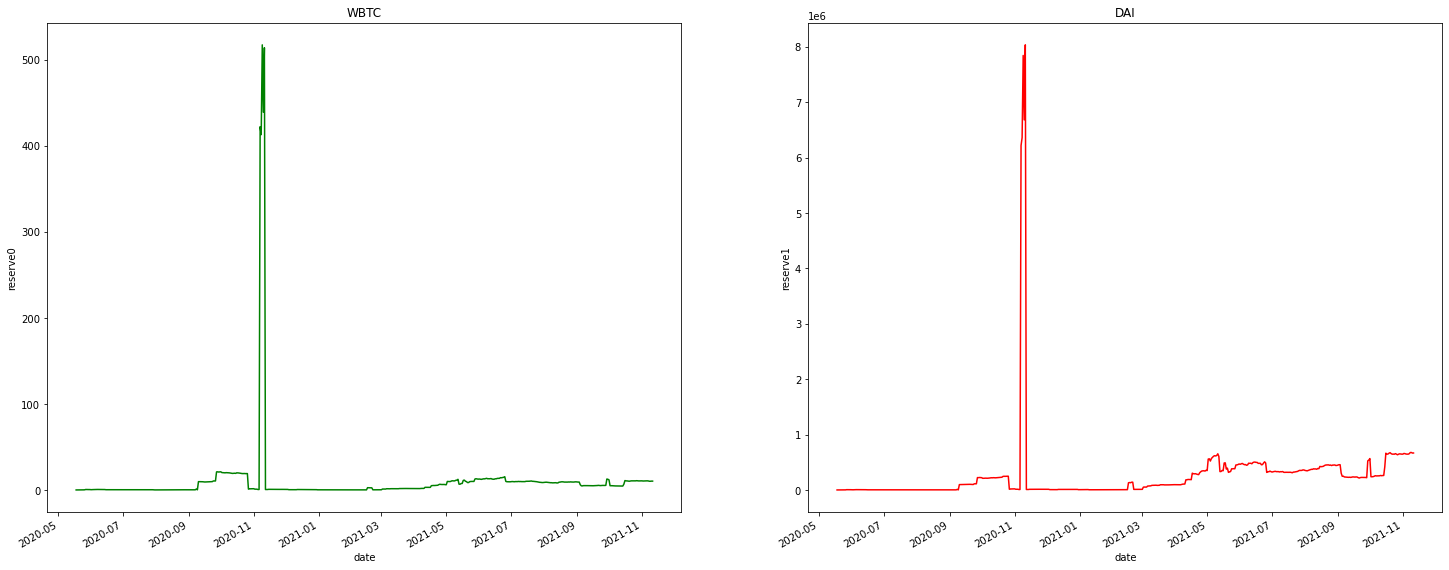

In [106]:
show_swaps_reserves_evolution_through_time(wbtc_dai_reserves_df, first_token_reserve_name="WBTC", second_token_reserve_name="DAI", x=25, y=10)

### Plotting price distribution in pool

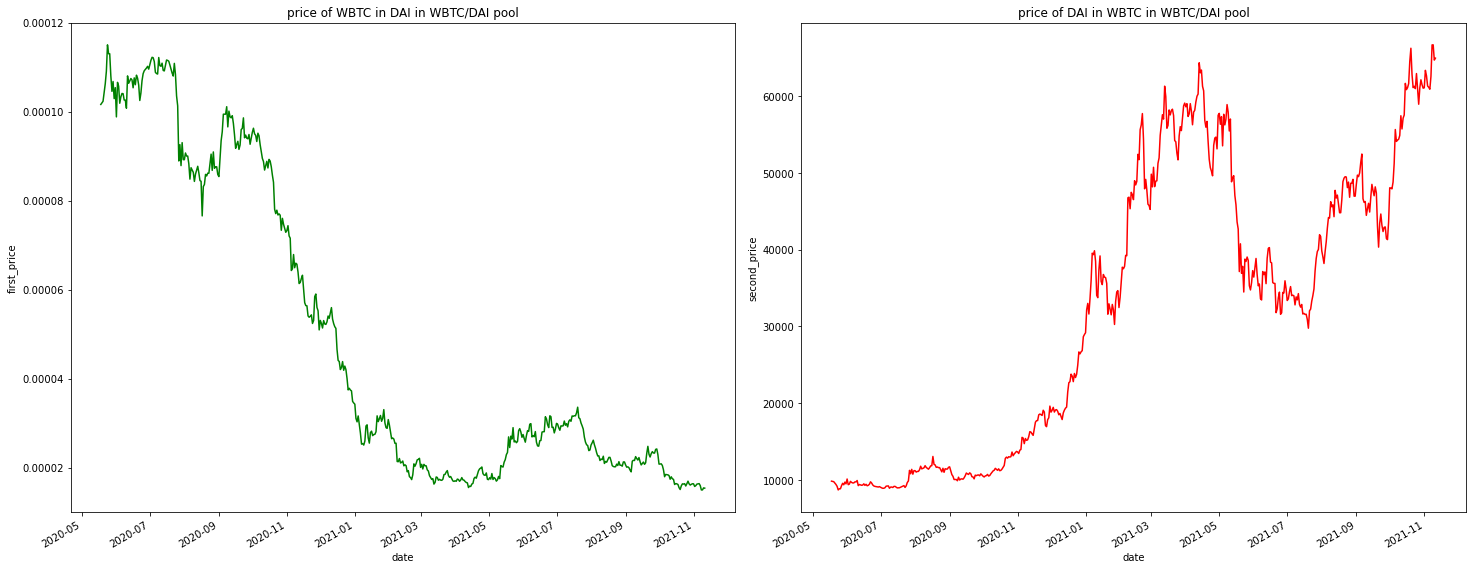

In [105]:
show_pool_price_evolution_from_reserves(wbtc_dai_reserves_df, first_token_price_name="price of WBTC in DAI in WBTC/DAI pool", 
                                        second_token_price_name="price of DAI in WBTC in WBTC/DAI pool", x=25, y=10, wspace=0.1)

### Plotting price changes rates and their mean distribution

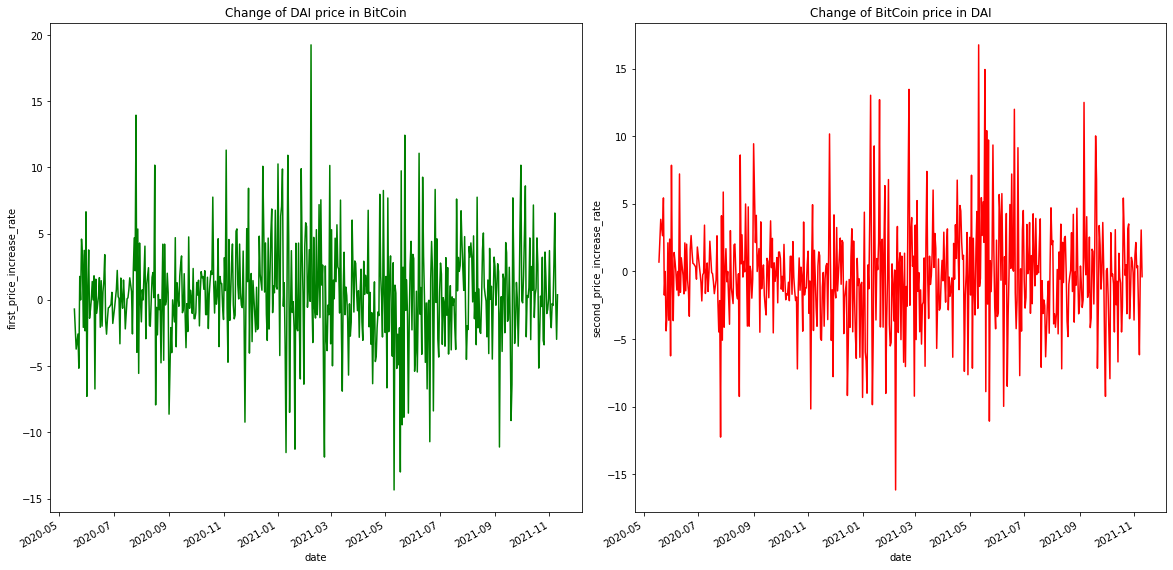

In [70]:
calc_price_and_increase_rates(wbtc_dai_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=wbtc_dai_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of DAI price in BitCoin')
plt.subplot(1, 2, 2)
sns.lineplot(data=wbtc_dai_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of BitCoin price in DAI')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

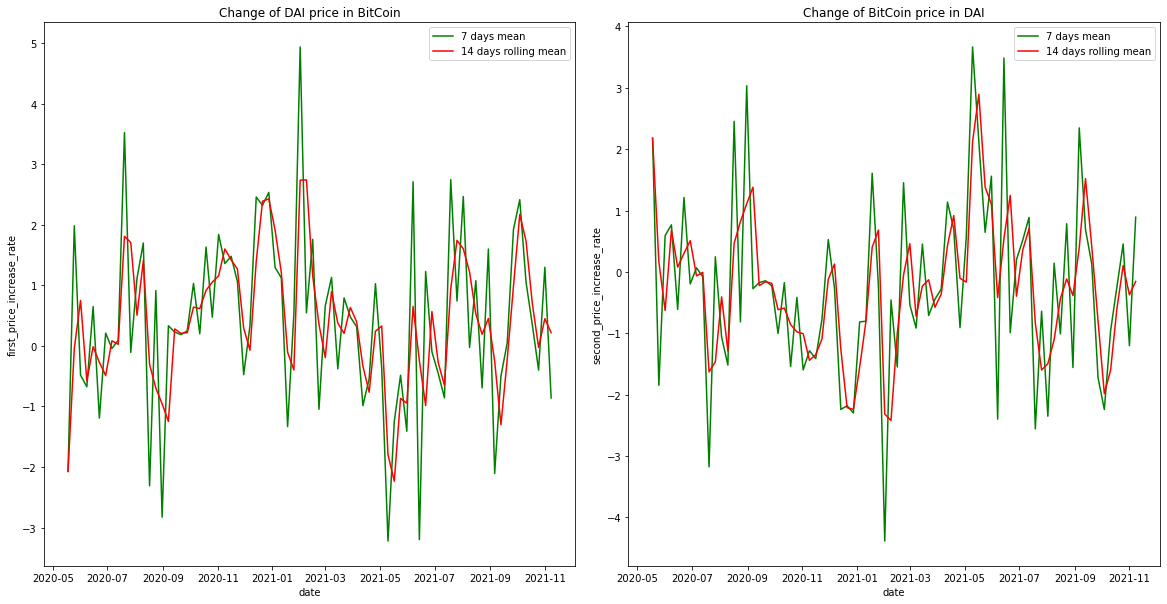

In [61]:
increase_rate_moving_averages(wbtc_dai_reserves_df, 'Change of DAI price in BitCoin', 'Change of BitCoin price in DAI', x_size=20, y_size=10)

## IXS/ETH

In [56]:
ixs_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\ixs_weth_swaps.pkl')
ixs_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\ixs_weth_mints.pkl")
ixs_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\ixs_weth_burns.pkl")
ixs_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\ixs_weth_reserves.pkl")

### Plotting swapping in moving averages

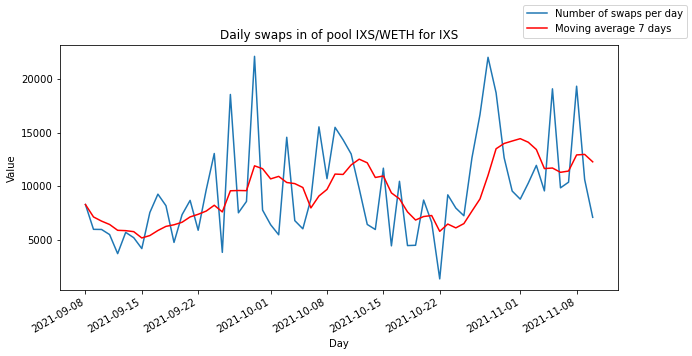

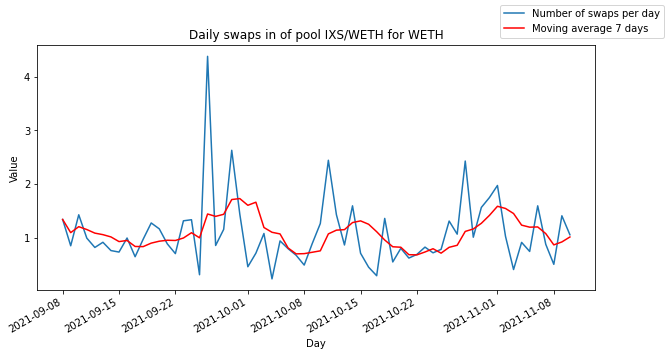

In [18]:
show_swaps_amount_in_moving_averages(swaps_df=ixs_weth_df[(ixs_weth_df.token_in == 'IXS')], pool_name="IXS/WETH for IXS")
show_swaps_amount_in_moving_averages(swaps_df=ixs_weth_df[(ixs_weth_df.token_in == 'WETH')], pool_name="IXS/WETH for WETH")

### Swaps values histograms

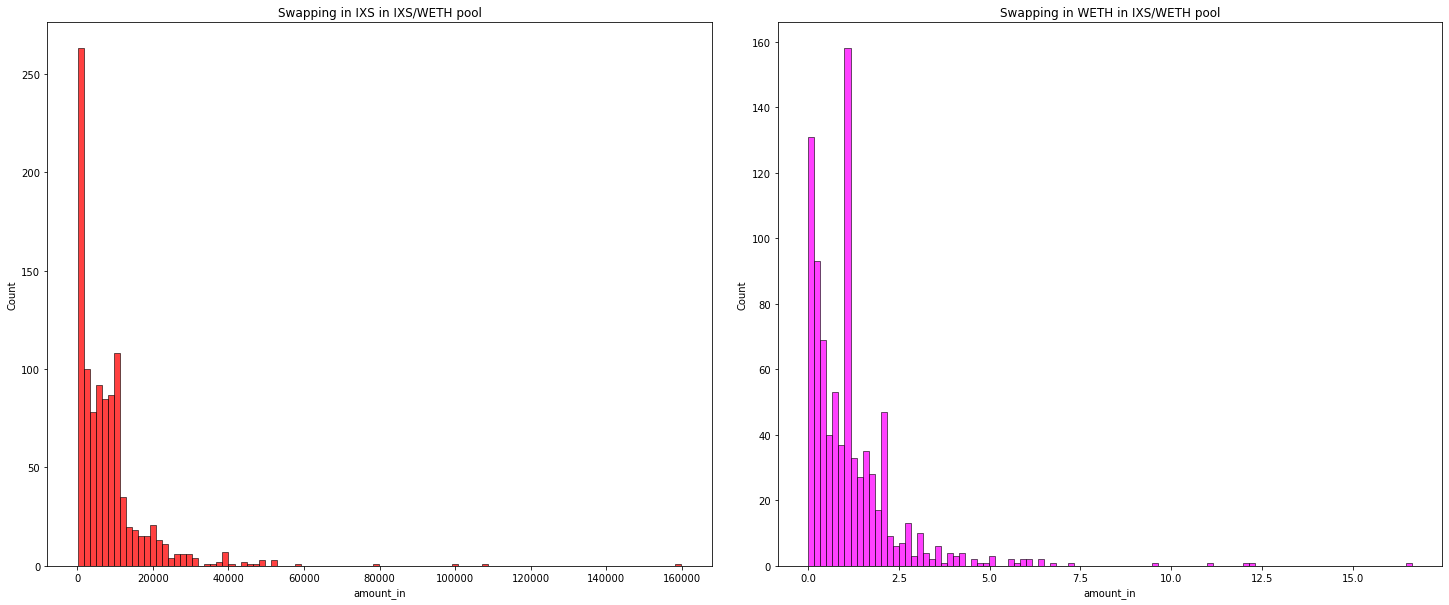

In [134]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=ixs_weth_df[ixs_weth_df.token_in == 'IXS'], x='amount_in', bins=100, color='red').set_title("Swapping in IXS in IXS/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=ixs_weth_df[ixs_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in IXS/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Pool reserves distribution

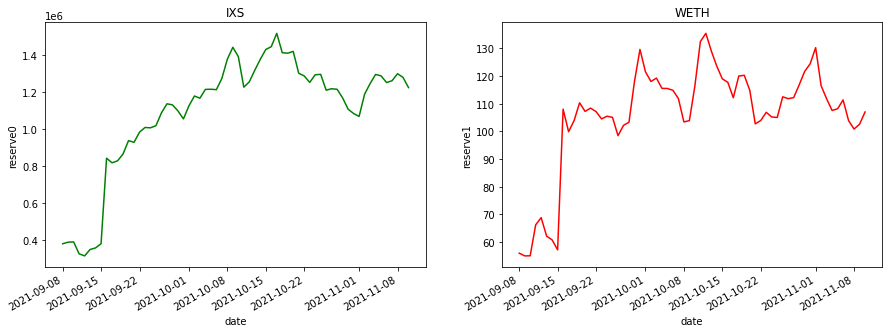

In [19]:
show_swaps_reserves_evolution_through_time(ixs_weth_reserves_df, first_token_reserve_name="IXS", second_token_reserve_name="WETH", x=15)

### Price distribution in pool

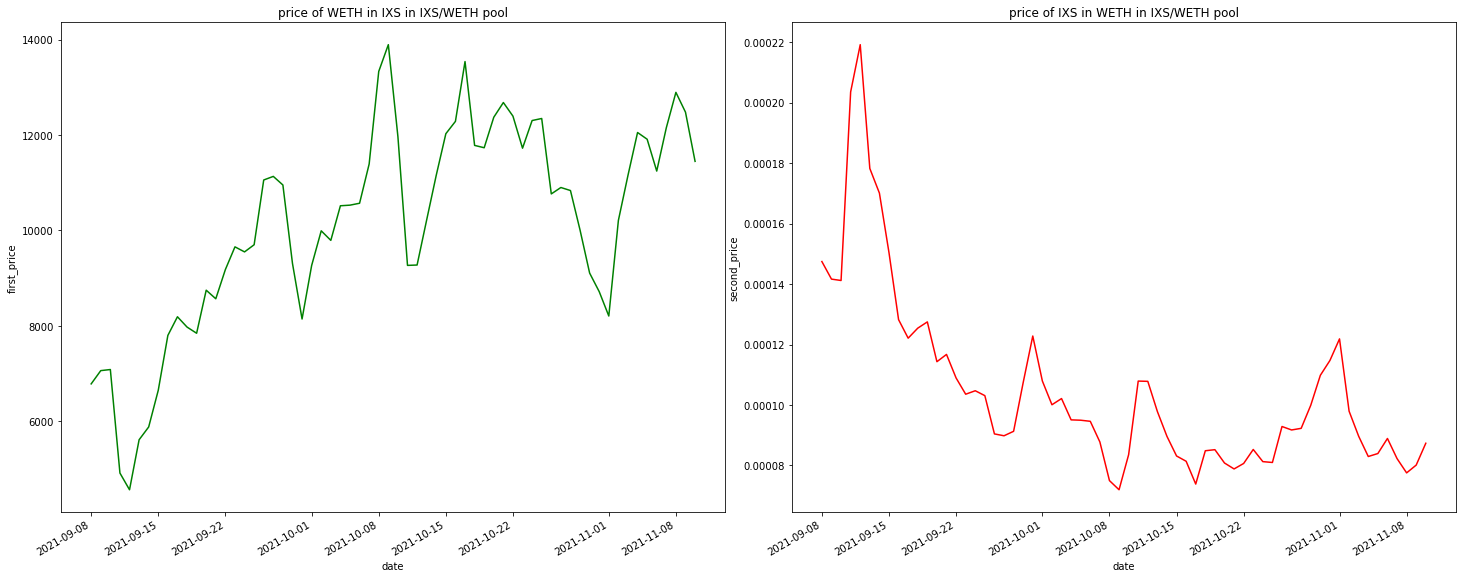

In [103]:
show_pool_price_evolution_from_reserves(ixs_weth_reserves_df, first_token_price_name="price of WETH in IXS in IXS/WETH pool", 
                                        second_token_price_name="price of IXS in WETH in IXS/WETH pool", x=25, y=10, wspace=0.1)

In [59]:
ixs_weth_reserves_df

reserve0    reserve1    reserveUSD  dailyVolumeToken0  \
0   3.794422e+05   55.944001  3.907889e+05       3.245787e+06   
1   3.880956e+05   54.966786  3.762270e+05       6.385440e+05   
2   3.895395e+05   54.992914  3.521057e+05       5.129601e+05   
3   3.251391e+05   66.178741  4.314507e+05       5.158716e+05   
4   3.138946e+05   68.793197  4.722017e+05       3.769885e+05   
..           ...         ...           ...                ...   
59  1.252272e+06  111.369945  9.959401e+05       1.743100e+05   
60  1.262068e+06  103.855905  9.562487e+05       1.157668e+05   
61  1.300168e+06  100.830539  9.533918e+05       7.774344e+04   
62  1.280204e+06  102.587502  9.790004e+05       1.272239e+05   
63  1.225047e+06  107.010865  1.036488e+06       9.656586e+04   

    dailyVolumeToken1       date   first_price  second_price  \
0          425.302832 2021-09-08   6782.535597      0.000147   
1           93.661413 2021-09-09   7060.548292      0.000142   
2           85.994939 2021-09-10   7083.448476      0.000141   
3           94.863760 2021-09-11   4913.044172      0.000204   
4           81.732506 2021-09-12   4562.873332      0.000219   
..                ...        ...           ...           ...   
59          16.011554 2021-11-06  11244.255455      0.000089   
60           9.582805 2021-11-07  12152.106556      0.000082   
61           6.108676 2021-11-08  12894.584609      0.000078   
62           9.640691 2021-11-09  12479.144669      0.000080   
63           8.216942 2021-11-10  11447.874259      0.000087   

    first_price_increase_rate  second_price_increase_rate  
0                   -3.937551                    4.098949  
1                   -0.323291                    0.324340  
2                   44.176365                  -30.640504  
3                    7.674349                   -7.127370  
4                  -18.680692                   22.972025  
..                        ...                         ...  
59                  -7.470730                    8.073910  
60                  -5.758061                    6.109871  
61                   3.329074                   -3.221817  
62                   9.008401                   -8.263951  
63                        NaN                         NaN  

[64 rows x 10 columns]

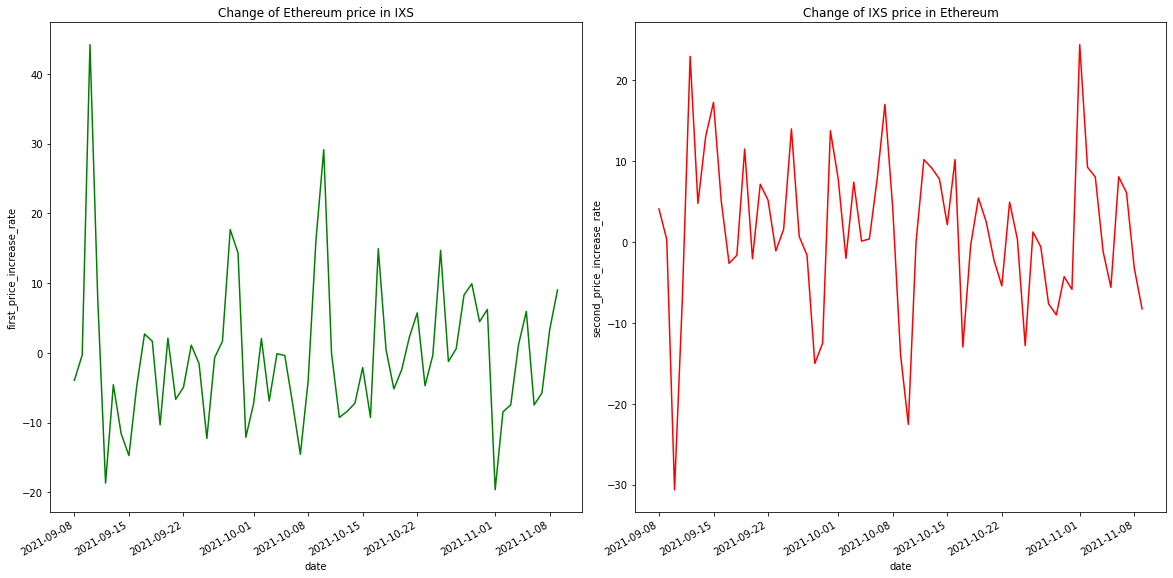

In [69]:
calc_price_and_increase_rates(ixs_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=ixs_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in IXS')
plt.subplot(1, 2, 2)
sns.lineplot(data=ixs_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of IXS price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

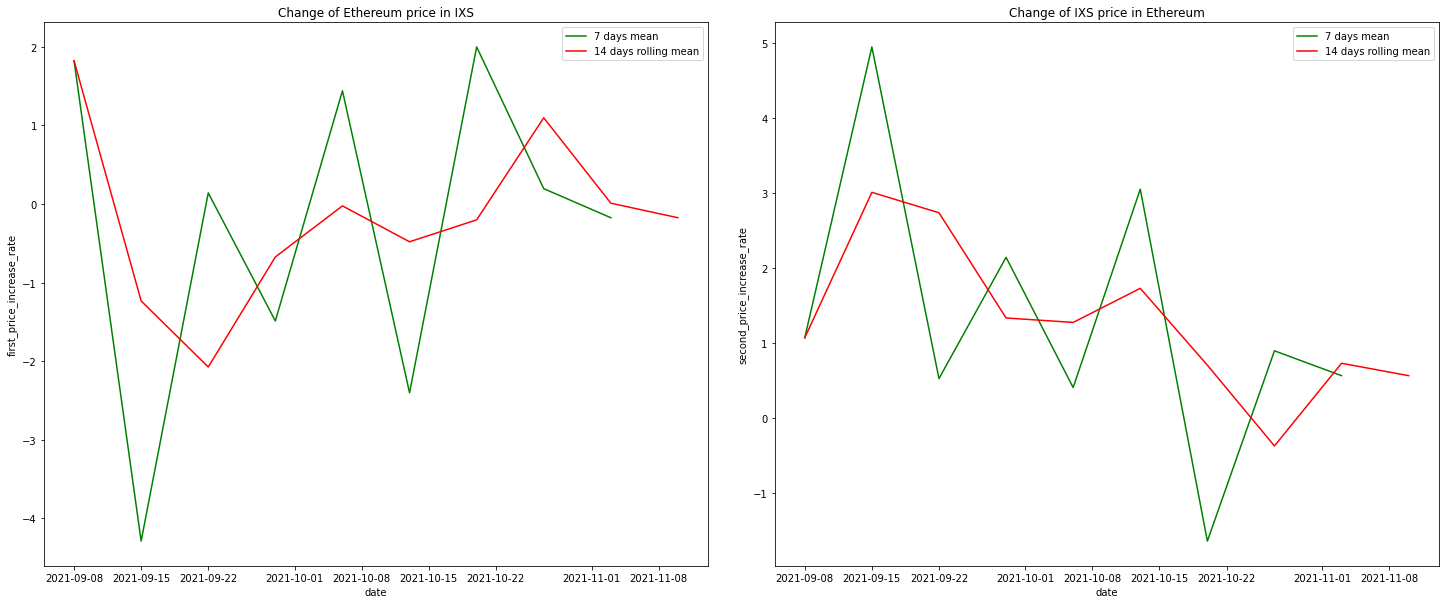

In [63]:
increase_rate_moving_averages(ixs_weth_reserves_df, 'Change of Ethereum price in IXS', 'Change of IXS price in Ethereum', x_size=25, y_size=10)

## SQUID/ETH

In [64]:
squid_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\squid_weth_swaps.pkl')
squid_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\squid_weth_mints.pkl")
squid_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\squid_weth_reserves.pkl")

### Plotting swapping in moving averages

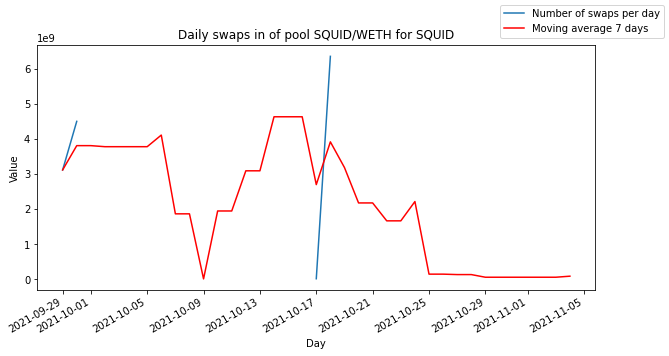

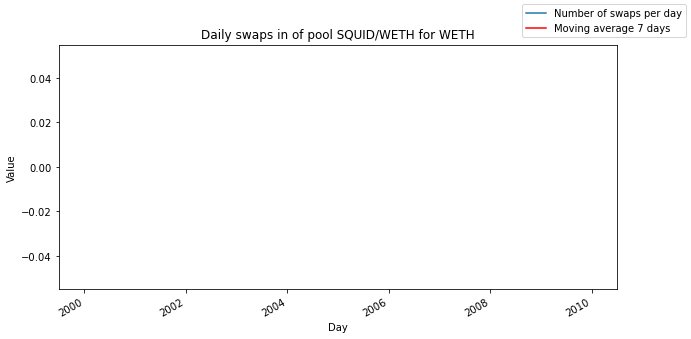

In [37]:
show_swaps_amount_in_moving_averages(swaps_df=squid_weth_df[(squid_weth_df.token_in == 'SQUID')], pool_name="SQUID/WETH for SQUID")
show_swaps_amount_in_moving_averages(swaps_df=squid_weth_df[(squid_weth_df.token_in == 'WETH')], pool_name="SQUID/WETH for WETH")

### Swaps values histograms

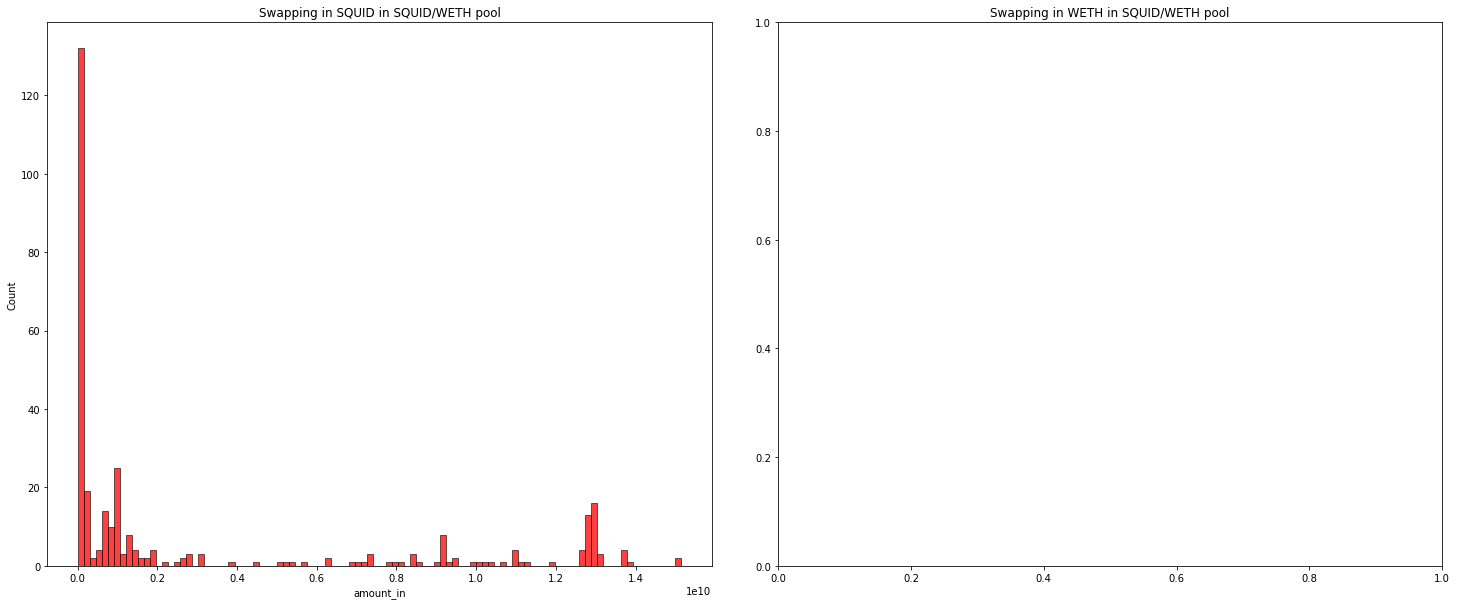

In [135]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=squid_weth_df[squid_weth_df.token_in == 'SQUID'], x='amount_in', bins=100, color='red').set_title("Swapping in SQUID in SQUID/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=squid_weth_df[squid_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in SQUID/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

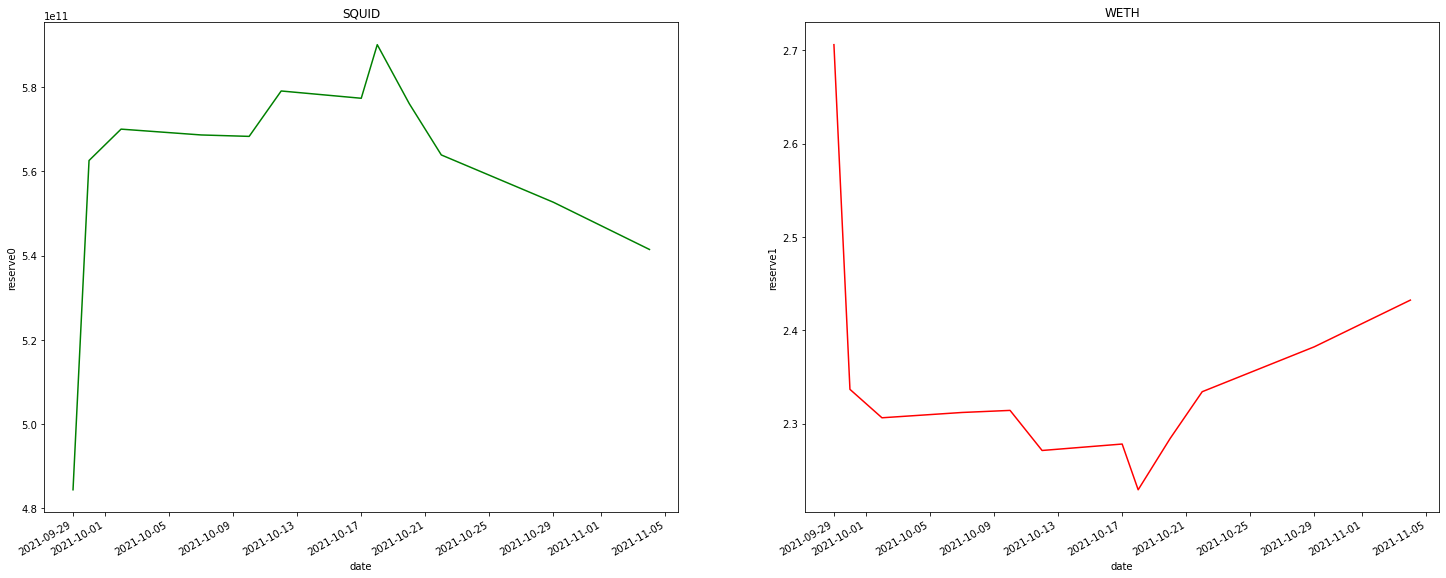

In [102]:
show_swaps_reserves_evolution_through_time(squid_weth_reserves_df, first_token_reserve_name="SQUID", second_token_reserve_name="WETH", x=25, y=10)

### Plotting pool prices

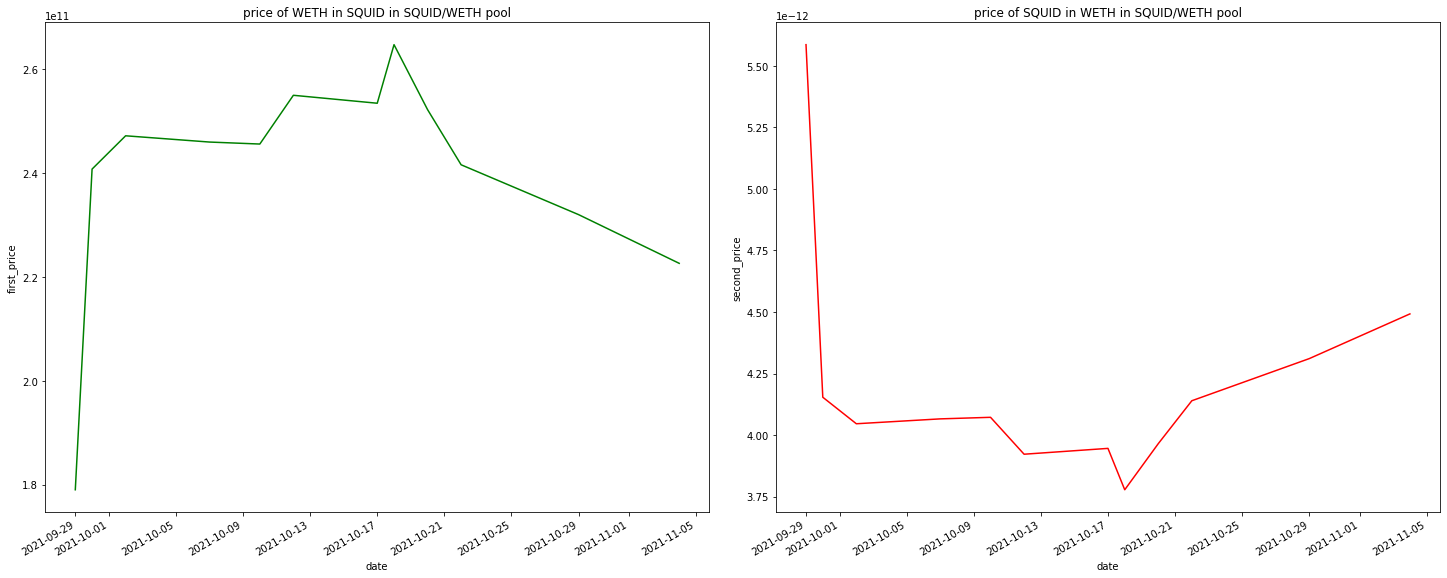

In [101]:
show_pool_price_evolution_from_reserves(squid_weth_reserves_df, first_token_price_name="price of WETH in SQUID in SQUID/WETH pool", 
                                        second_token_price_name="price of SQUID in WETH in SQUID/WETH pool", x=25, y=10, wspace=0.1)

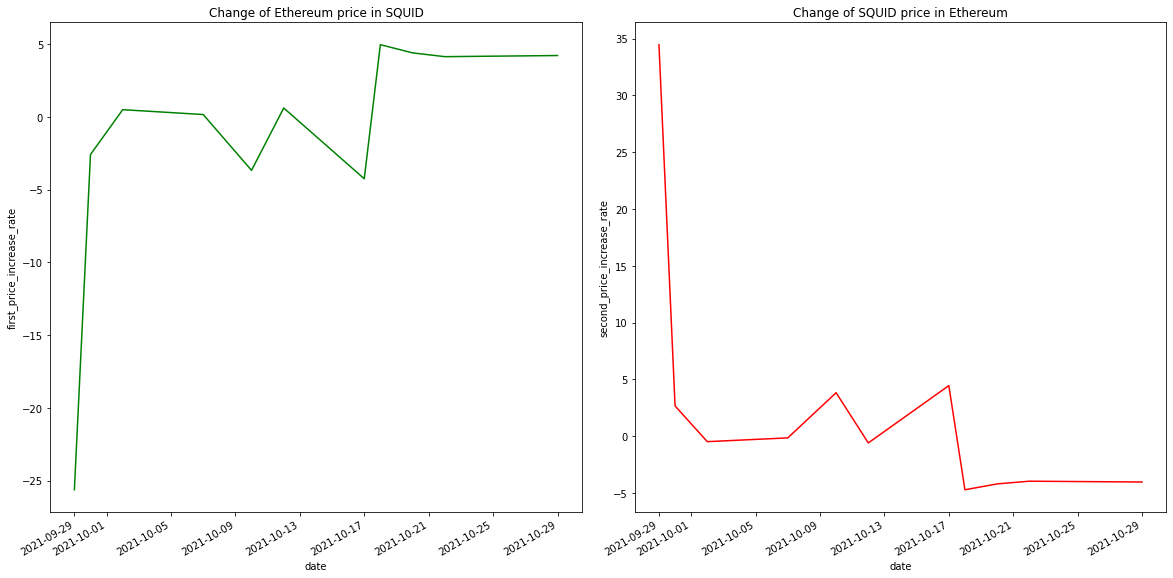

In [68]:
calc_price_and_increase_rates(squid_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=squid_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in SQUID')
plt.subplot(1, 2, 2)
sns.lineplot(data=squid_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of SQUID price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

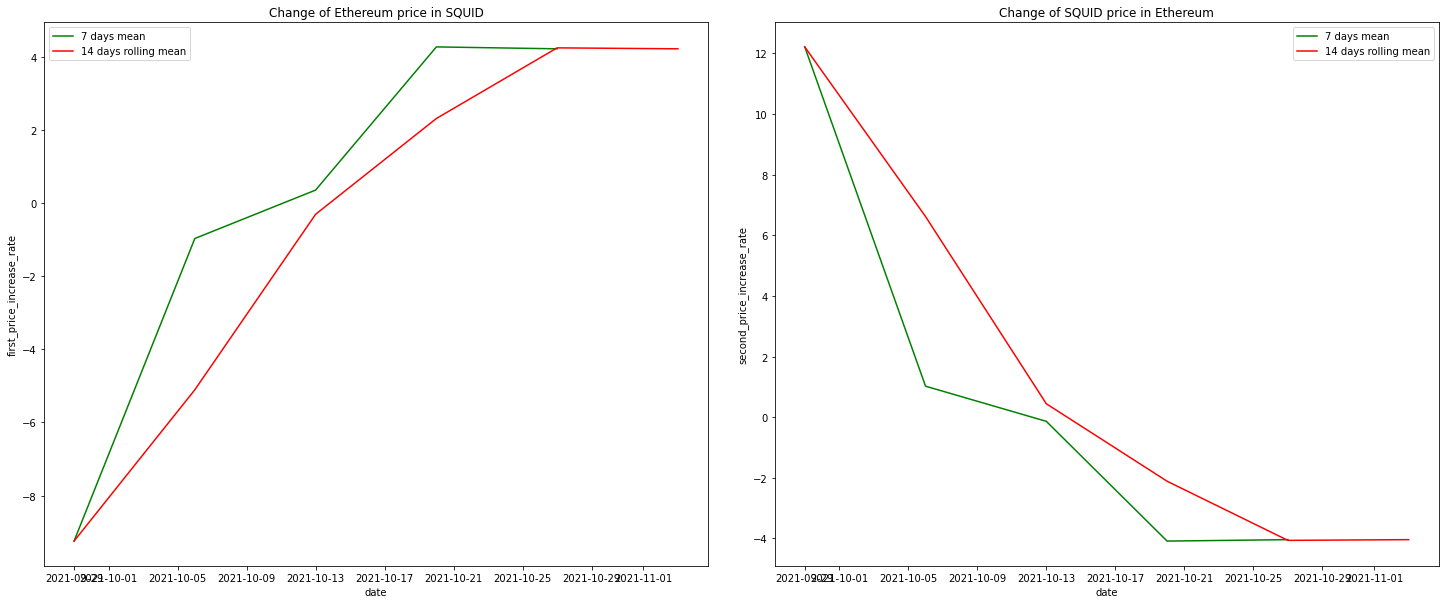

In [72]:
increase_rate_moving_averages(squid_weth_reserves_df, 'Change of Ethereum price in SQUID', 'Change of SQUID price in Ethereum', x_size=25, y_size=10)

## HKMT/USDT

In [73]:
hkmt_usdt_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\hkmt_usdt_swaps.pkl')
hkmt_usdt_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\hkmt_usdt_mints.pkl")
hkmt_usdt_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\hkmt_usdt_burns.pkl")
hkmt_usdt_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\hkmt_usdt_reserves.pkl")

### Plotting swapping in moving averages

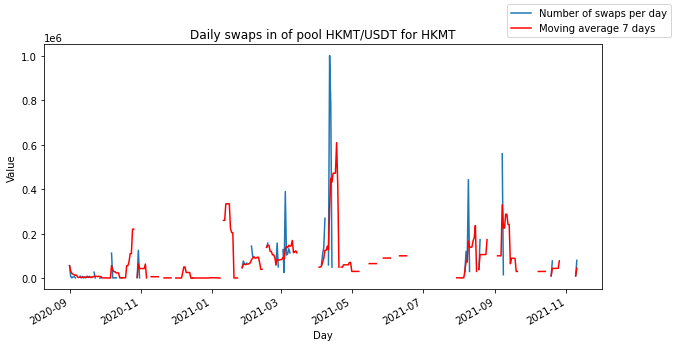

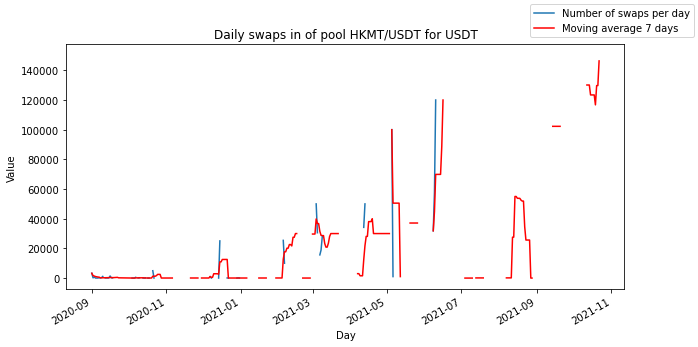

In [44]:
show_swaps_amount_in_moving_averages(swaps_df=hkmt_usdt_df[(hkmt_usdt_df.token_in == 'HKMT')], pool_name="HKMT/USDT for HKMT")
show_swaps_amount_in_moving_averages(swaps_df=hkmt_usdt_df[(hkmt_usdt_df.token_in == 'USDT')], pool_name="HKMT/USDT for USDT")

### Swaps values histograms

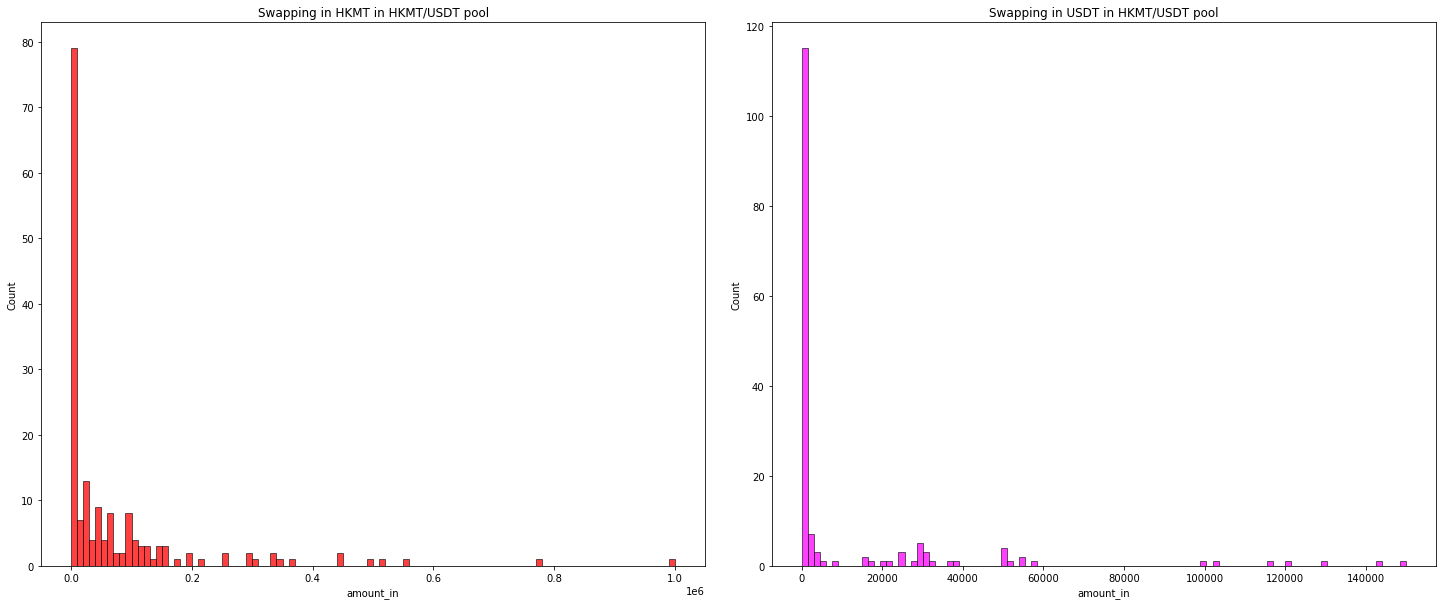

In [136]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=hkmt_usdt_df[hkmt_usdt_df.token_in == 'HKMT'], x='amount_in', bins=100, color='red').set_title("Swapping in HKMT in HKMT/USDT pool")
plt.subplot(1, 2, 2)
sns.histplot(data=hkmt_usdt_df[hkmt_usdt_df.token_in == 'USDT'], x='amount_in', bins=100, color='magenta').set_title("Swapping in USDT in HKMT/USDT pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

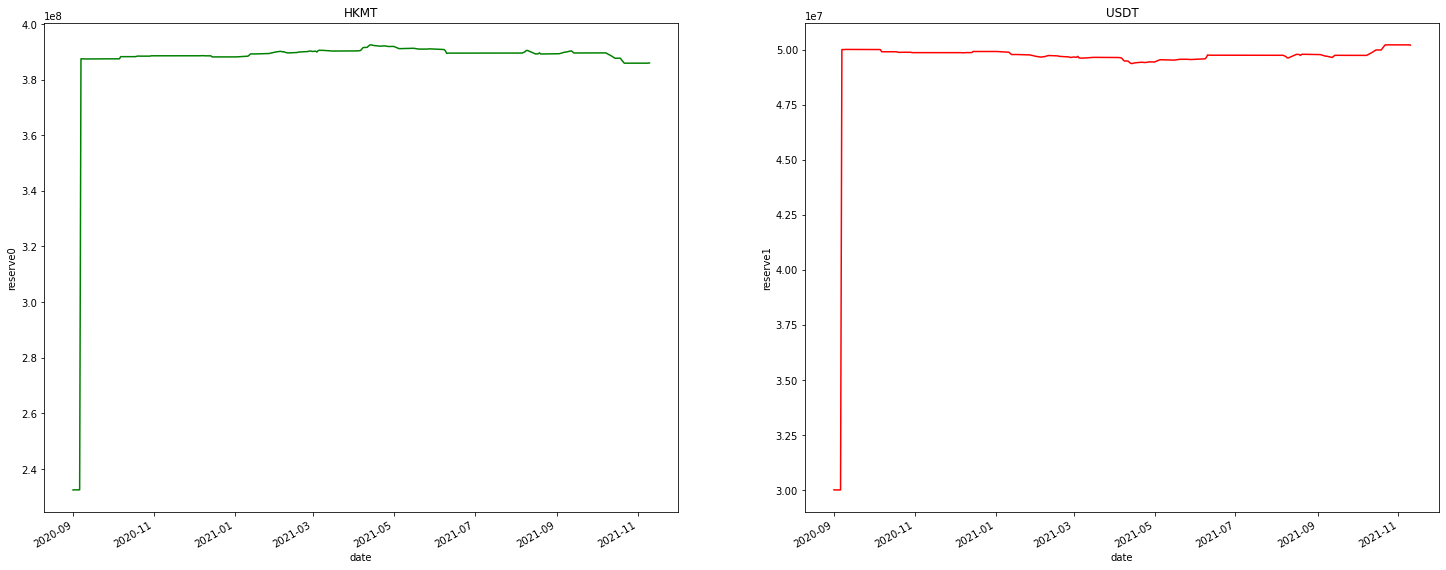

In [100]:
show_swaps_reserves_evolution_through_time(hkmt_usdt_reserves_df, first_token_reserve_name="HKMT", second_token_reserve_name="USDT", x=25, y=10)

### Plotting pool price

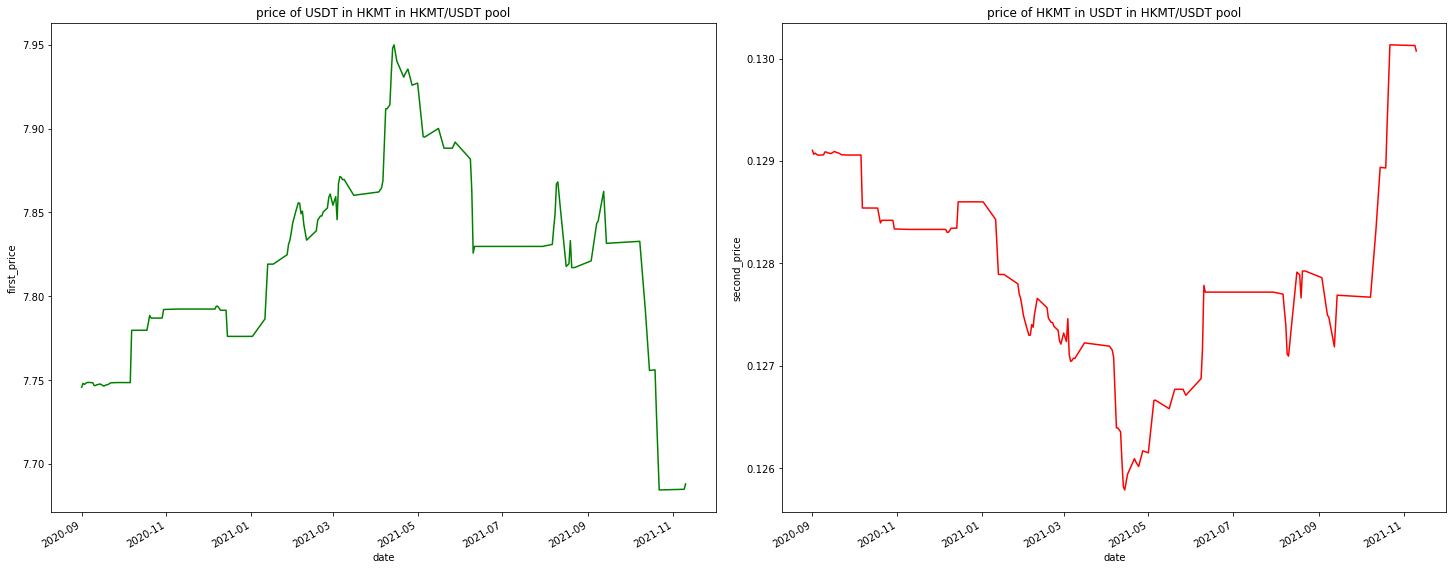

In [99]:
show_pool_price_evolution_from_reserves(hkmt_usdt_reserves_df, first_token_price_name="price of USDT in HKMT in HKMT/USDT pool", 
                                        second_token_price_name="price of HKMT in USDT in HKMT/USDT pool", x=25, y=10, wspace=0.1)

In [75]:
hkmt_usdt_reserves_df

reserve0      reserve1    reserveUSD  dailyVolumeToken0  \
0    2.324374e+08  3.000841e+07  5.962596e+07       8.411800e+05   
1    2.324720e+08  3.000396e+07  5.998884e+07       3.968598e+04   
2    2.324620e+08  3.000526e+07  5.980636e+07       1.213620e+04   
3    2.324728e+08  3.000387e+07  5.974688e+07       1.126615e+04   
4    2.324795e+08  3.000300e+07  5.981387e+07       7.698807e+03   
..            ...           ...           ...                ...   
149  3.876795e+08  4.998382e+07  9.987336e+07       1.000000e+04   
150  3.870407e+08  5.006692e+07  1.001026e+08       1.566792e+06   
151  3.858882e+08  5.021690e+07  1.003717e+08       1.152465e+06   
152  3.858982e+08  5.021560e+07  1.002498e+08       1.000000e+04   
153  3.859776e+08  5.020530e+07  1.007392e+08       7.940000e+04   

     dailyVolumeToken1       date  first_price  second_price  \
0        108718.139712 2020-09-01     7.745741      0.129103   
1          5109.376059 2020-09-02     7.748043      0.129065   
2          1570.298902 2020-09-03     7.747375      0.129076   
3          1449.936710 2020-09-04     7.748094      0.129064   
4           990.995574 2020-09-05     7.748544      0.129057   
..                 ...        ...          ...           ...   
149        1285.473001 2021-10-19     7.756100      0.128931   
150      202352.471319 2021-10-20     7.730467      0.129358   
151      149976.000000 2021-10-22     7.684430      0.130133   
152        1297.395174 2021-11-09     7.684828      0.130127   
153       10298.938052 2021-11-10     7.687986      0.130073   

     first_price_increase_rate  second_price_increase_rate  
0                    -0.029711                    0.029720  
1                     0.008619                   -0.008619  
2                    -0.009279                    0.009279  
3                    -0.005809                    0.005809  
4                    -0.000353                    0.000353  
..                         ...                         ...  
149                   0.331581                   -0.330485  
150                   0.599098                   -0.595530  
151                  -0.005175                    0.005175  
152                  -0.041076                    0.041093  
153                        NaN                         NaN  

[154 rows x 10 columns]

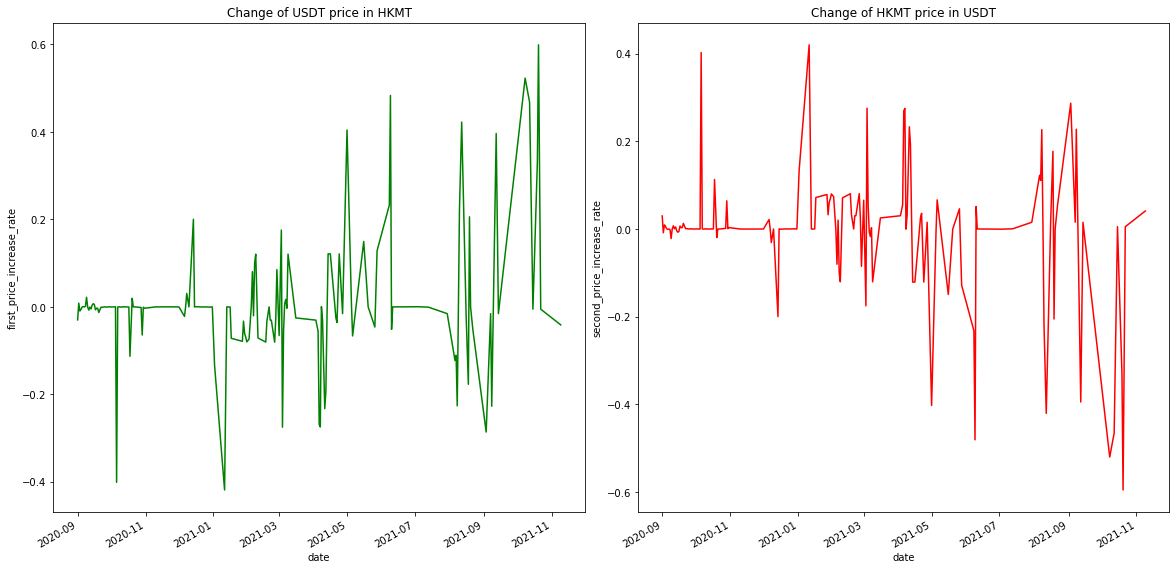

In [76]:
calc_price_and_increase_rates(hkmt_usdt_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=hkmt_usdt_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of USDT price in HKMT')
plt.subplot(1, 2, 2)
sns.lineplot(data=hkmt_usdt_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of HKMT price in USDT')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

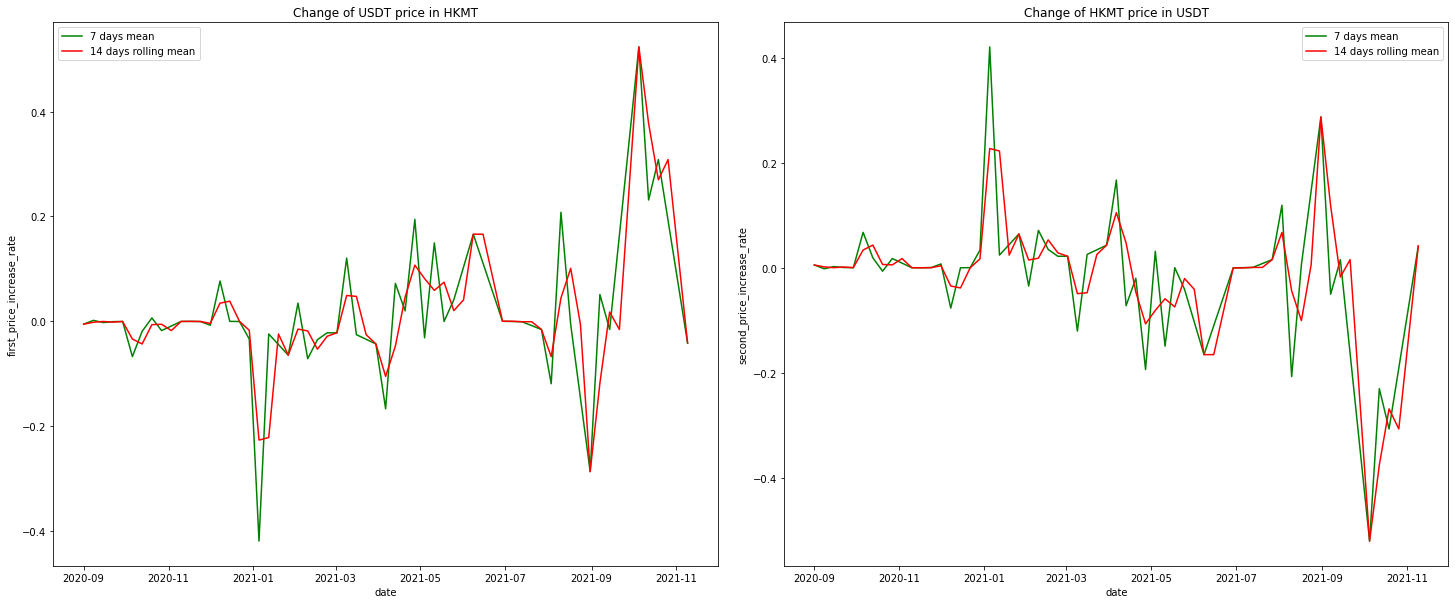

In [77]:
increase_rate_moving_averages(hkmt_usdt_reserves_df, 'Change of USDT price in HKMT', 'Change of HKMT price in USDT', x_size=25, y_size=10)

## FEI/ETH

In [78]:
fei_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\fei_weth_swaps.pkl')
fei_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\fei_weth_mints.pkl")
fei_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\fei_weth_burns.pkl")
fei_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\fei_weth_reserves.pkl")

### Plotting swapping in moving averages

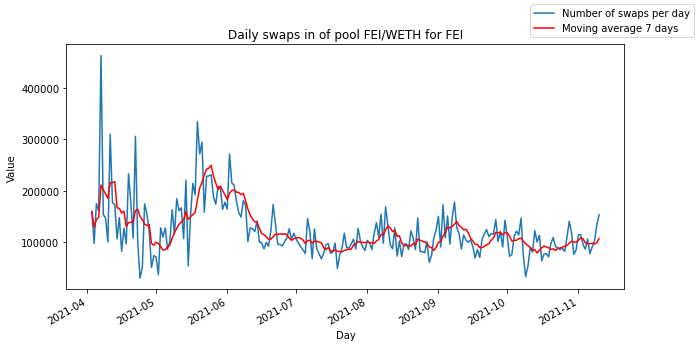

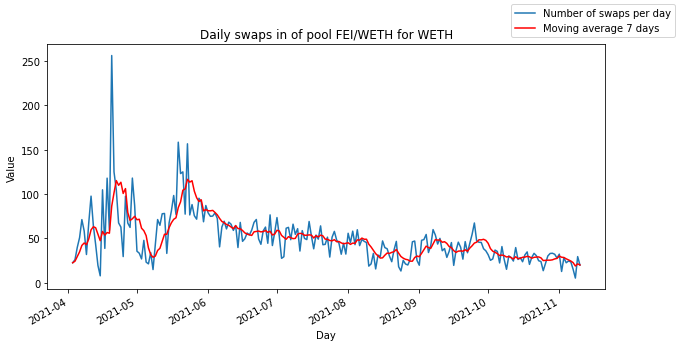

In [37]:
show_swaps_amount_in_moving_averages(swaps_df=fei_weth_df[(fei_weth_df.token_in == 'FEI')], pool_name="FEI/WETH for FEI")
show_swaps_amount_in_moving_averages(swaps_df=fei_weth_df[(fei_weth_df.token_in == 'WETH')], pool_name="FEI/WETH for WETH")

### Swaps values histograms

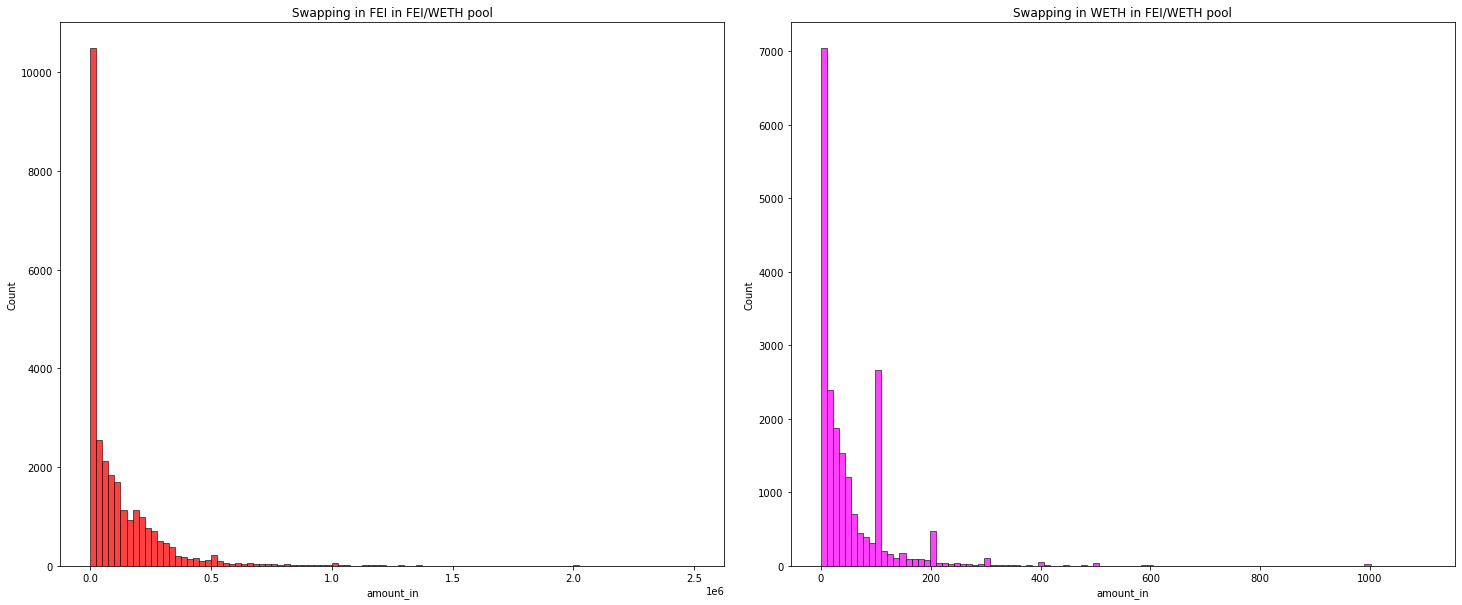

In [138]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=fei_weth_df[fei_weth_df.token_in == 'FEI'], x='amount_in', bins=100, color='red', binrange=[0, 2500000]).set_title("Swapping in FEI in FEI/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=fei_weth_df[fei_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta', binrange=[0, 1100]).set_title("Swapping in WETH in FEI/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

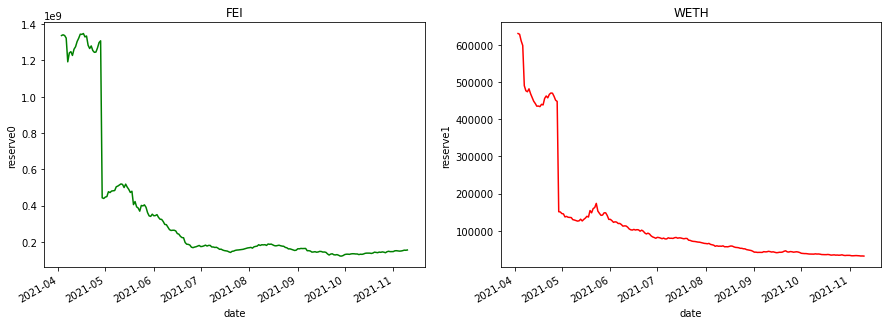

In [36]:
show_swaps_reserves_evolution_through_time(fei_weth_reserves_df, first_token_reserve_name="FEI", second_token_reserve_name="WETH", x=15)

### Plotting pool price

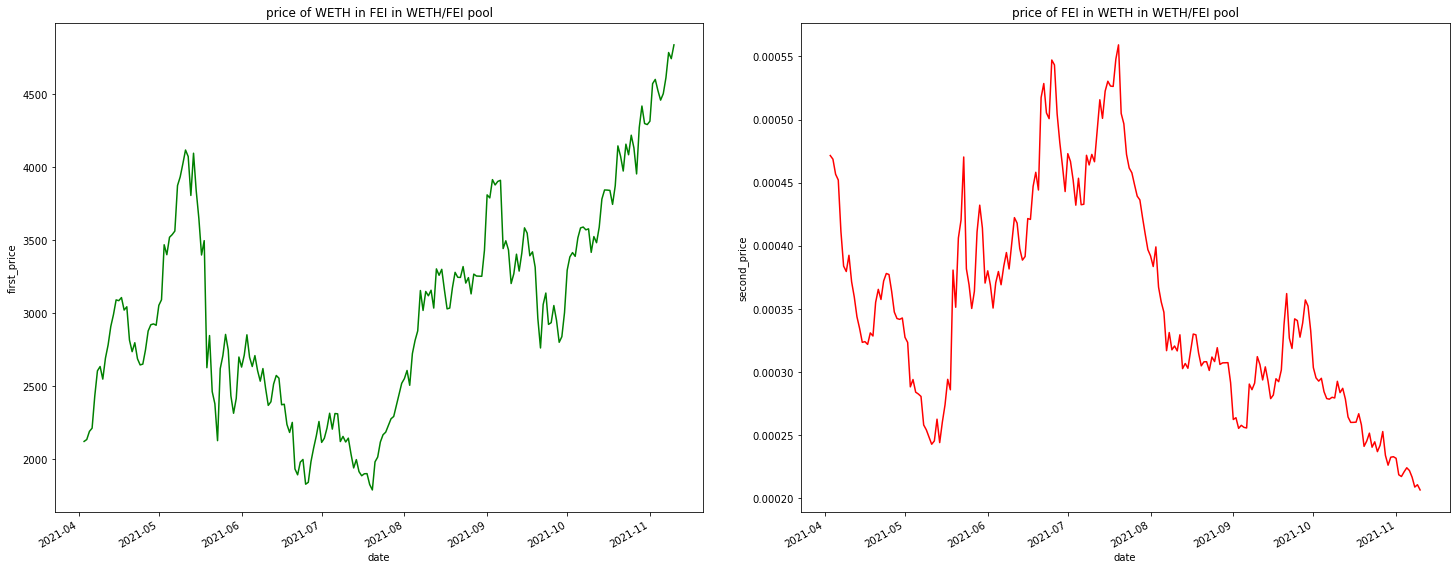

In [98]:
show_pool_price_evolution_from_reserves(fei_weth_reserves_df, first_token_price_name="price of WETH in FEI in WETH/FEI pool", 
                                        second_token_price_name="price of FEI in WETH in WETH/FEI pool", x=25, y=10, wspace=0.15)

In [80]:
fei_weth_reserves_df

reserve0       reserve1    reserveUSD  dailyVolumeToken0  \
0    1.337230e+09  630522.677036  2.537871e+09       5.830436e+07   
1    1.341220e+09  628533.678068  2.604474e+09       6.647175e+07   
2    1.337334e+09  610770.369281  2.561514e+09       8.717716e+07   
3    1.323221e+09  598300.386209  2.531489e+09       5.256349e+07   
4    1.192320e+09  490330.663557  1.925378e+09       2.657121e+08   
..            ...            ...           ...                ...   
217  1.501845e+08   33358.812751  3.008810e+08       9.439718e+06   
218  1.520115e+08   32961.427400  3.038065e+08       5.412572e+06   
219  1.548270e+08   32363.289968  3.102908e+08       3.921755e+06   
220  1.541618e+08   32510.246132  3.081654e+08       1.157095e+07   
221  1.557041e+08   32193.004358  3.117742e+08       7.627141e+06   

     dailyVolumeToken1       date  first_price  second_price  \
0         27452.763852 2021-04-03  2120.828163      0.000472   
1         31306.853434 2021-04-04  2133.886561      0.000469   
2         40829.752667 2021-04-05  2189.585332      0.000457   
3         24003.259833 2021-04-06  2211.633163      0.000452   
4        122248.657720 2021-04-07  2431.665205      0.000411   
..                 ...        ...          ...           ...   
217        2129.006495 2021-11-06  4502.093383      0.000222   
218        1185.020670 2021-11-07  4611.798435      0.000217   
219         831.158745 2021-11-08  4784.031407      0.000209   
220        2429.260301 2021-11-09  4741.945001      0.000211   
221        1614.479078 2021-11-10  4836.582464      0.000207   

     first_price_increase_rate  second_price_increase_rate  
0                    -0.611954                    0.615722  
1                    -2.543805                    2.610203  
2                    -0.996903                    1.006941  
3                    -9.048616                    9.948849  
4                    -6.626643                    7.096931  
..                         ...                         ...  
217                  -2.378791                    2.436756  
218                  -3.600164                    3.734616  
219                   0.887535                   -0.879727  
220                  -1.956701                    1.995752  
221                        NaN                         NaN  

[222 rows x 10 columns]

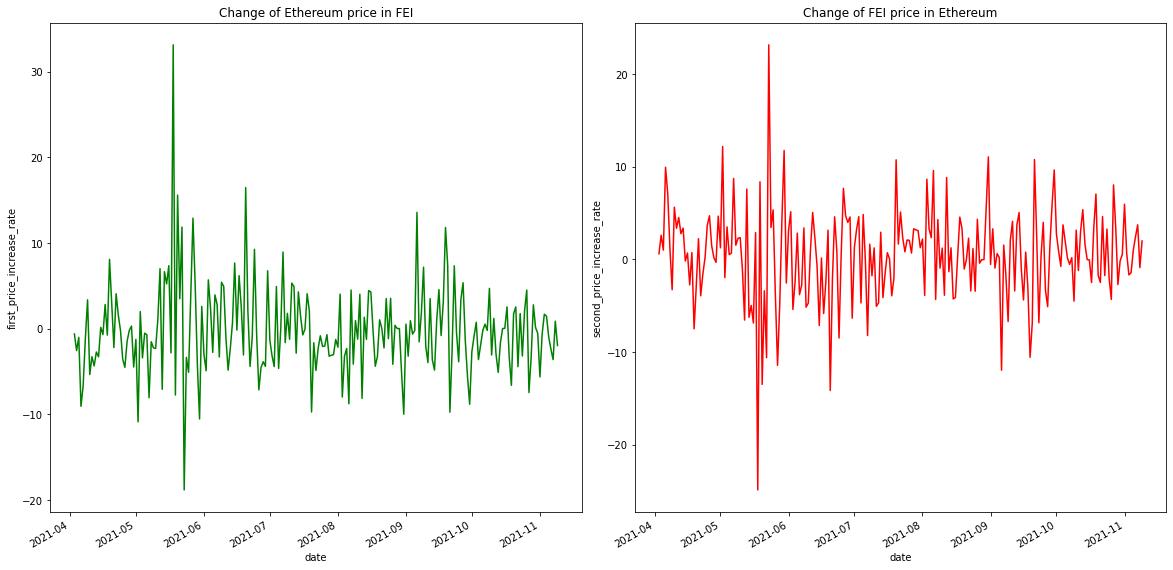

In [81]:
calc_price_and_increase_rates(fei_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=fei_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in FEI')
plt.subplot(1, 2, 2)
sns.lineplot(data=fei_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of FEI price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

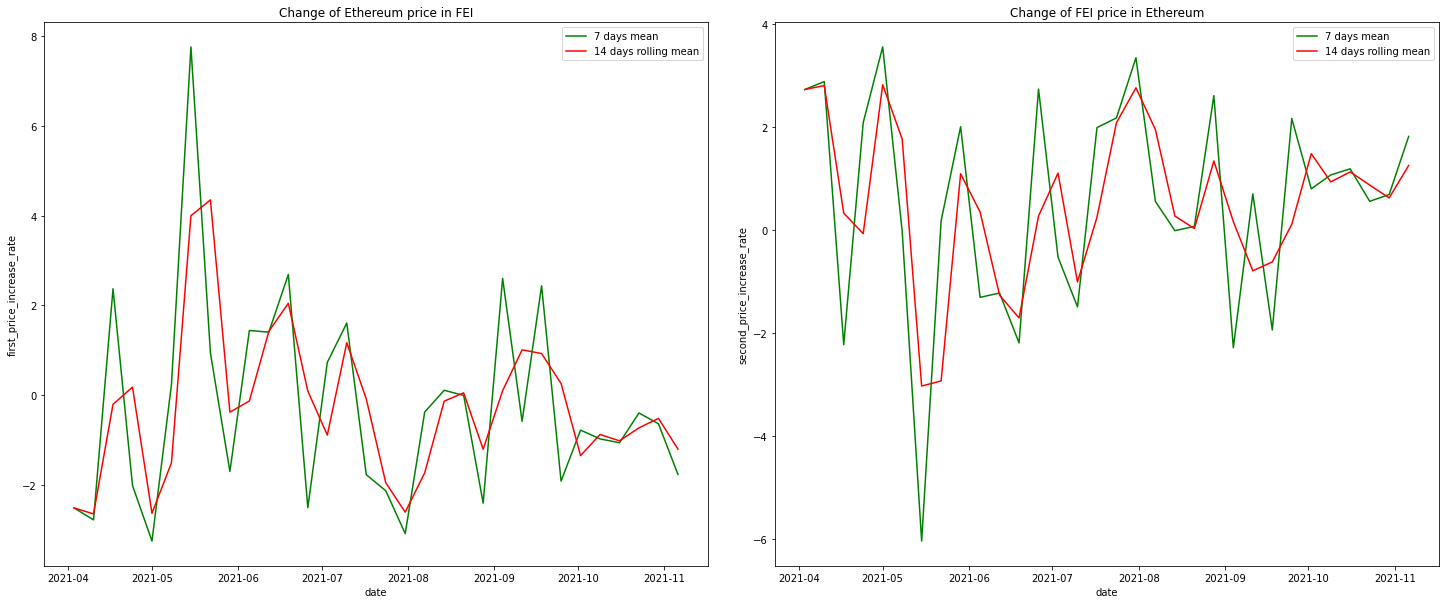

In [82]:
increase_rate_moving_averages(fei_weth_reserves_df, 'Change of Ethereum price in FEI', 'Change of FEI price in Ethereum', x_size=25, y_size=10)

## AXS/ETH

In [84]:
axs_weth_v2_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\axs_weth_v2_swaps.pkl')
axs_weth_v2_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\axs_weth_v2_mints.pkl")
axs_weth_v2_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\axs_weth_v2_burns.pkl")
axs_weth_v2_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\axs_weth_v2_reserves.pkl")

### Plotting swapping in moving averages

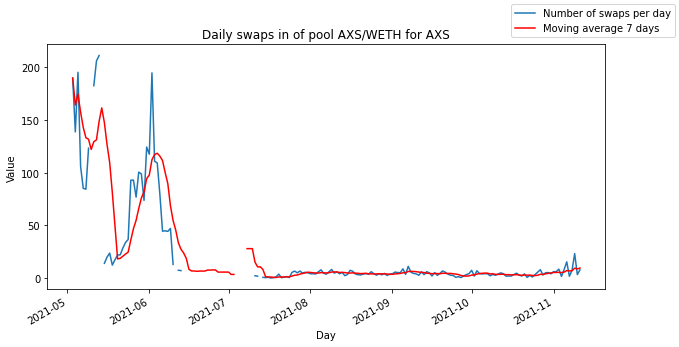

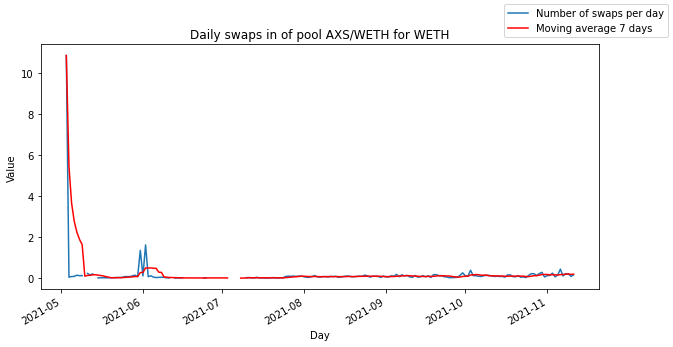

In [38]:
show_swaps_amount_in_moving_averages(swaps_df=axs_weth_v2_df[(axs_weth_v2_df.token_in == 'AXS')], pool_name="AXS/WETH for AXS")
show_swaps_amount_in_moving_averages(swaps_df=axs_weth_v2_df[(axs_weth_v2_df.token_in == 'WETH')], pool_name="AXS/WETH for WETH")

### Swaps values histograms

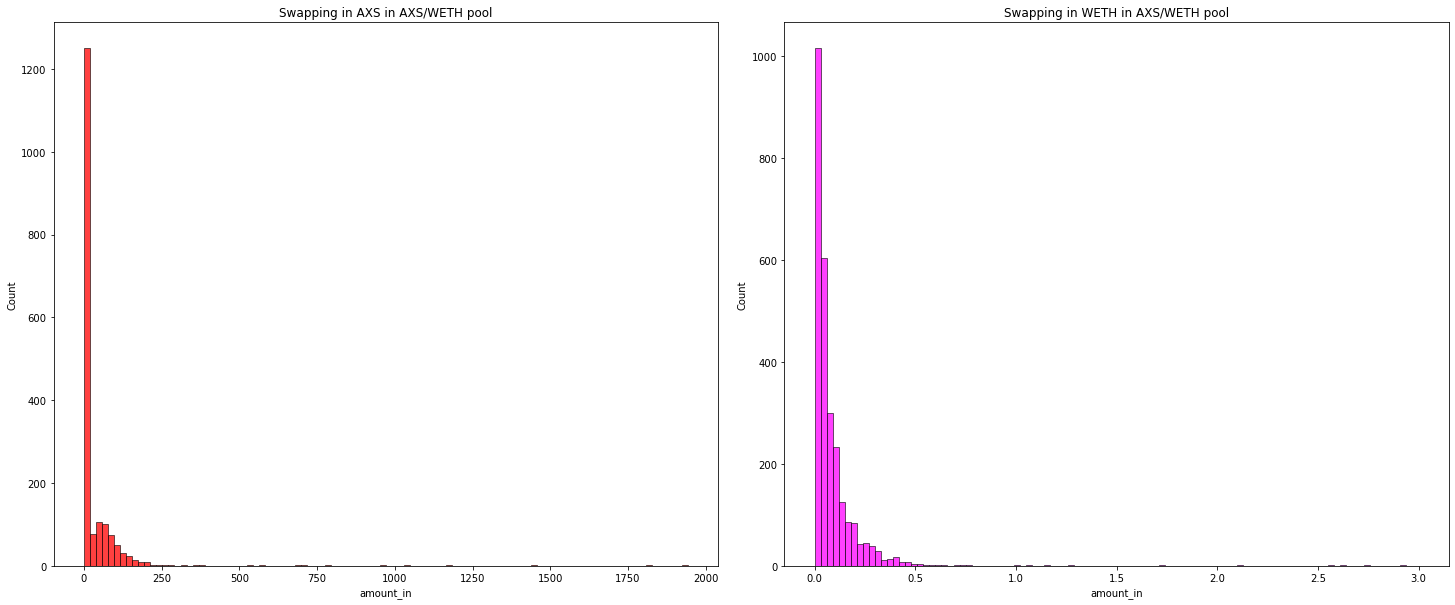

In [143]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=axs_weth_v2_df[axs_weth_v2_df.token_in == 'AXS'], x='amount_in', bins=100, color='red').set_title("Swapping in AXS in AXS/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=axs_weth_v2_df[axs_weth_v2_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta', binrange=[0, 3]).set_title("Swapping in WETH in AXS/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

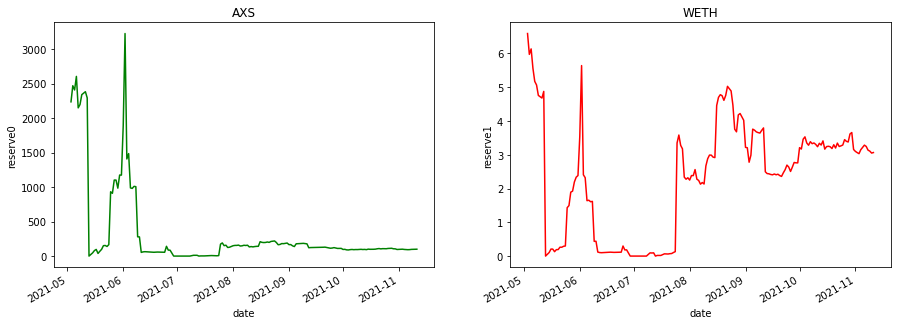

In [40]:
show_swaps_reserves_evolution_through_time(axs_weth_v2_reserves_df, first_token_reserve_name="AXS", second_token_reserve_name="WETH", x=15)

### Plotting pool price

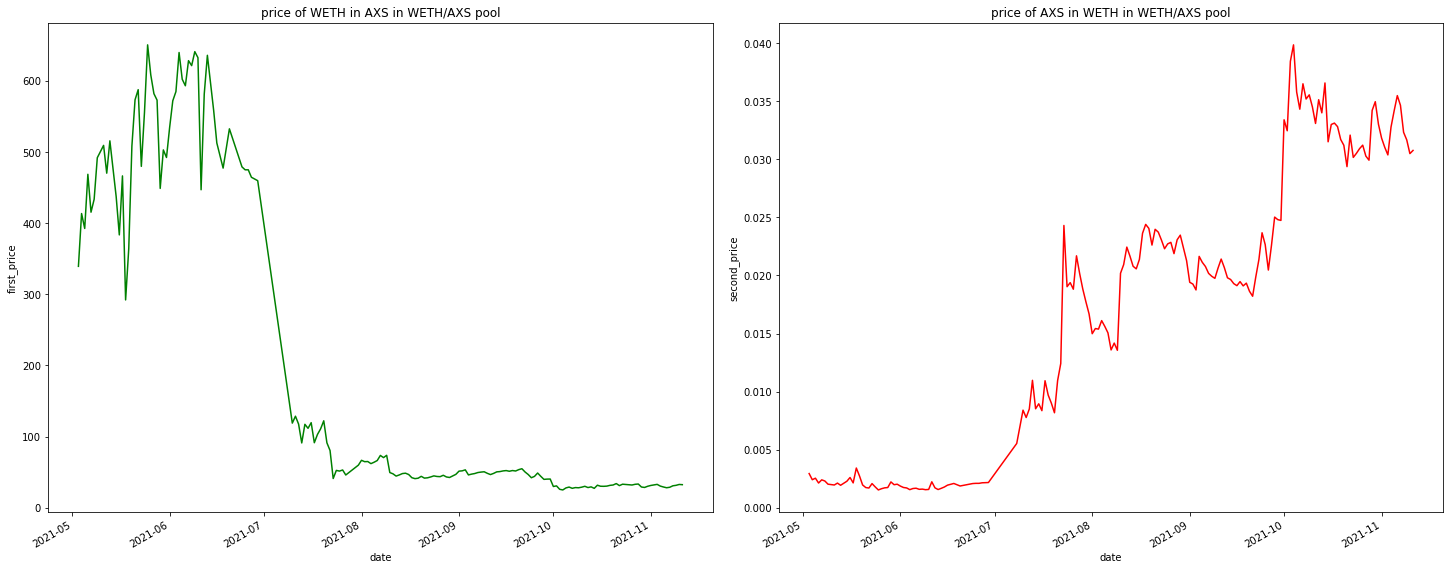

In [96]:
show_pool_price_evolution_from_reserves(axs_weth_v2_reserves_df, first_token_price_name="price of WETH in AXS in WETH/AXS pool", 
                                        second_token_price_name="price of AXS in WETH in WETH/AXS pool", x=25, y=10, wspace=0.1)

In [86]:
axs_weth_v2_reserves_df

reserve0  reserve1    reserveUSD  dailyVolumeToken0  \
0    2235.318021  6.589013  43248.099360        5631.549029   
1    2468.971504  5.971757  39933.495620         876.346517   
2    2407.284859  6.133823  42093.892594        1233.886645   
3    2603.981326  5.557229  38883.103492        1681.480184   
4    2148.038360  5.171886  35978.200367        2004.968493   
..           ...       ...           ...                ...   
171    93.720378  3.246412  29904.748186          13.319140   
172    97.091996  3.137604  29966.847564          41.115158   
173    98.147476  3.107572  29688.149794          45.542305   
174   100.055361  3.049939  28068.271846          18.431023   
175    99.650433  3.065086  28675.260503          32.031447   

     dailyVolumeToken1       date  first_price  second_price  \
0           412.261553 2021-05-03   339.249298      0.002948   
1             2.191252 2021-05-04   413.441392      0.002419   
2             3.094878 2021-05-05   392.460751      0.002548   
3             4.037121 2021-05-06   468.575505      0.002134   
4             4.749660 2021-05-07   415.329783      0.002408   
..                 ...        ...          ...           ...   
171           0.446260 2021-11-07    28.868914      0.034639   
172           1.406405 2021-11-08    30.944630      0.032316   
173           1.272922 2021-11-09    31.583335      0.031662   
174           0.554382 2021-11-10    32.805691      0.030483   
175           0.918619 2021-11-11    32.511469      0.030758   

     first_price_increase_rate  second_price_increase_rate  
0                   -17.945009                   21.869491  
1                     5.345921                   -5.074635  
2                   -16.243861                   19.394233  
3                    12.820107                  -11.363317  
4                    -4.190249                    4.373510  
..                         ...                         ...  
171                  -6.707836                    7.190139  
172                  -2.022286                    2.064027  
173                  -3.726050                    3.870258  
174                   0.904981                   -0.896865  
175                        NaN                         NaN  

[176 rows x 10 columns]

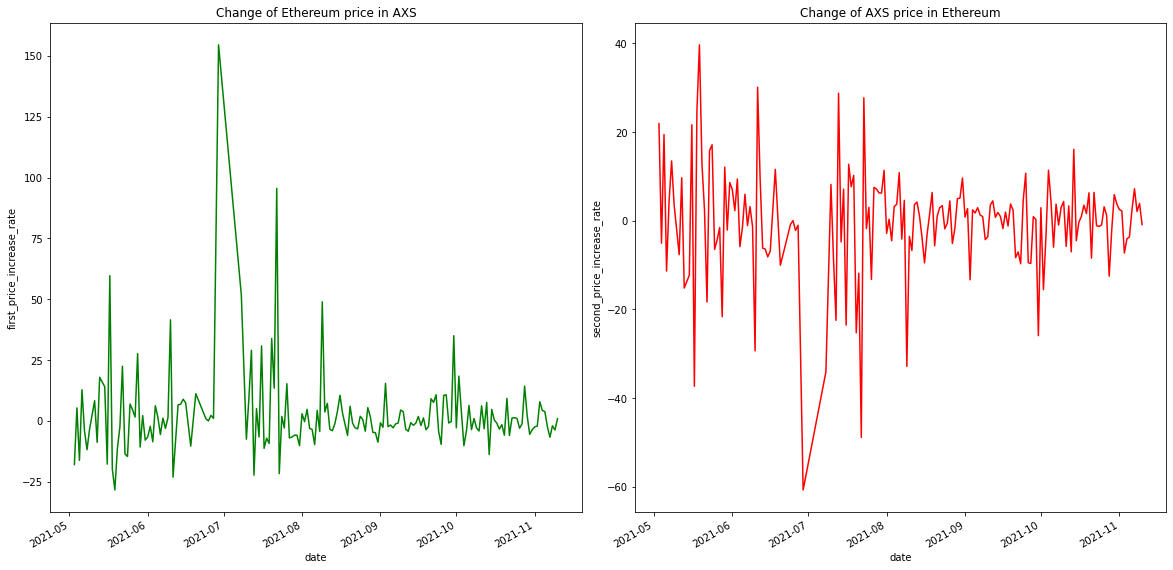

In [87]:
calc_price_and_increase_rates(axs_weth_v2_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=axs_weth_v2_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in AXS')
plt.subplot(1, 2, 2)
sns.lineplot(data=axs_weth_v2_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of AXS price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

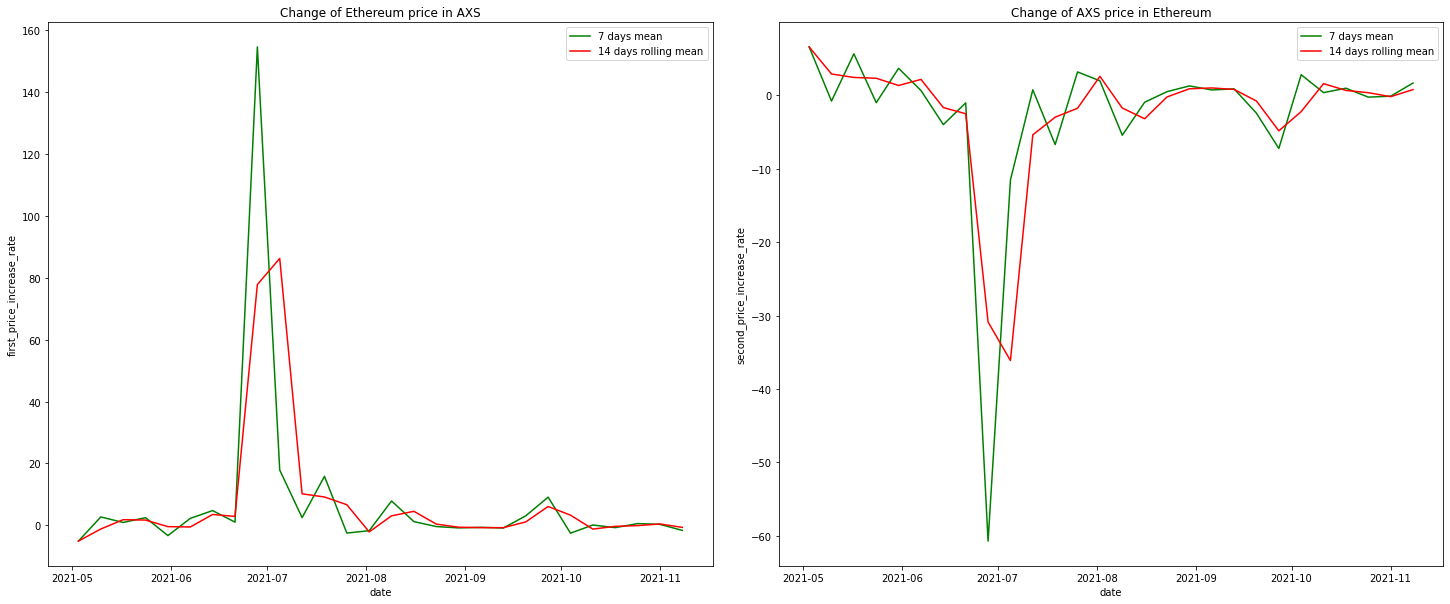

In [88]:
increase_rate_moving_averages(axs_weth_v2_reserves_df, 'Change of Ethereum price in AXS', 'Change of AXS price in Ethereum', x_size=25, y_size=10)

## MANA/ETH

In [89]:
mana_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\mana_weth_swaps.pkl')
mana_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\mana_weth_mints.pkl")
mana_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\mana_weth_burns.pkl")
mana_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\mana_weth_reserves.pkl")

### Plotting swapping in moving averages

In [169]:
sand_weth_df

token_in token_out     amount_in   amount_out    amount_usd  \
0          WETH      SAND      0.017650   126.469664      3.647599   
1          WETH      SAND      0.400000  2413.756323    178.145088   
2          WETH      SAND      0.476309  2155.508531    212.249884   
3          WETH      SAND      0.031877   123.596424     13.288490   
4          WETH      SAND      0.008500    32.612732      3.539984   
...         ...       ...           ...          ...           ...   
128512     WETH      SAND      0.630000  1257.292744   2981.313401   
128513     WETH      SAND      0.100000   199.535403    473.188066   
128514     WETH      SAND      2.348163  4682.679239  11098.850877   
128515     SAND      WETH  11649.064883     5.801709  27303.030454   
128516     WETH      SAND      0.099000   197.858946    465.900994   

                 timestamp  
0      2020-08-20 15:46:06  
1      2020-08-20 15:56:12  
2      2020-08-20 15:57:40  
3      2020-08-20 16:02:32  
4      2020-08-20 16:20:56  
...                    ...  
128512 2021-11-11 10:18:42  
128513 2021-11-11 10:20:12  
128514 2021-11-11 10:26:28  
128515 2021-11-11 10:40:19  
128516 2021-11-11 10:42:30  

[128517 rows x 6 columns]

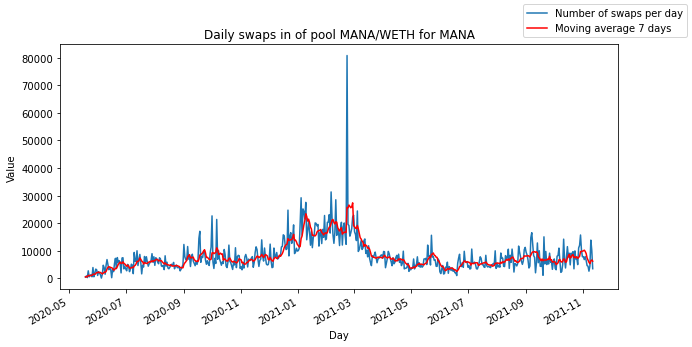

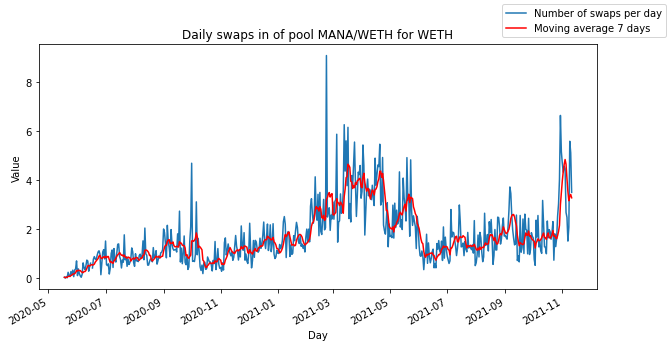

In [39]:
show_swaps_amount_in_moving_averages(swaps_df=mana_weth_df[(mana_weth_df.token_in == 'MANA')], pool_name="MANA/WETH for MANA")
show_swaps_amount_in_moving_averages(swaps_df=mana_weth_df[(mana_weth_df.token_in == 'WETH')], pool_name="MANA/WETH for WETH")

### Swaps values histograms

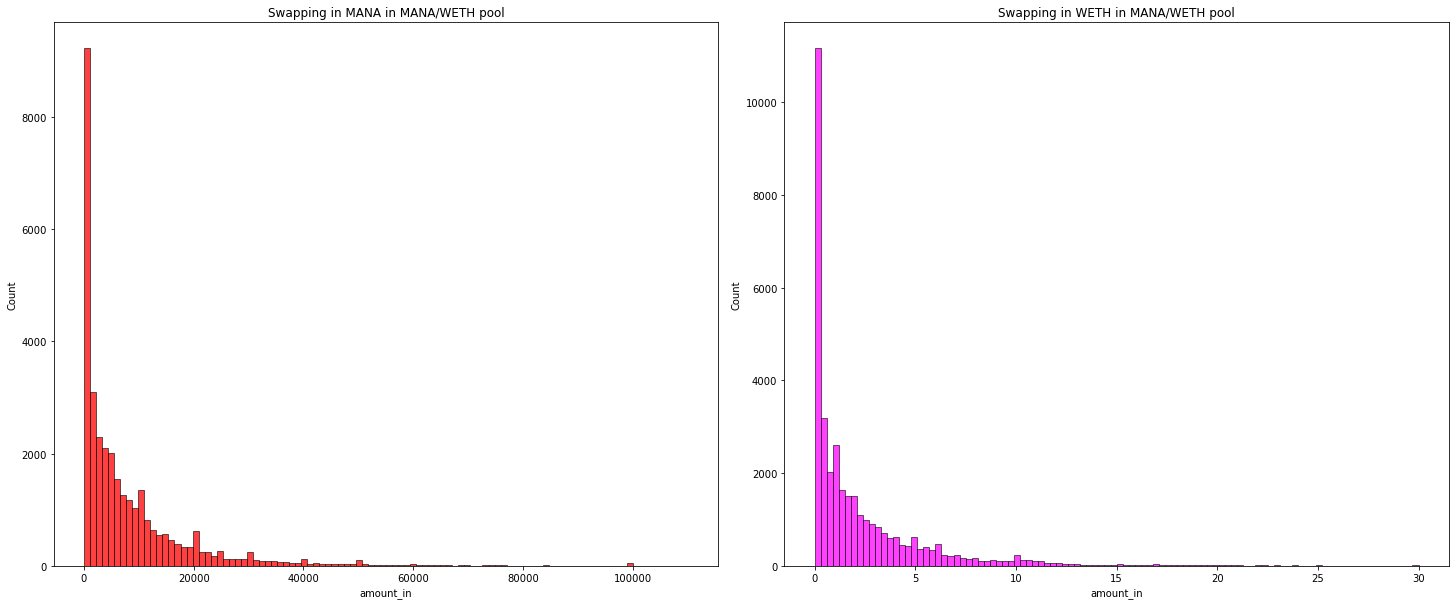

In [148]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=mana_weth_df[mana_weth_df.token_in == 'MANA'], x='amount_in', bins=100, color='red', binrange=[0, 110000]).set_title("Swapping in MANA in MANA/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=mana_weth_df[mana_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta', binrange=[0, 30]).set_title("Swapping in WETH in MANA/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

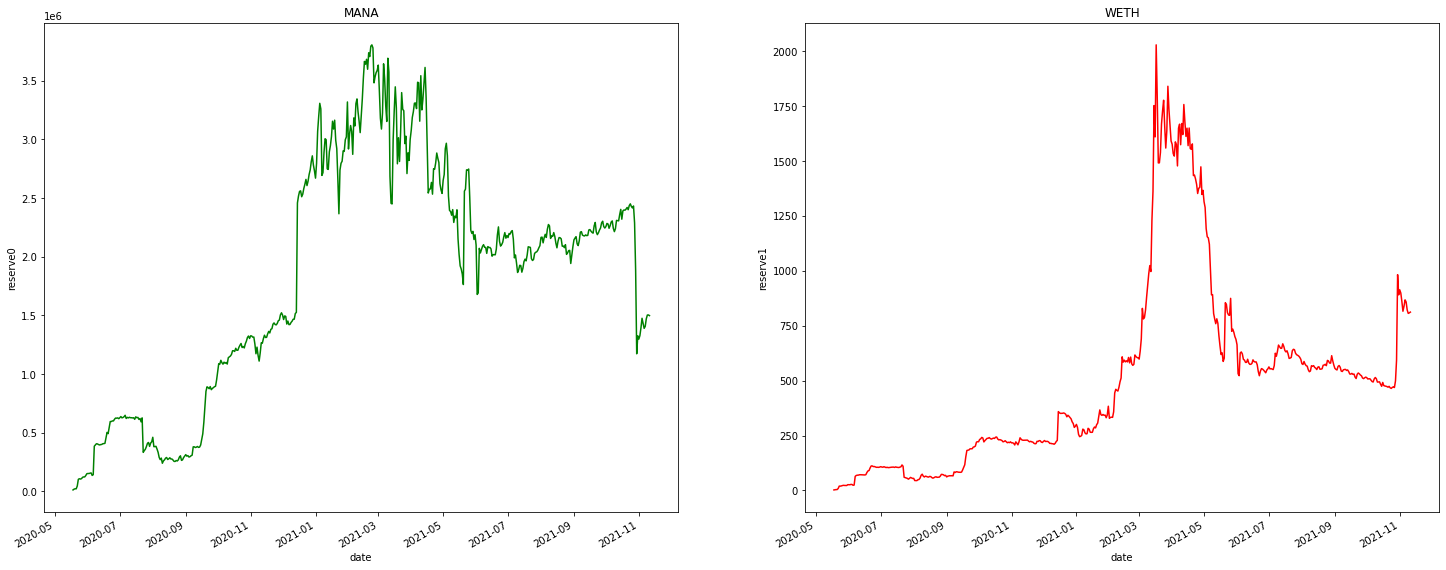

In [95]:
show_swaps_reserves_evolution_through_time(mana_weth_reserves_df, first_token_reserve_name="MANA", second_token_reserve_name="WETH", x=25, y=10)

### Plotting pool price

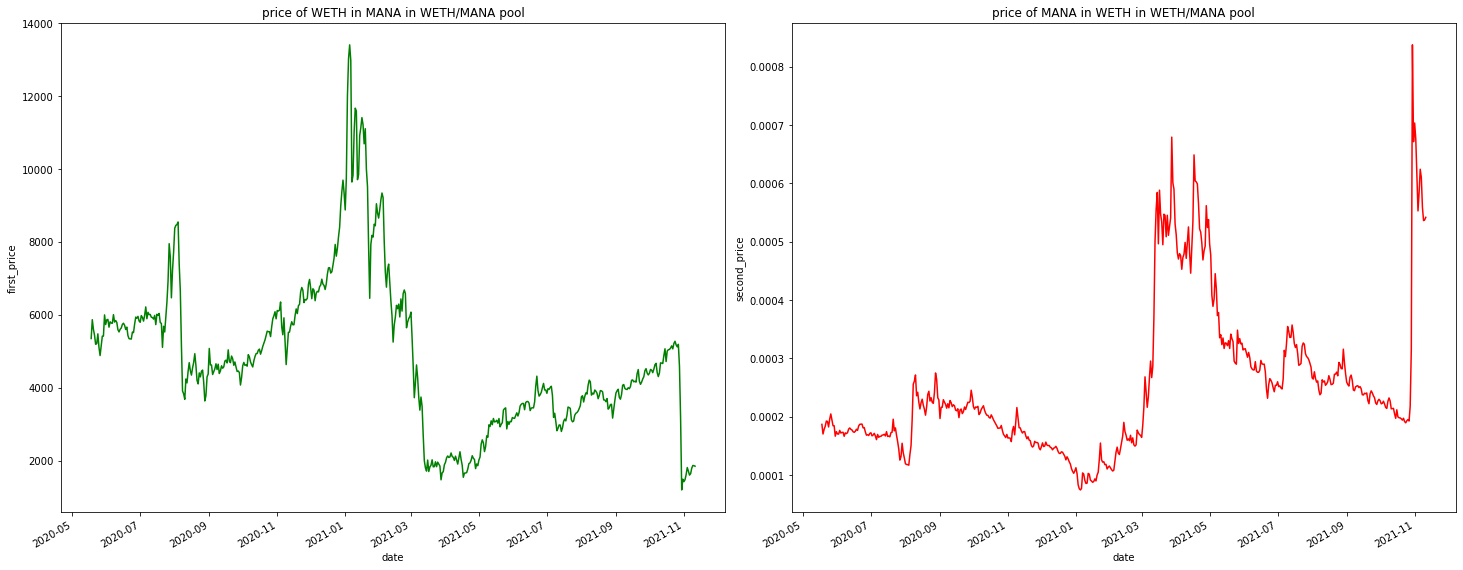

In [94]:
show_pool_price_evolution_from_reserves(mana_weth_reserves_df, first_token_price_name="price of WETH in MANA in WETH/MANA pool", 
                                        second_token_price_name="price of MANA in WETH in WETH/MANA pool", x=25, y=10, wspace=0.1)

In [91]:
mana_weth_reserves_df

reserve0    reserve1    reserveUSD  dailyVolumeToken0  \
0    1.313154e+04    2.455654  5.260017e+02       2.759552e+02   
1    1.995563e+04    3.402474  1.456969e+03       1.545187e+03   
2    2.320825e+04    4.142890  1.747858e+03       5.835603e+03   
3    2.287628e+04    4.203910  1.674104e+03       1.630945e+03   
4    4.713547e+04    9.083270  3.766017e+03       1.150966e+04   
..            ...         ...           ...                ...   
538  1.406560e+06  858.125110  7.901340e+06       3.750751e+05   
539  1.470613e+06  821.824572  7.896708e+06       6.330063e+05   
540  1.503168e+06  806.132295  7.645894e+06       1.358138e+06   
541  1.503989e+06  808.678993  7.479941e+06       1.843973e+06   
542  1.498493e+06  812.069738  7.688472e+06       2.606286e+05   

     dailyVolumeToken1       date  first_price  second_price  \
0             0.050000 2020-05-18  5347.470266      0.000187   
1             0.268593 2020-05-19  5865.036543      0.000171   
2             0.971594 2020-05-20  5601.946650      0.000179   
3             0.304859 2020-05-21  5441.667354      0.000184   
4             2.419877 2020-05-22  5189.261607      0.000193   
..                 ...        ...          ...           ...   
538         231.599542 2021-11-07  1639.108120      0.000610   
539         365.717445 2021-11-08  1789.449269      0.000559   
540         718.900592 2021-11-09  1864.666040      0.000536   
541        1008.822995 2021-11-10  1859.809332      0.000538   
542         143.660143 2021-11-11  1845.276445      0.000542   

     first_price_increase_rate  second_price_increase_rate  
0                    -8.824604                    9.678713  
1                     4.696401                   -4.485733  
2                     2.945408                   -2.861136  
3                     4.864001                   -4.638390  
4                    -0.364112                    0.365443  
..                         ...                         ...  
538                  -8.401532                    9.172131  
539                  -4.033793                    4.203347  
540                   0.261140                   -0.260460  
541                   0.787572                   -0.781418  
542                        NaN                         NaN  

[543 rows x 10 columns]

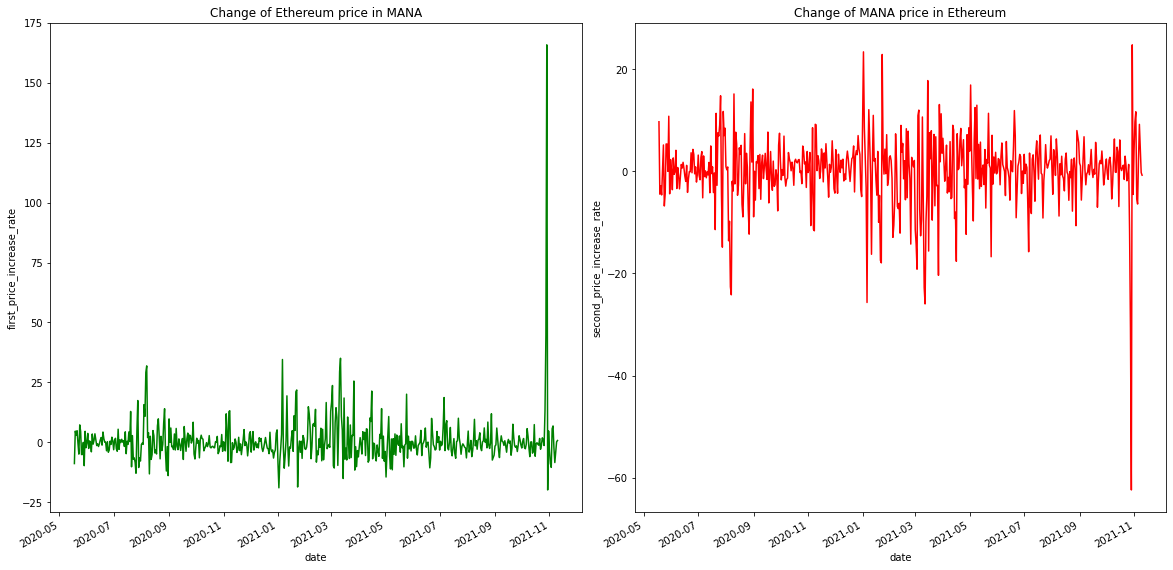

In [92]:
calc_price_and_increase_rates(mana_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=mana_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in MANA')
plt.subplot(1, 2, 2)
sns.lineplot(data=mana_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of MANA price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

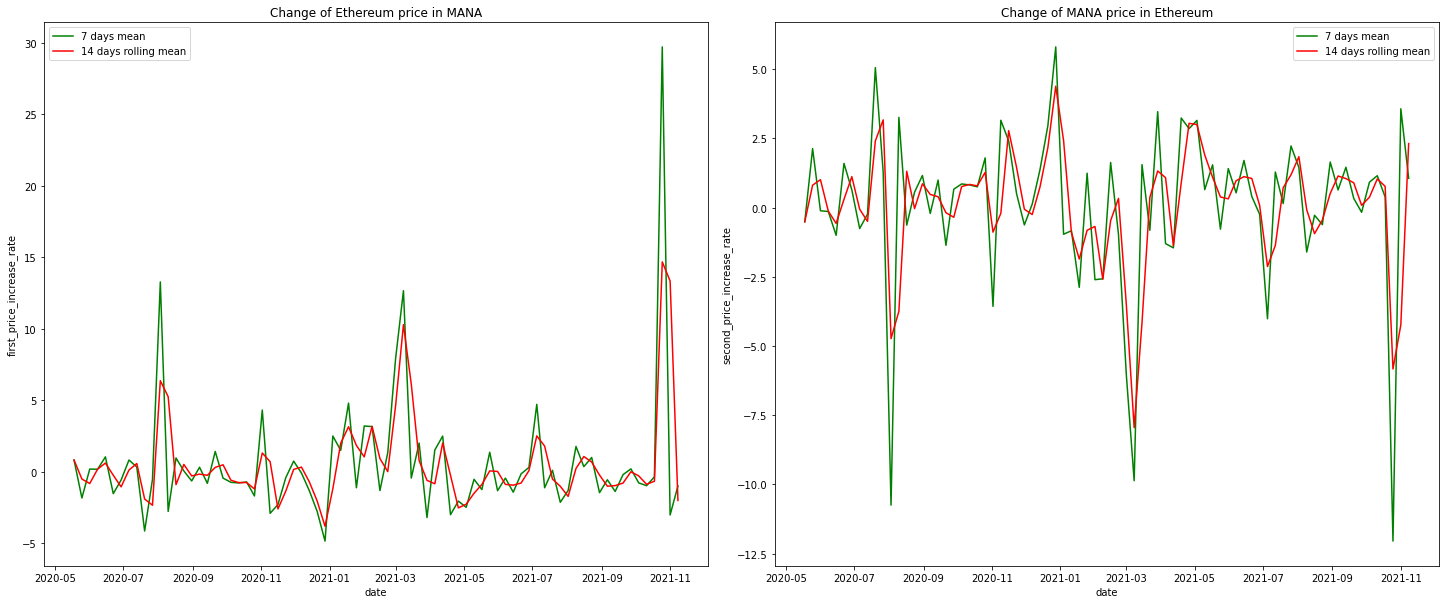

In [93]:
increase_rate_moving_averages(mana_weth_reserves_df, 'Change of Ethereum price in MANA', 'Change of MANA price in Ethereum', x_size=25, y_size=10)

## ENJ/ETH

In [94]:
enj_eth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\enj_eth_swaps.pkl')
enj_eth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\enj_eth_mints.pkl")
enj_eth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\enj_eth_burns.pkl")
enj_eth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\enj_eth_reserves.pkl")

### Plotting swapping in moving averages

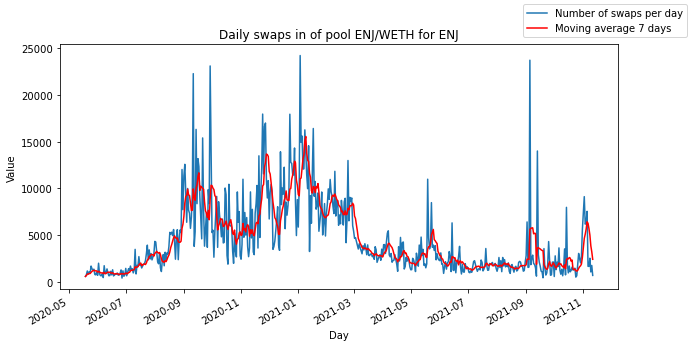

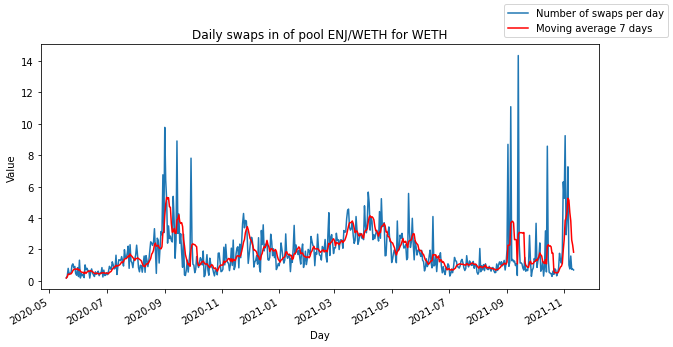

In [40]:
show_swaps_amount_in_moving_averages(swaps_df=enj_eth_df[(enj_eth_df.token_in == 'ENJ')], pool_name="ENJ/WETH for ENJ")
show_swaps_amount_in_moving_averages(swaps_df=enj_eth_df[(enj_eth_df.token_in == 'WETH')], pool_name="ENJ/WETH for WETH")

### Swaps values histograms

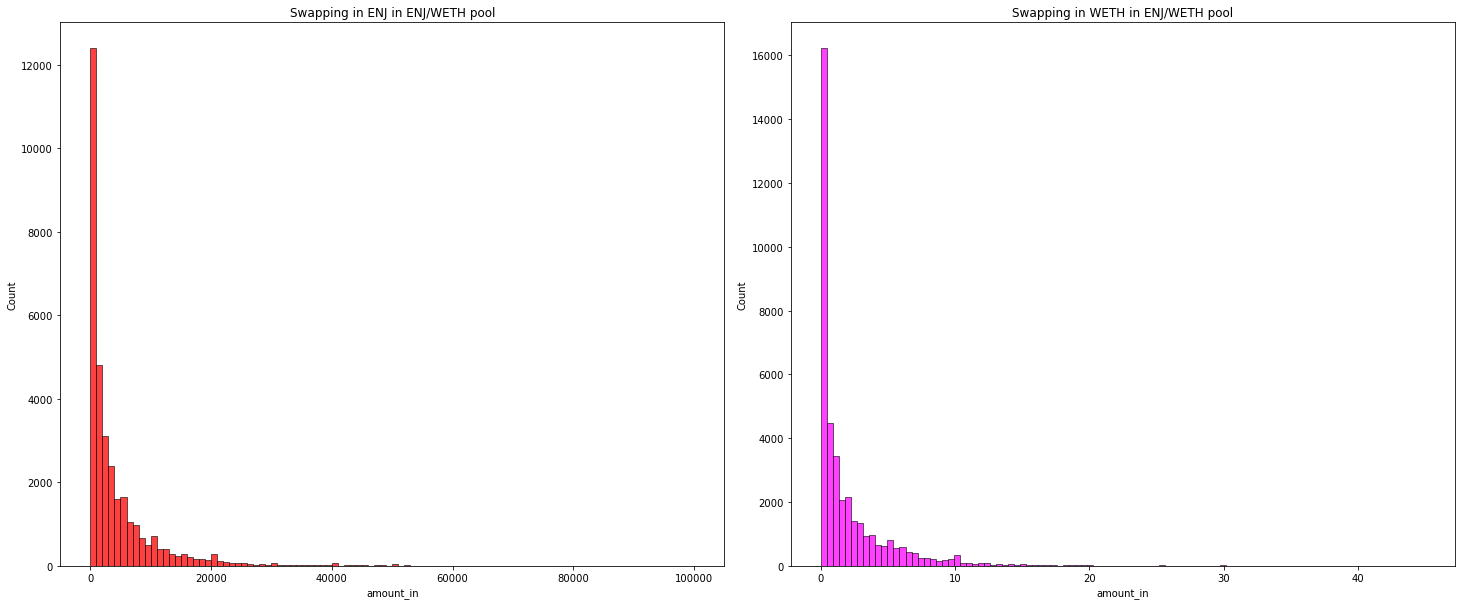

In [151]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=enj_eth_df[enj_eth_df.token_in == 'ENJ'], x='amount_in', bins=100, color='red', binrange=[0, 100000]).set_title("Swapping in ENJ in ENJ/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=enj_eth_df[enj_eth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta', binrange=[0, 45]).set_title("Swapping in WETH in ENJ/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

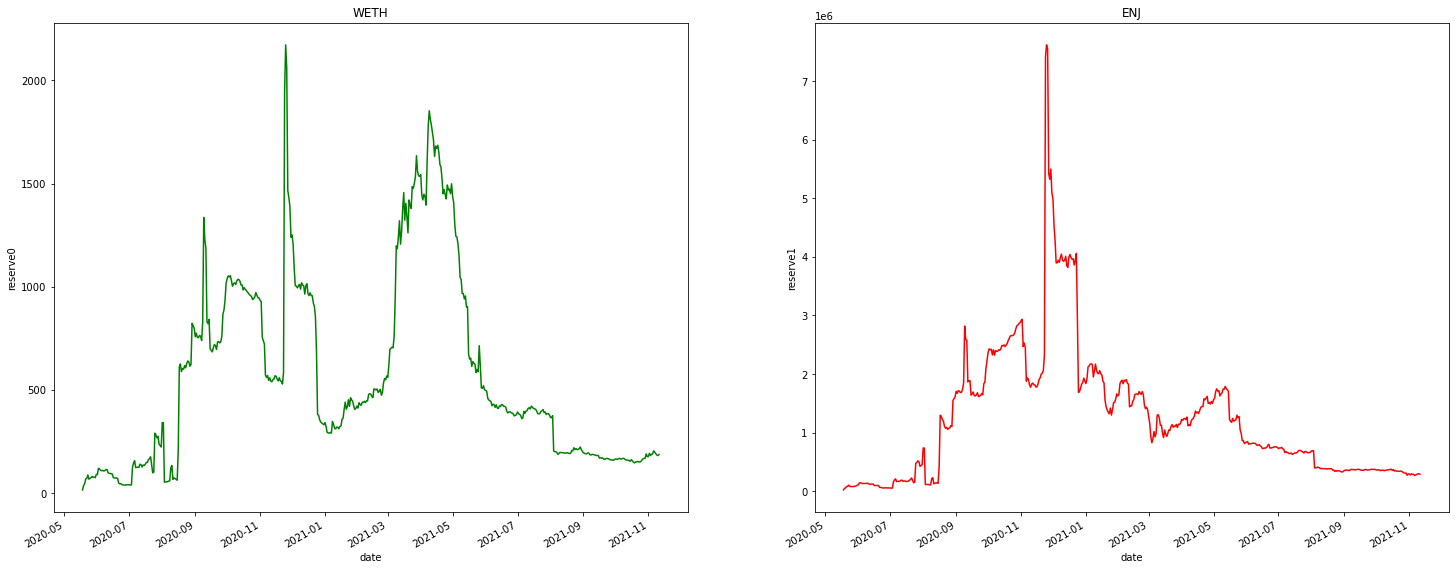

In [93]:
show_swaps_reserves_evolution_through_time(enj_eth_reserves_df, first_token_reserve_name="WETH", second_token_reserve_name="ENJ", x=25, y=10)

### Plotting pool price

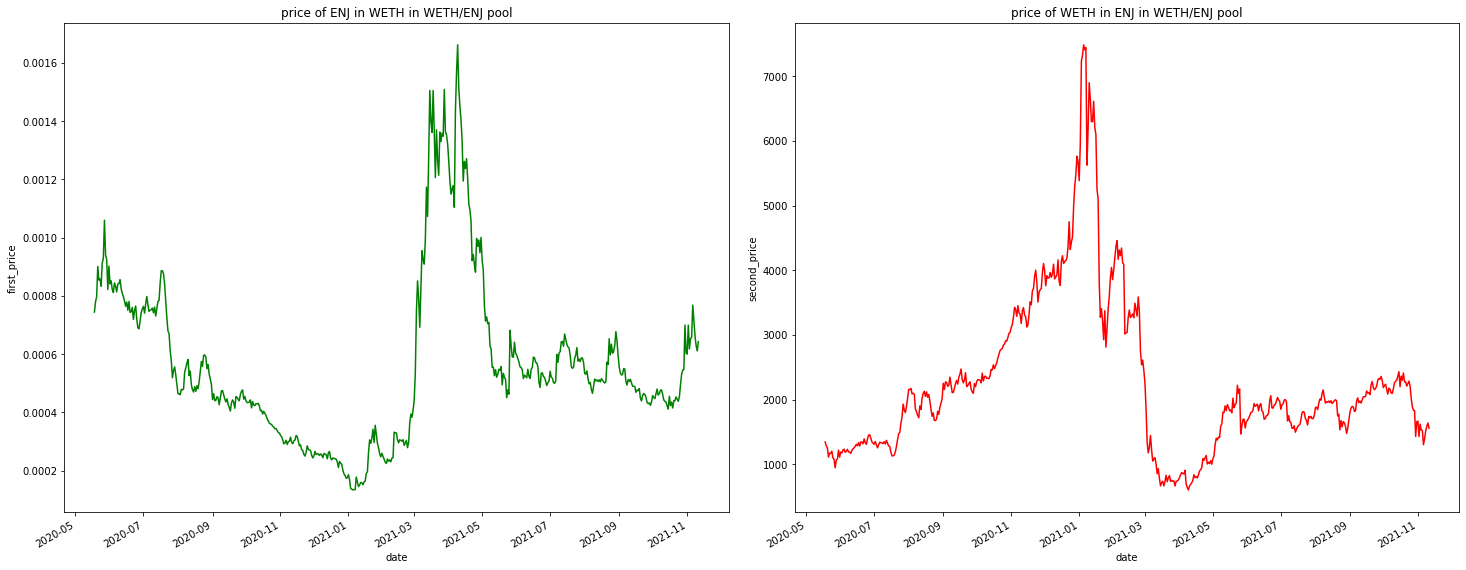

In [92]:
show_pool_price_evolution_from_reserves(enj_eth_reserves_df, first_token_price_name="price of ENJ in WETH in WETH/ENJ pool", 
                                        second_token_price_name="price of WETH in ENJ in WETH/ENJ pool", x=25, y=10, wspace=0.1)

In [96]:
enj_eth_reserves_df

reserve0       reserve1    reserveUSD  dailyVolumeToken0  \
0     14.596187   19609.896031  6.256915e+03           0.000000   
1     35.608058   45643.923958  1.503812e+04           4.334663   
2     44.083044   55306.165361  1.852330e+04           6.154577   
3     68.513132   76046.446474  2.728367e+04          39.970996   
4     70.230793   82183.521342  2.917812e+04          15.703982   
..          ...            ...           ...                ...   
538  197.158411  274486.674468  1.816373e+06          84.303046   
539  189.551810  285956.100674  1.816394e+06         104.945458   
540  183.841111  291757.647168  1.744292e+06          27.593816   
541  181.090315  296421.520097  1.678366e+06          48.458147   
542  185.779164  288994.931808  1.757846e+06          11.626637   

     dailyVolumeToken1       date  first_price  second_price  \
0             0.000000 2020-05-18     0.000744   1343.494443   
1          5636.075761 2020-05-19     0.000780   1281.842554   
2          8060.401355 2020-05-20     0.000797   1254.590445   
3         43953.282808 2020-05-21     0.000901   1109.954323   
4         18107.270743 2020-05-22     0.000855   1170.192137   
..                 ...        ...          ...           ...   
538      113268.199448 2021-11-07     0.000718   1392.213870   
539      150403.609035 2021-11-08     0.000663   1508.590717   
540       43452.417673 2021-11-09     0.000630   1587.009811   
541       76004.100494 2021-11-10     0.000611   1636.871190   
542       18471.957654 2021-11-11     0.000643   1555.583123   

     first_price_increase_rate  second_price_increase_rate  
0                    -4.588920                    4.809630  
1                    -2.126011                    2.172192  
2                   -11.528553                   13.030818  
3                     5.427053                   -5.147686  
4                    -0.407991                    0.409662  
..                         ...                         ...  
538                   8.359121                   -7.714276  
539                   5.198169                   -4.941311  
540                   3.141844                   -3.046139  
541                  -4.966064                    5.225569  
542                        NaN                         NaN  

[543 rows x 10 columns]

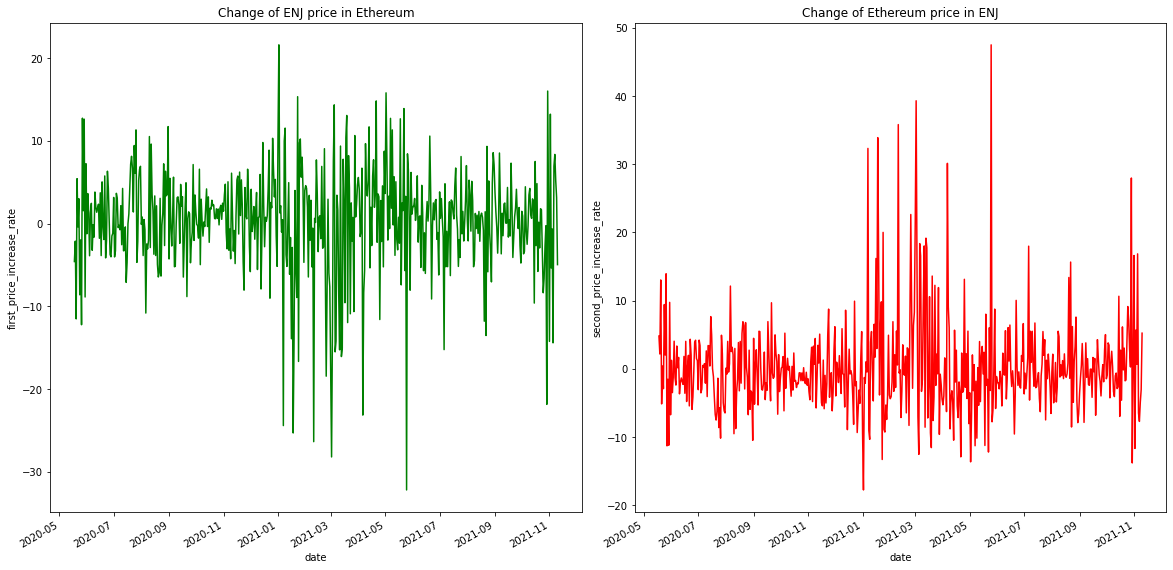

In [97]:
calc_price_and_increase_rates(enj_eth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=enj_eth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of ENJ price in Ethereum')
plt.subplot(1, 2, 2)
sns.lineplot(data=enj_eth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of Ethereum price in ENJ')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

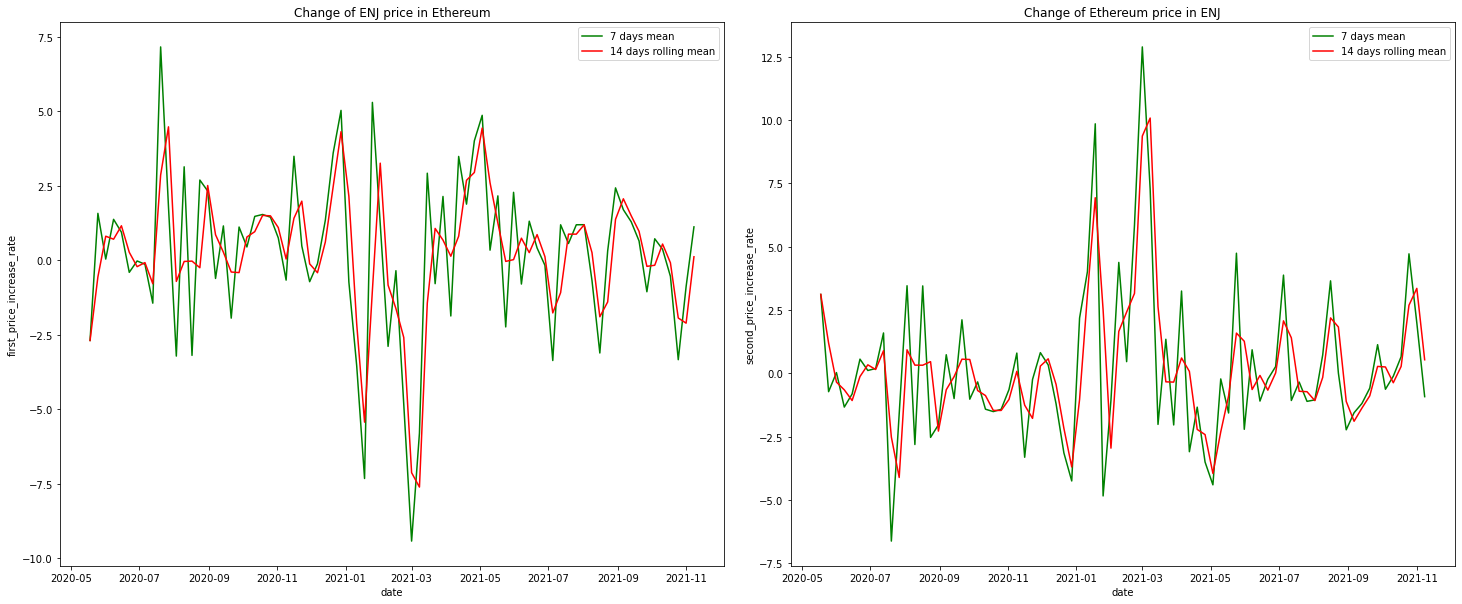

In [98]:
increase_rate_moving_averages(enj_eth_reserves_df, 'Change of ENJ price in Ethereum', 'Change of Ethereum price in ENJ', x_size=25, y_size=10)

## SAND/WETH

In [99]:
sand_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\sand_weth_swaps.pkl')
sand_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\sand_weth_mints.pkl")
sand_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\sand_weth_burns.pkl")
sand_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\sand_weth_reserves.pkl")

### Plotting swapping in moving averages

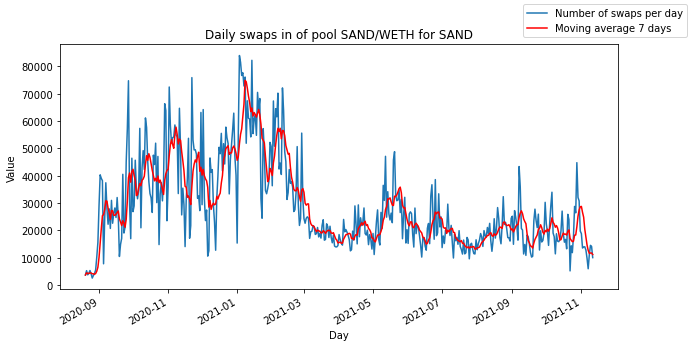

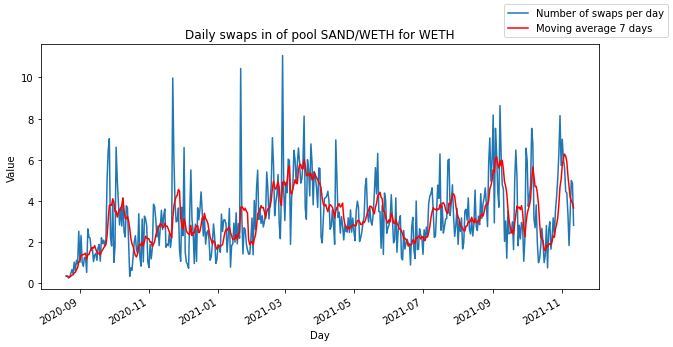

In [41]:
show_swaps_amount_in_moving_averages(swaps_df=sand_weth_df[(sand_weth_df.token_in == 'SAND')], pool_name="SAND/WETH for SAND")
show_swaps_amount_in_moving_averages(swaps_df=sand_weth_df[(sand_weth_df.token_in == 'WETH')], pool_name="SAND/WETH for WETH")

### Swapping values histograms

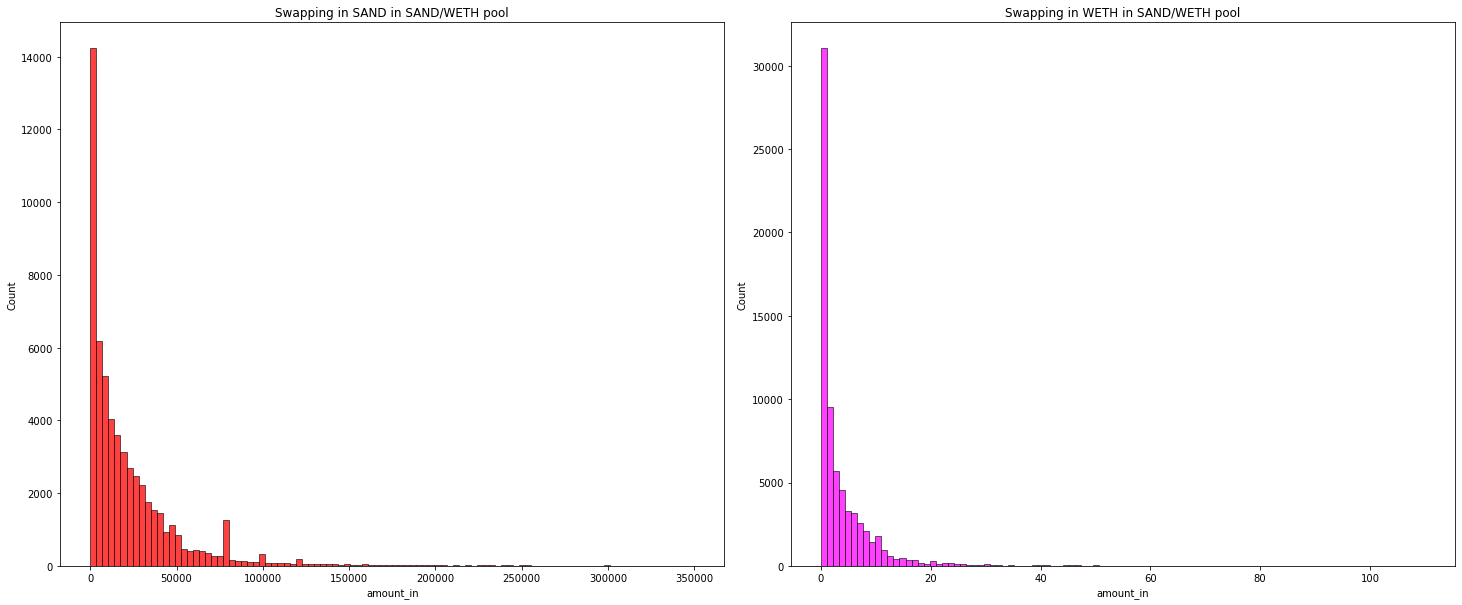

In [155]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=sand_weth_df[sand_weth_df.token_in == 'SAND'], x='amount_in', bins=100, color='red', binrange=[0, 350000]).set_title("Swapping in SAND in SAND/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=sand_weth_df[sand_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta', binrange=[0, 110]).set_title("Swapping in WETH in SAND/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

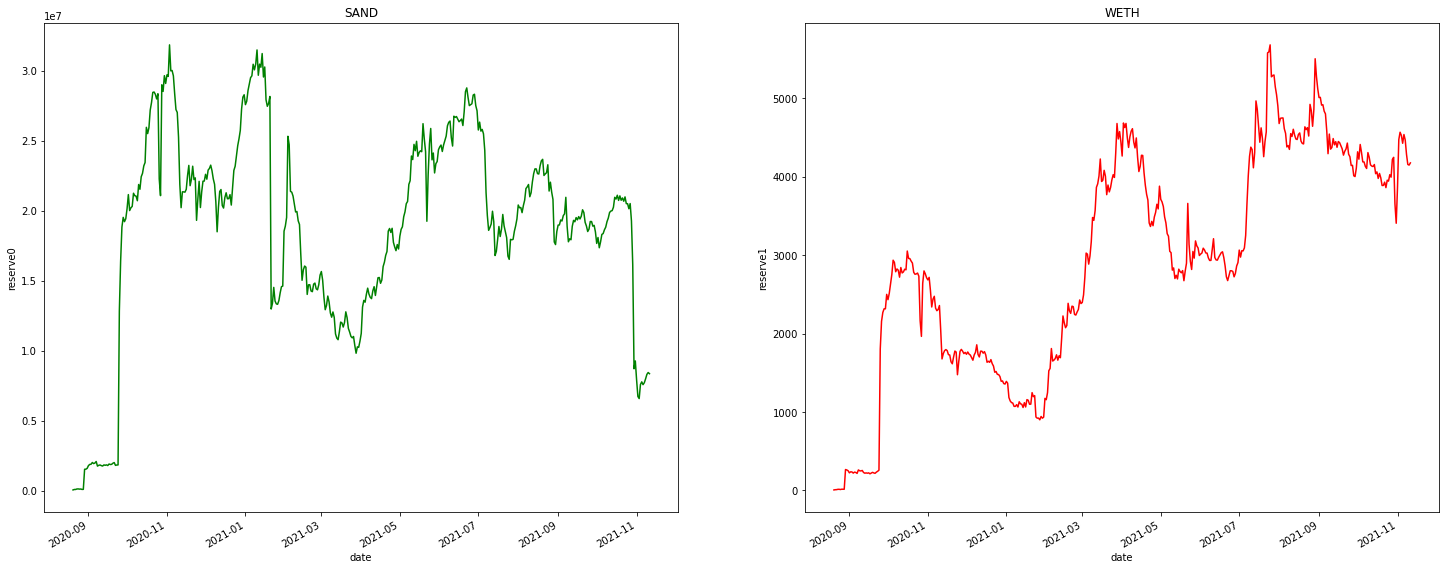

In [91]:
show_swaps_reserves_evolution_through_time(sand_weth_reserves_df, first_token_reserve_name="SAND", second_token_reserve_name="WETH", x=25, y=10)

### Plotting pool price

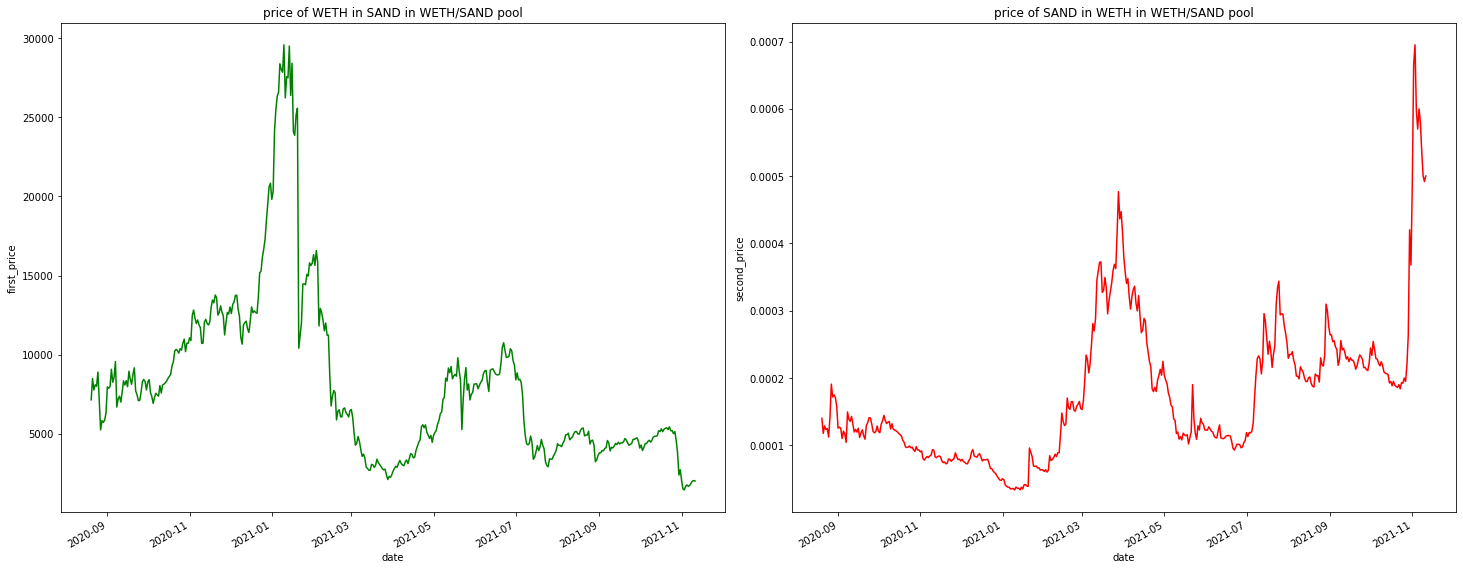

In [90]:
show_pool_price_evolution_from_reserves(sand_weth_reserves_df, first_token_price_name="price of WETH in SAND in WETH/SAND pool", 
                                        second_token_price_name="price of SAND in WETH in WETH/SAND pool", x=25, y=10, wspace=0.1)

In [101]:
sand_weth_reserves_df

reserve0     reserve1    reserveUSD  dailyVolumeToken0  \
0    4.620900e+04     6.473900  5.360654e+03       1.362405e+05   
1    8.011954e+04     9.442597  7.270852e+03       1.862165e+05   
2    8.079633e+04    10.412832  8.245477e+03       7.209562e+04   
3    1.145013e+05    14.152003  1.110878e+04       5.906999e+04   
4    1.199340e+05    14.999432  1.218586e+04       1.398868e+05   
..            ...          ...           ...                ...   
444  7.709895e+06  4469.703849  4.115774e+07       1.839318e+06   
445  7.988303e+06  4286.073315  4.118310e+07       3.775639e+06   
446  8.304657e+06  4158.405242  3.939862e+07       3.644201e+06   
447  8.435944e+06  4150.132166  3.836007e+07       4.702694e+06   
448  8.352274e+06  4178.091149  3.949641e+07       9.938925e+05   

     dailyVolumeToken1       date  first_price  second_price  \
0            24.472452 2020-08-20  7137.737269      0.000140   
1            26.147471 2020-08-21  8484.905341      0.000118   
2             9.277340 2020-08-22  7759.304691      0.000129   
3             7.473852 2020-08-23  8090.820310      0.000124   
4            20.077351 2020-08-24  7995.904214      0.000125   
..                 ...        ...          ...           ...   
444        1066.257574 2021-11-07  1724.922907      0.000580   
445        2023.569226 2021-11-08  1863.781223      0.000537   
446        1870.775753 2021-11-09  1997.077430      0.000501   
447        2445.618720 2021-11-10  2032.692947      0.000492   
448         504.962088 2021-11-11  1999.064628      0.000500   

     first_price_increase_rate  second_price_increase_rate  
0                   -15.877232                   18.873881  
1                     9.351362                   -8.551665  
2                    -4.097429                    4.272491  
3                     1.187059                   -1.173133  
4                   -10.113940                   11.251956  
..                         ...                         ...  
444                  -7.450355                    8.050117  
445                  -6.674564                    7.151923  
446                  -1.752135                    1.783382  
447                   1.682203                   -1.654373  
448                        NaN                         NaN  

[449 rows x 10 columns]

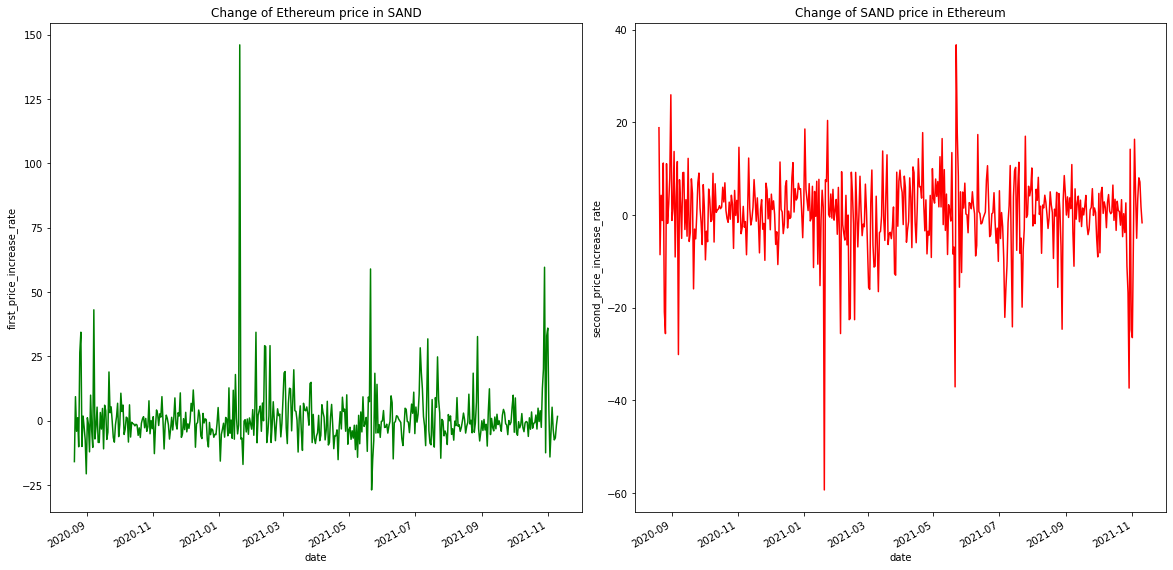

In [102]:
calc_price_and_increase_rates(sand_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=sand_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in SAND')
plt.subplot(1, 2, 2)
sns.lineplot(data=sand_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of SAND price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

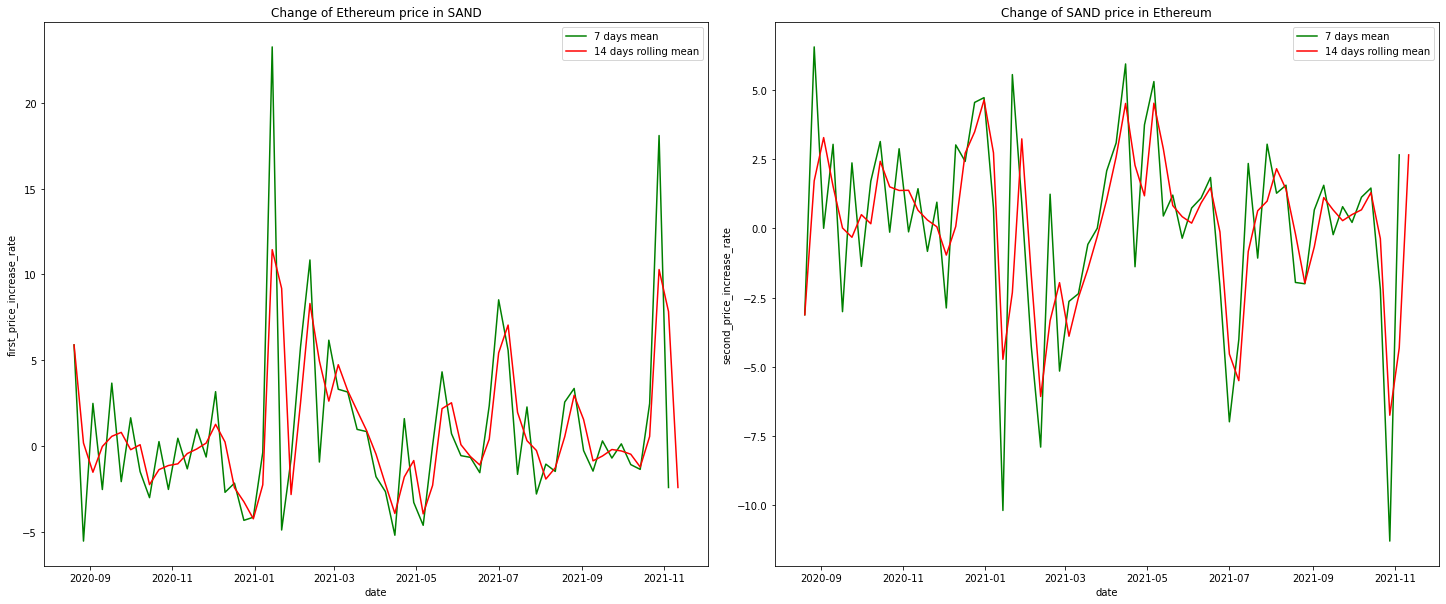

In [103]:
increase_rate_moving_averages(sand_weth_reserves_df, 'Change of Ethereum price in SAND', 'Change of SAND price in Ethereum', x_size=25, y_size=10)

## ALICE/ETH

In [104]:
alice_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\alice_weth_swaps.pkl')
alice_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\alice_weth_mints.pkl")
alice_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\alice_weth_burns.pkl")
alice_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\alice_weth_reserves.pkl")

### Plotting swapping in moving averages

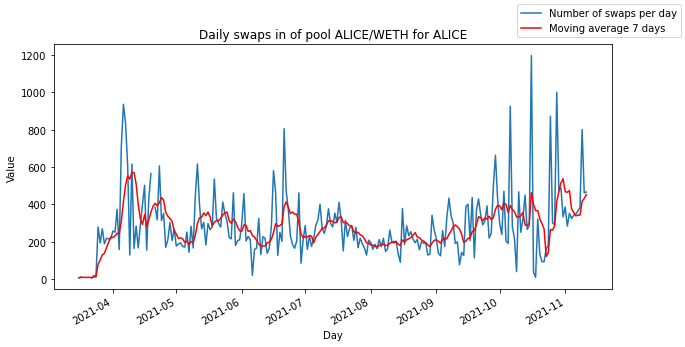

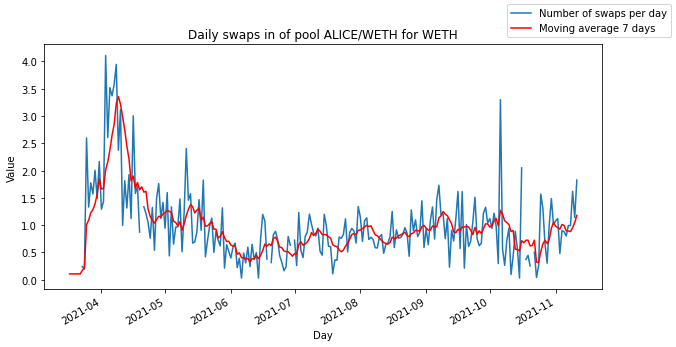

In [42]:
show_swaps_amount_in_moving_averages(swaps_df=alice_weth_df[(alice_weth_df.token_in == 'ALICE')], pool_name="ALICE/WETH for ALICE")
show_swaps_amount_in_moving_averages(swaps_df=alice_weth_df[(alice_weth_df.token_in == 'WETH')], pool_name="ALICE/WETH for WETH")

### Swapping values histograms

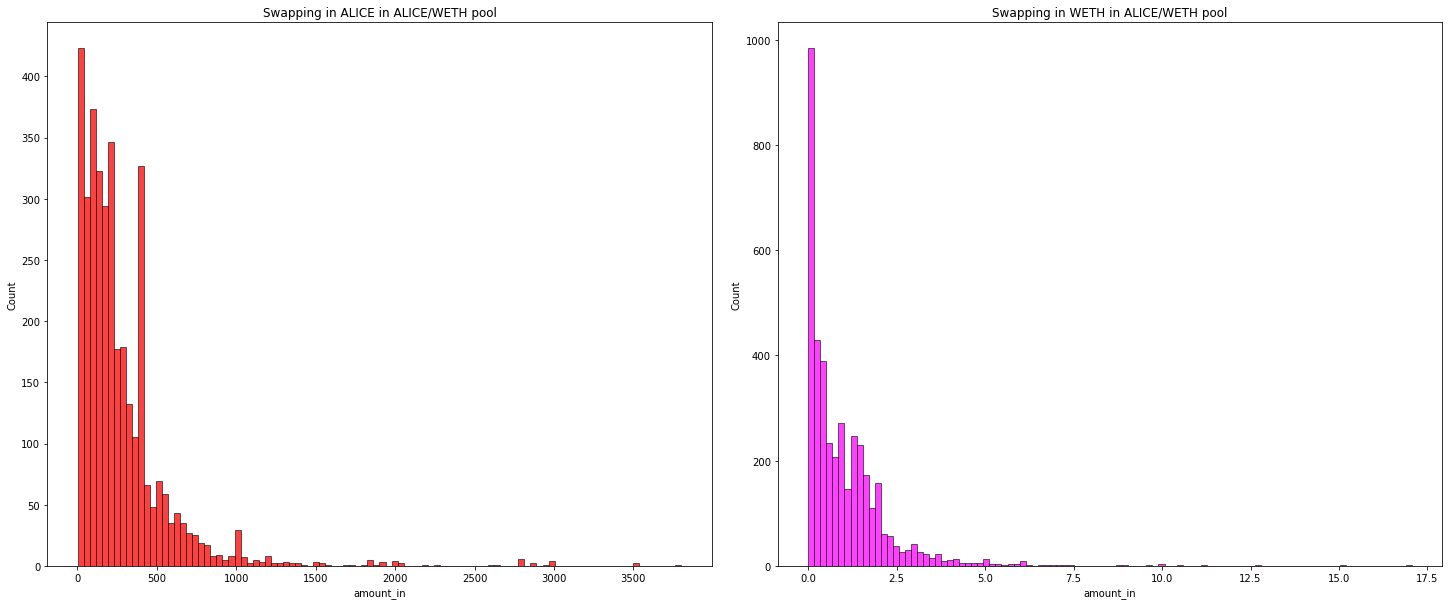

In [157]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=alice_weth_df[alice_weth_df.token_in == 'ALICE'], x='amount_in', bins=100, color='red').set_title("Swapping in ALICE in ALICE/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=alice_weth_df[alice_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in ALICE/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

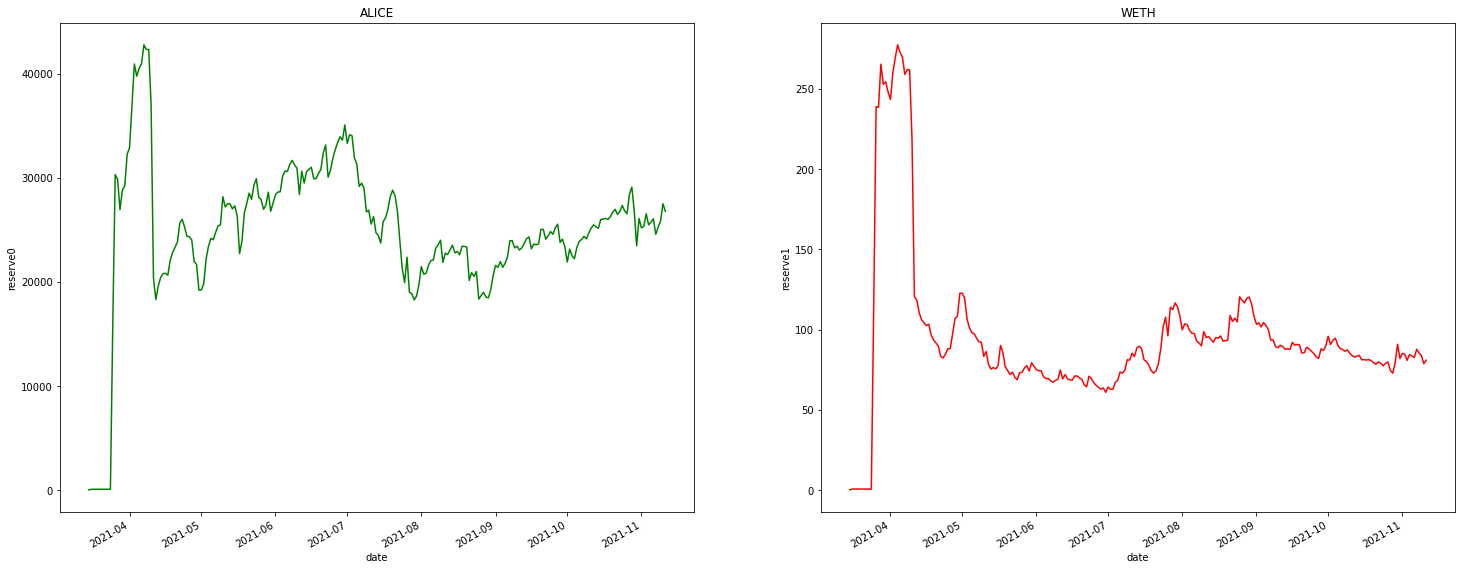

In [89]:
show_swaps_reserves_evolution_through_time(alice_weth_reserves_df, first_token_reserve_name="ALICE", second_token_reserve_name="WETH", x=25, y=10)

### Plotting pool price

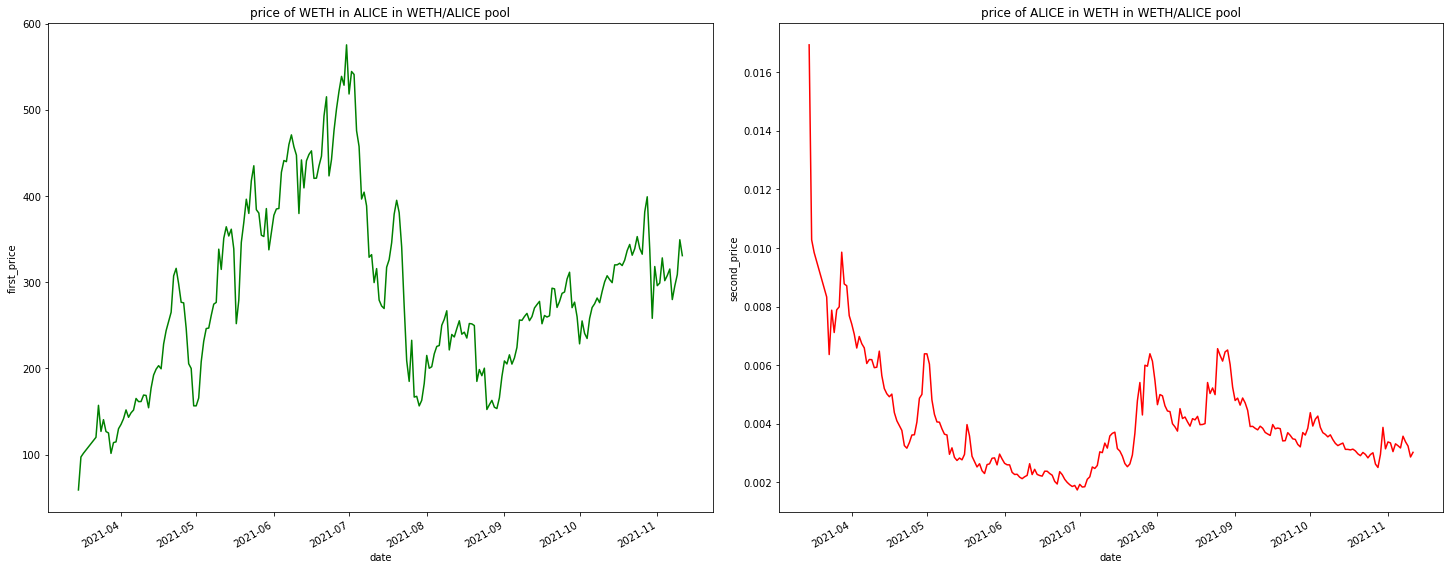

In [88]:
show_pool_price_evolution_from_reserves(alice_weth_reserves_df, first_token_price_name="price of WETH in ALICE in WETH/ALICE pool", 
                                        second_token_price_name="price of ALICE in WETH in WETH/ALICE pool", x=25, y=10, wspace=0.1)

In [106]:
alice_weth_reserves_df

reserve0   reserve1     reserveUSD  dailyVolumeToken0  \
0        6.000000   0.101598     367.355029           0.000000   
1       67.100212   0.689707    2430.779070          14.839028   
2       68.634374   0.675505    2232.418760          46.915728   
3       74.634374   0.621349    2098.103332           6.000000   
4       85.550512   0.544140    1817.052880         106.134748   
..            ...        ...            ...                ...   
232  24564.998908  87.756435  809922.648413       10989.471179   
233  25269.449095  85.443579  814698.938656       13069.776295   
234  25843.637657  83.655710  798216.894229       12234.169168   
235  27501.138208  78.727239  726965.361910       13115.328077   
236  26780.402035  80.935931  766018.706167       10051.931667   

     dailyVolumeToken1       date  first_price  second_price  \
0             0.000000 2021-03-15    59.056221      0.016933   
1             0.195232 2021-03-16    97.287957      0.010279   
2             0.438203 2021-03-17   101.604599      0.009842   
3             0.054155 2021-03-22   120.116605      0.008325   
4             1.034504 2021-03-23   157.221427      0.006360   
..                 ...        ...          ...           ...   
232          38.542690 2021-11-07   279.922481      0.003572   
233          45.963698 2021-11-08   295.744272      0.003381   
234          37.421361 2021-11-09   308.928555      0.003237   
235          39.128551 2021-11-10   349.321764      0.002863   
236          30.659685 2021-11-11   330.883967      0.003022   

     first_price_increase_rate  second_price_increase_rate  
0                   -39.297501                   64.737864  
1                    -4.248471                    4.436975  
2                   -15.411696                   18.219653  
3                   -23.600360                   30.890669  
4                    23.818017                  -19.236310  
..                         ...                         ...  
232                  -5.349822                    5.652204  
233                  -4.267745                    4.458001  
234                 -11.563325                   13.075259  
235                   5.572285                   -5.278170  
236                        NaN                         NaN  

[237 rows x 10 columns]

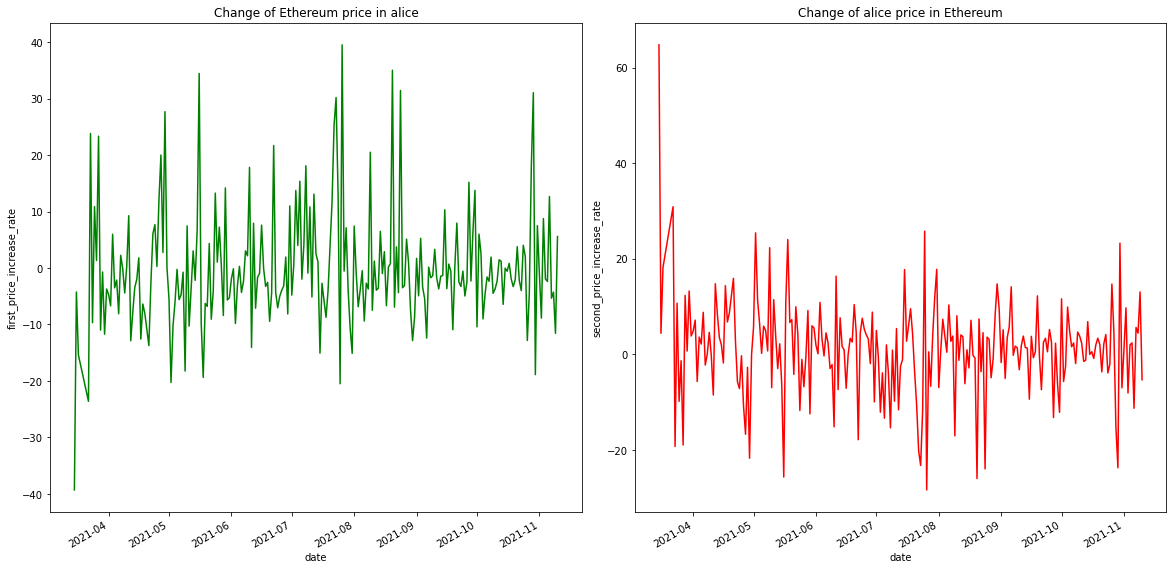

In [107]:
calc_price_and_increase_rates(alice_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=alice_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in alice')
plt.subplot(1, 2, 2)
sns.lineplot(data=alice_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of alice price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

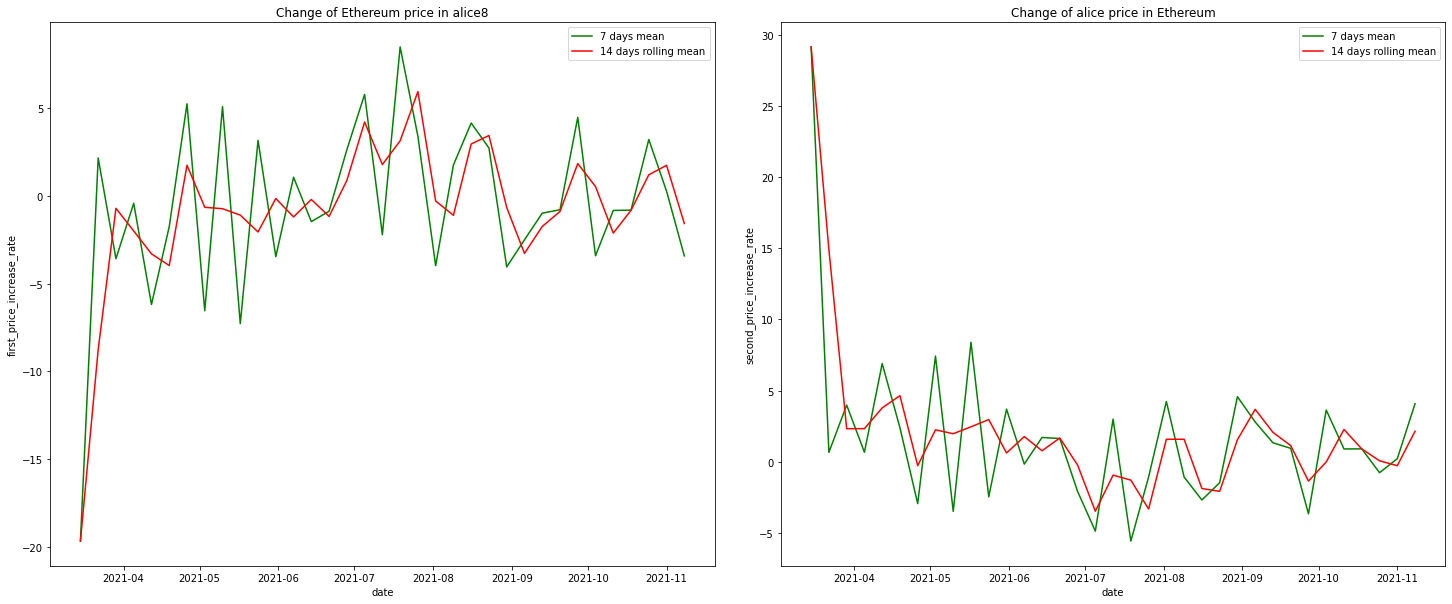

In [108]:
increase_rate_moving_averages(alice_weth_reserves_df, 'Change of Ethereum price in alice8', 'Change of alice price in Ethereum', x_size=25, y_size=10)

## DOGE/ETH

In [109]:
doge_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\doge_weth_swaps.pkl')
doge_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\doge_weth_mints.pkl")
doge_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\doge_weth_burns.pkl")
doge_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\doge_weth_reserves.pkl")

In [170]:
doge_weth_df

token_in token_out     amount_in     amount_out    amount_usd  \
0         WETH      DOGE      1.000000  131189.389055   1237.901160   
1         WETH      DOGE      0.007725    1000.000000      9.508499   
2         WETH      DOGE      0.041338    5347.743915     50.895183   
3         WETH      DOGE      0.025787    3333.000000     31.799822   
4         WETH      DOGE      0.300000   38736.888276    372.869812   
...        ...       ...           ...            ...           ...   
12114     DOGE      WETH  33842.896541       1.860260   8559.376795   
12115     WETH      DOGE      3.066334   55343.622098  14193.795894   
12116     DOGE      WETH  55343.618509       3.103351  14365.145218   
12117     WETH      DOGE      5.618417  100000.000000  26007.173571   
12118     DOGE      WETH  60000.000000       3.329792  15686.868433   

                timestamp  
0     2021-01-18 21:14:49  
1     2021-01-18 21:18:57  
2     2021-01-18 21:29:35  
3     2021-01-18 21:31:54  
4     2021-01-18 23:33:09  
...                   ...  
12114 2021-11-11 00:51:19  
12115 2021-11-11 04:30:56  
12116 2021-11-11 04:30:56  
12117 2021-11-11 04:30:56  
12118 2021-11-11 11:08:38  

[12119 rows x 6 columns]

### Plotting swapping in moving averages

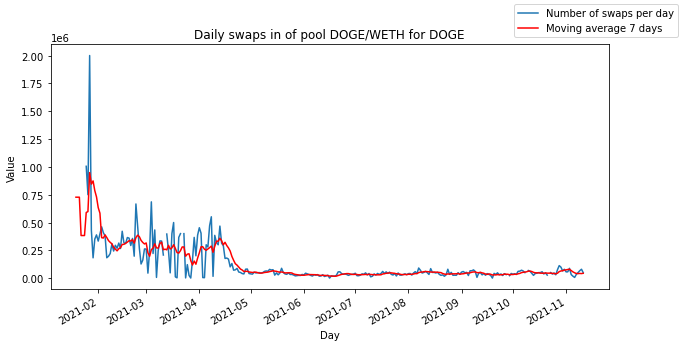

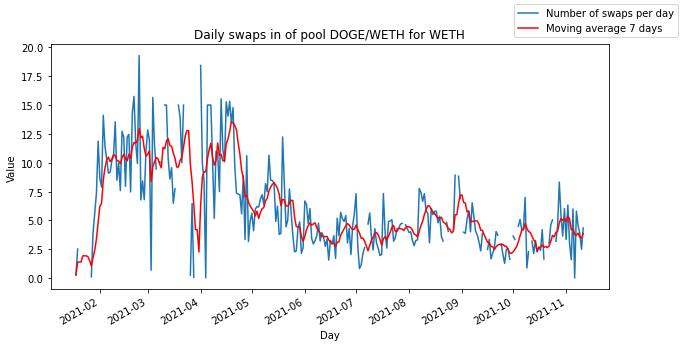

In [43]:
show_swaps_amount_in_moving_averages(swaps_df=doge_weth_df[(doge_weth_df.token_in == 'DOGE')], pool_name="DOGE/WETH for DOGE")
show_swaps_amount_in_moving_averages(swaps_df=doge_weth_df[(doge_weth_df.token_in == 'WETH')], pool_name="DOGE/WETH for WETH")

### Swapping values histograms

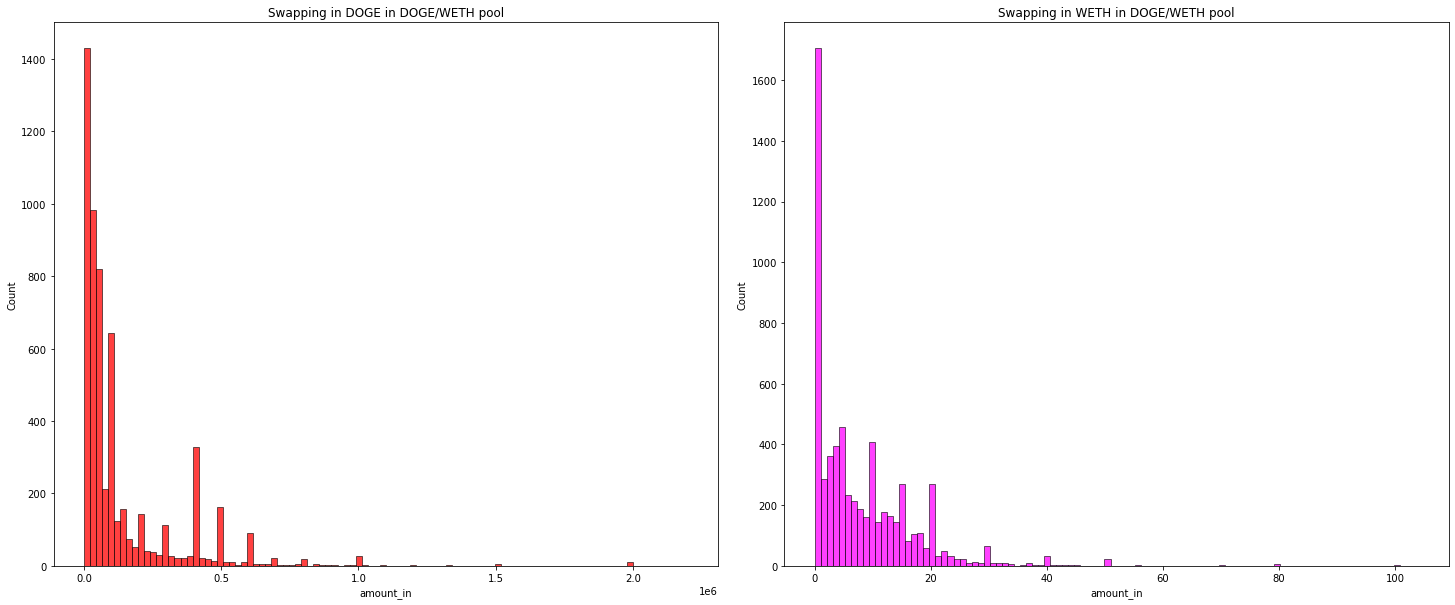

In [161]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=doge_weth_df[doge_weth_df.token_in == 'DOGE'], x='amount_in', bins=100, color='red', binrange=[0, 2200000]).set_title("Swapping in DOGE in DOGE/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=doge_weth_df[doge_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in DOGE/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

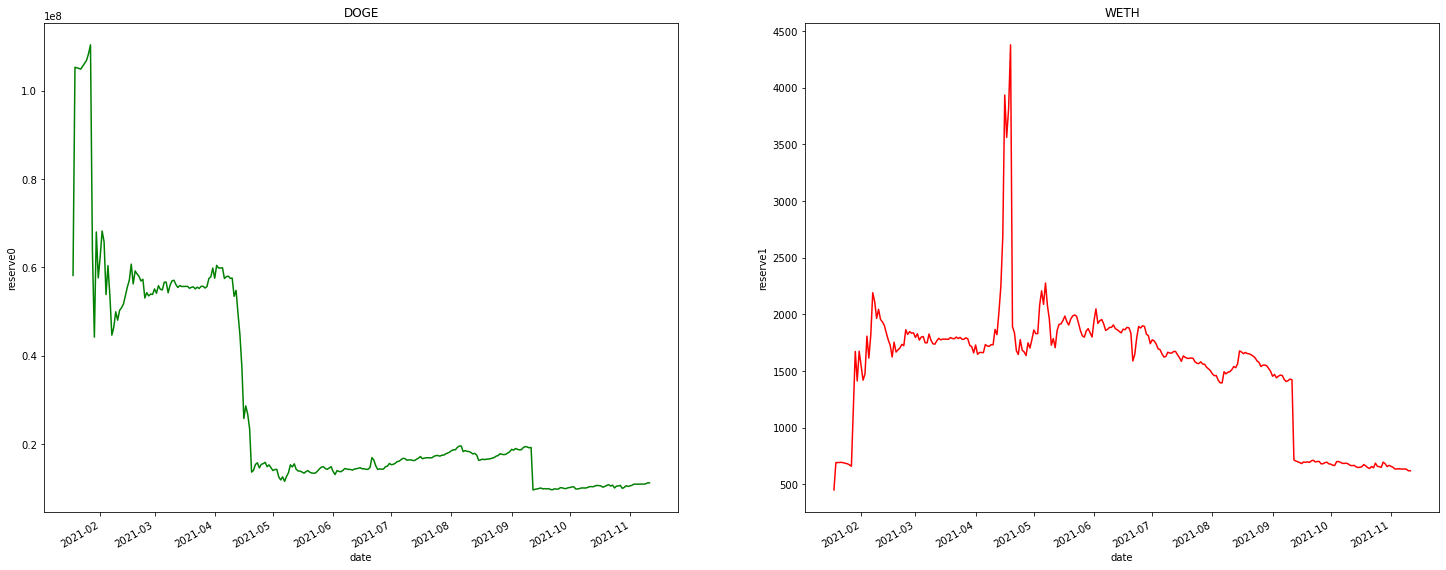

In [87]:
show_swaps_reserves_evolution_through_time(doge_weth_reserves_df, first_token_reserve_name="DOGE", second_token_reserve_name="WETH", x=25, y=10)

### Plotting pool price

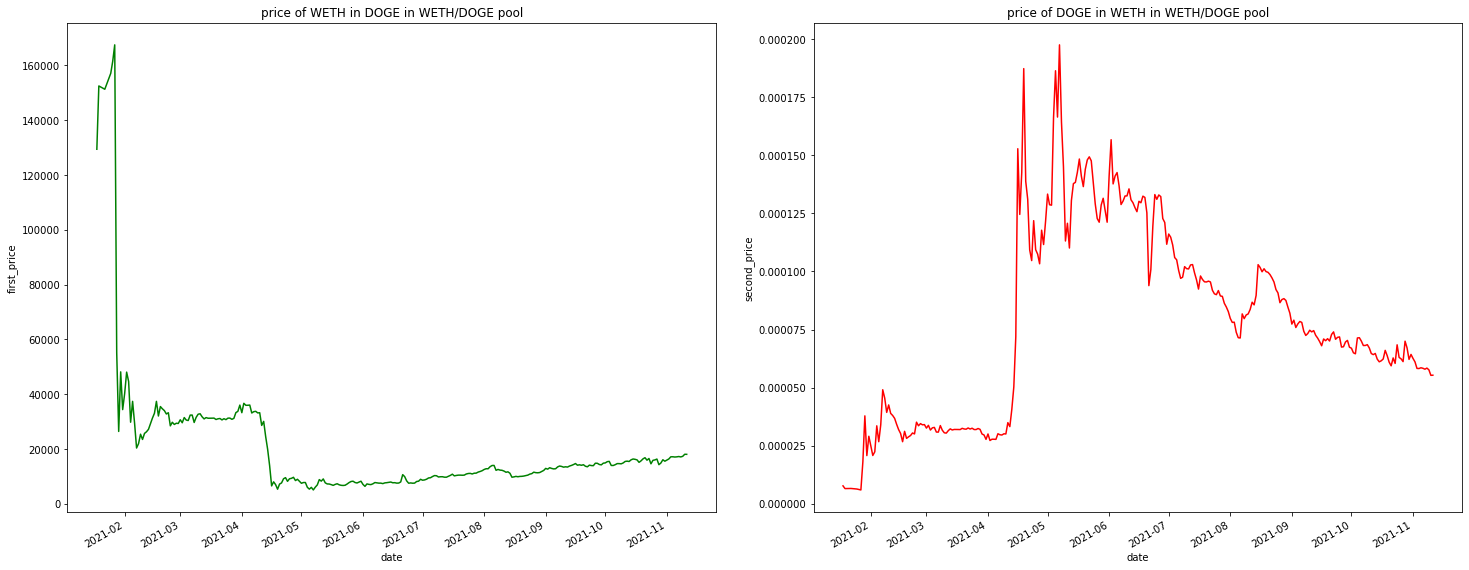

In [86]:
show_pool_price_evolution_from_reserves(doge_weth_reserves_df, first_token_price_name="price of WETH in DOGE in WETH/DOGE pool", 
                                        second_token_price_name="price of DOGE in WETH in WETH/DOGE pool", x=25, y=10, wspace=0.15)

In [112]:
doge_weth_reserves_df

reserve0    reserve1    reserveUSD  dailyVolumeToken0  \
0    5.815876e+07  449.362514  1.117025e+06       1.796070e+05   
1    1.053052e+08  690.380932  1.924844e+06       8.014429e+06   
2    1.048894e+08  693.127828  1.756477e+06       4.933253e+05   
3    1.068894e+08  680.197323  1.847699e+06       2.020000e+06   
4    1.083894e+08  670.812012  1.807903e+06       1.500000e+06   
..            ...         ...           ...                ...   
289  1.092428e+07  632.966905  5.827256e+06       2.376571e+05   
290  1.088065e+07  635.657490  6.075537e+06       8.608951e+05   
291  1.095118e+07  631.621488  6.072999e+06       3.327703e+05   
292  1.118467e+07  618.504353  5.635877e+06       4.091358e+05   
293  1.117852e+07  618.895702  5.831317e+06       3.045301e+05   

     dailyVolumeToken1       date    first_price  second_price  \
0             1.374850 2021-01-18  129425.031923      0.000008   
1            56.096709 2021-01-19  152532.060272      0.000007   
2             3.253104 2021-01-22  151327.605393      0.000007   
3            13.058171 2021-01-25  157144.656179      0.000006   
4             9.385311 2021-01-26  161579.358327      0.000006   
..                 ...        ...            ...           ...   
289          13.770956 2021-11-07   17258.844808      0.000058   
290          51.732961 2021-11-08   17117.161172      0.000058   
291          19.589827 2021-11-09   17338.206428      0.000058   
292          23.099808 2021-11-10   18083.417290      0.000055   
293          16.978153 2021-11-11   18062.033995      0.000055   

     first_price_increase_rate  second_price_increase_rate  
0                   -15.148965                   17.853601  
1                     0.795925                   -0.789640  
2                    -3.701717                    3.844012  
3                    -2.744597                    2.822051  
4                    -3.553822                    3.684772  
..                         ...                         ...  
289                   0.827729                   -0.820933  
290                  -1.274903                    1.291366  
291                  -4.120963                    4.298085  
292                   0.118388                   -0.118248  
293                        NaN                         NaN  

[294 rows x 10 columns]

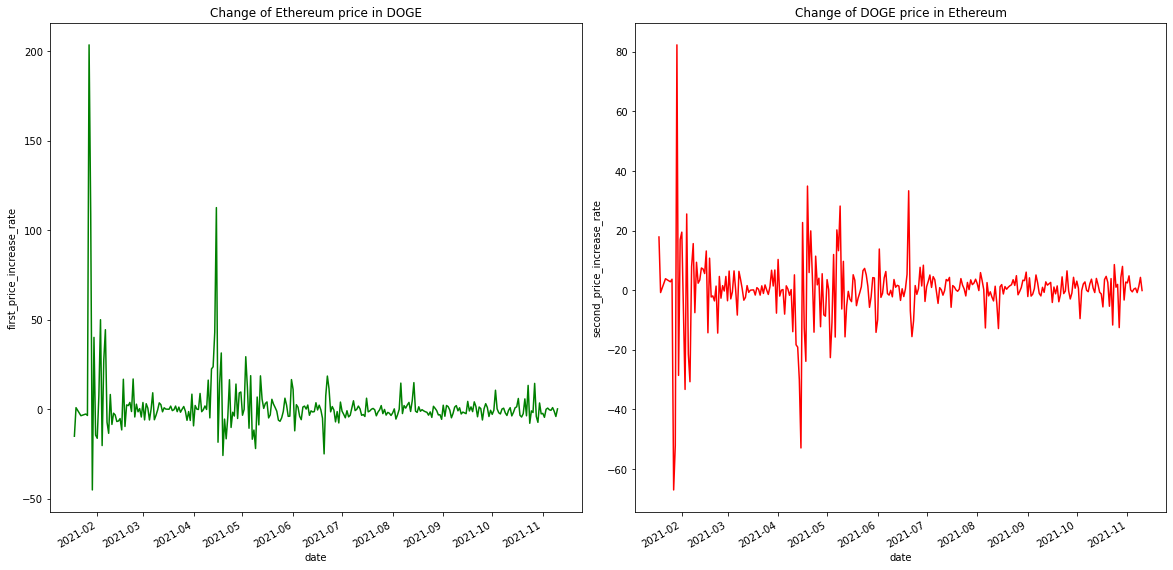

In [113]:
calc_price_and_increase_rates(doge_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=doge_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in DOGE')
plt.subplot(1, 2, 2)
sns.lineplot(data=doge_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of DOGE price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

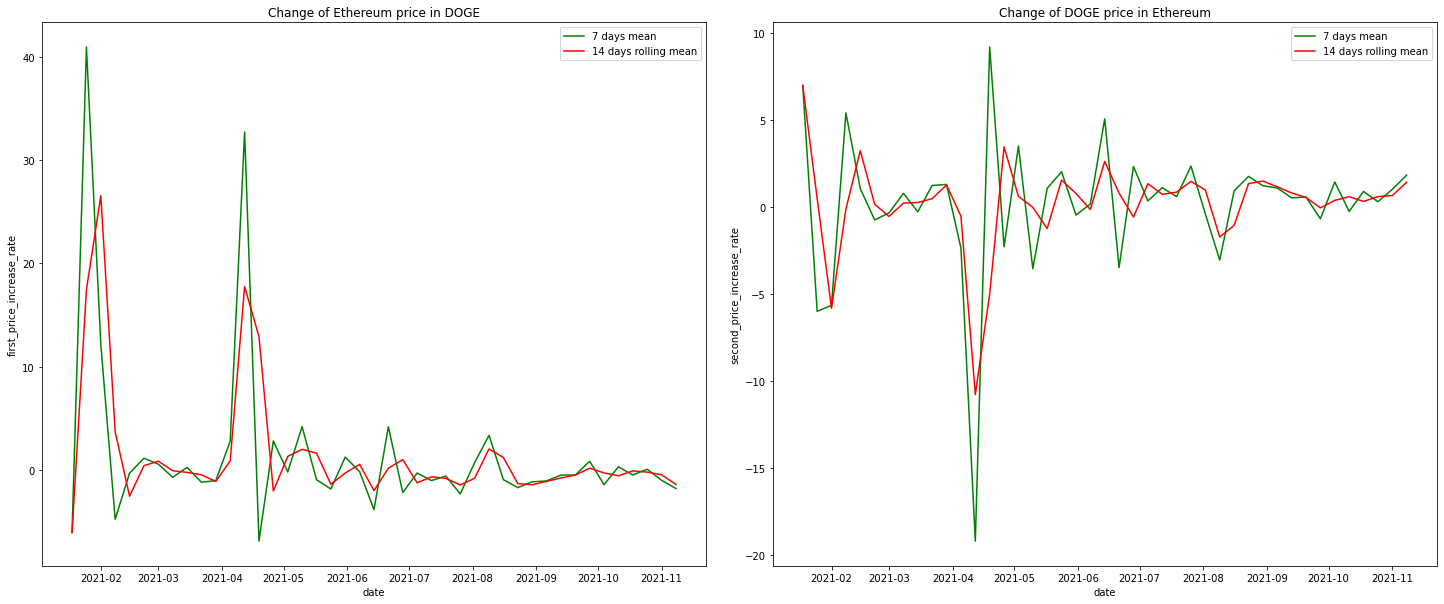

In [114]:
increase_rate_moving_averages(doge_weth_reserves_df, 'Change of Ethereum price in DOGE', 'Change of DOGE price in Ethereum', x_size=25, y_size=10)

## ELON/ETH

In [115]:
elon_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\elon_weth_swaps.pkl')
elon_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\elon_weth_mints.pkl")
elon_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\elon_weth_burns.pkl")
elon_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\elon_weth_reserves.pkl")

In [171]:
elon_weth_df

token_in token_out     amount_in    amount_out    amount_usd  \
0          WETH      ELON  8.659269e+00  8.875907e+13  22731.628092   
1          ELON      WETH  8.875907e+13  1.099062e+01  23527.395943   
2          WETH      ELON  7.000000e+00  5.158411e+13  17774.567217   
3          WETH      ELON  6.000000e-01  5.077908e+12   1430.016632   
4          ELON      WETH  2.168125e+13  2.653980e+00   6140.360594   
...         ...       ...           ...           ...           ...   
296268     WETH      ELON  1.050478e-02  2.685627e+07     49.462083   
296269     WETH      ELON  9.912500e-01  2.533675e+09   4667.199976   
296270     WETH      ELON  1.701677e-02  4.348636e+07     80.120958   
296271     ELON      WETH  1.170391e+09  4.552035e-01   2144.312202   
296272     WETH      ELON  1.404066e+00  3.587711e+09   6611.006326   

                 timestamp  
0      2021-04-23 01:10:31  
1      2021-04-23 01:10:31  
2      2021-04-23 01:10:31  
3      2021-04-23 01:11:04  
4      2021-04-23 01:11:04  
...                    ...  
296268 2021-11-11 13:22:40  
296269 2021-11-11 13:22:57  
296270 2021-11-11 13:23:07  
296271 2021-11-11 13:25:02  
296272 2021-11-11 13:25:30  

[296273 rows x 6 columns]

### Plotting swapping in moving averages

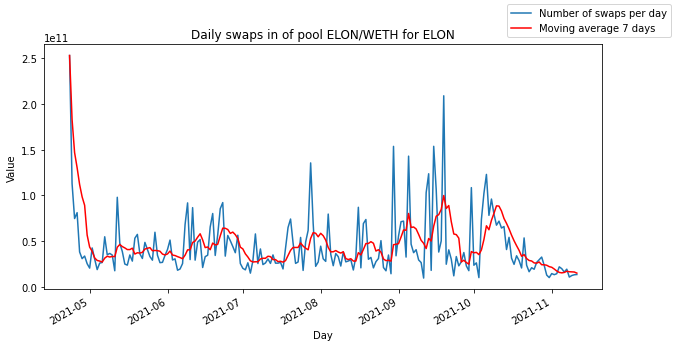

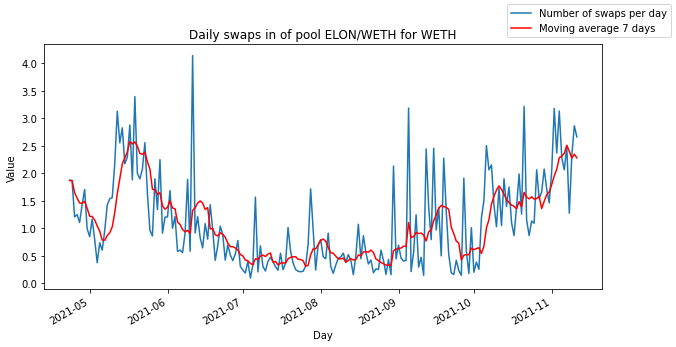

In [44]:
show_swaps_amount_in_moving_averages(swaps_df=elon_weth_df[(elon_weth_df.token_in == 'ELON')], pool_name="ELON/WETH for ELON")
show_swaps_amount_in_moving_averages(swaps_df=elon_weth_df[(elon_weth_df.token_in == 'WETH')], pool_name="ELON/WETH for WETH")

### Swapping values histograms

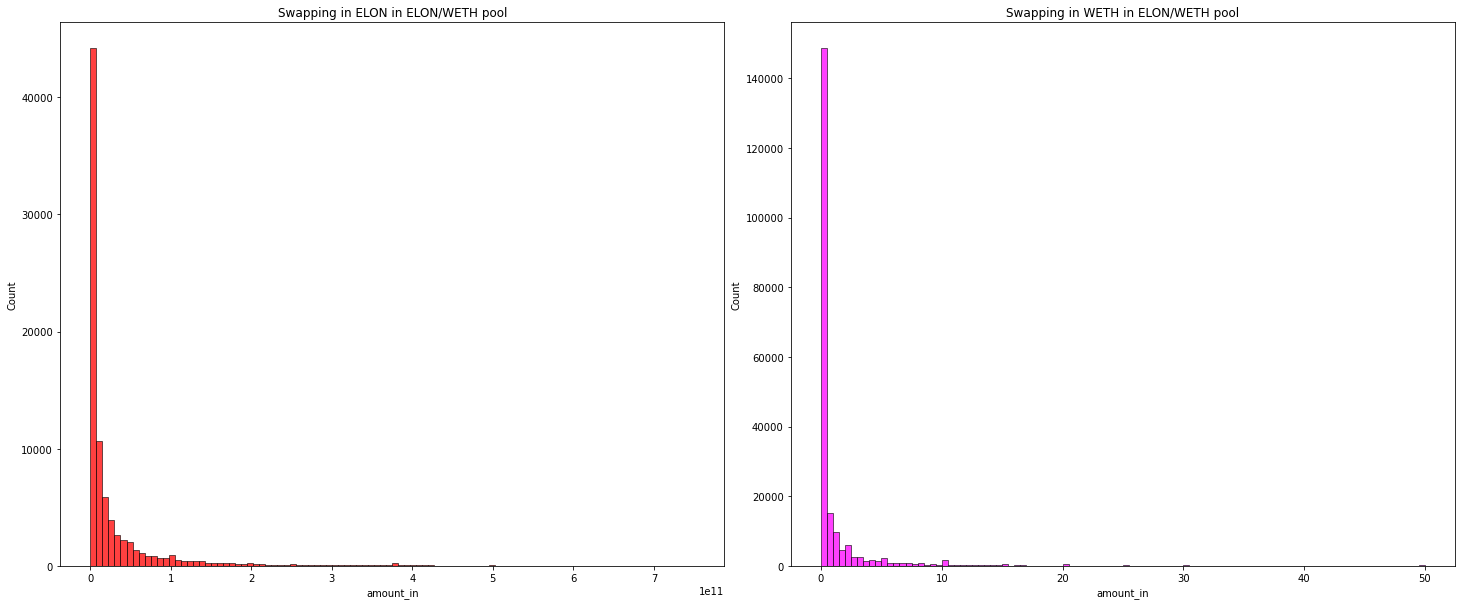

In [170]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=elon_weth_df[elon_weth_df.token_in == 'ELON'], x='amount_in', bins=100, color='red', binrange=[0, 750000000000]).set_title("Swapping in ELON in ELON/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=elon_weth_df[elon_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta', binrange=[0, 50]).set_title("Swapping in WETH in ELON/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

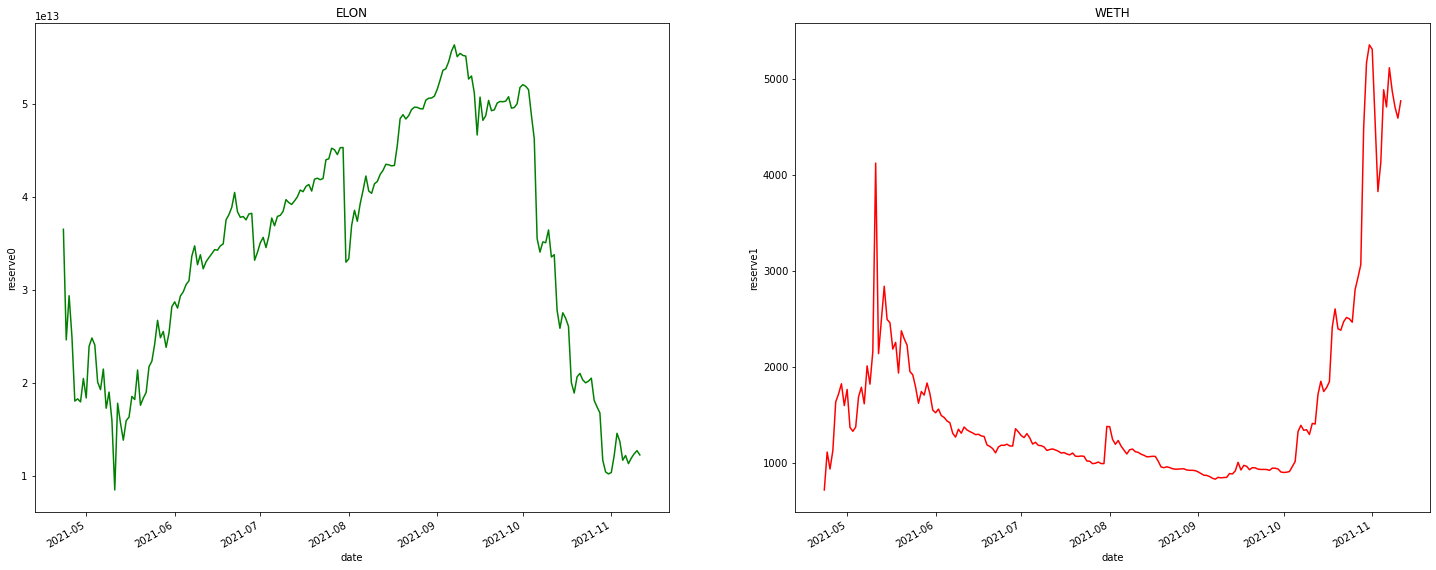

In [83]:
show_swaps_reserves_evolution_through_time(elon_weth_reserves_df, first_token_reserve_name="ELON", second_token_reserve_name="WETH", x=25, y=10)

### Plotting pool price

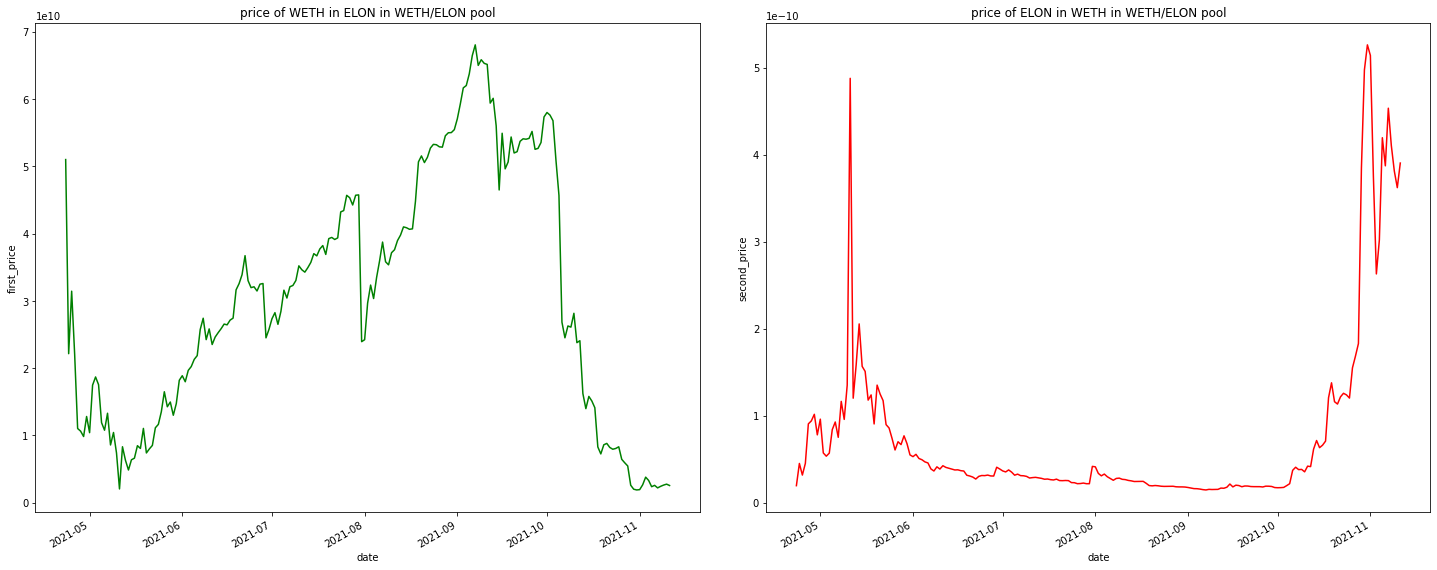

In [80]:
show_pool_price_evolution_from_reserves(elon_weth_reserves_df, first_token_price_name="price of WETH in ELON in WETH/ELON pool", 
                                        second_token_price_name="price of ELON in WETH in WETH/ELON pool", x=25, y=10, wspace=0.1)

In [117]:
elon_weth_reserves_df

reserve0     reserve1    reserveUSD  dailyVolumeToken0  \
0    3.650502e+13   715.602627  3.385606e+06       2.729964e+15   
1    2.459976e+13  1110.292501  4.916181e+06       5.911238e+14   
2    2.935363e+13   933.446347  4.311324e+06       1.858092e+14   
3    2.492029e+13  1127.543829  5.708305e+06       2.802904e+14   
4    1.801824e+13  1632.782457  8.678267e+06       1.908413e+14   
..            ...          ...           ...                ...   
198  1.128041e+13  5113.576467  4.708419e+07       3.279026e+13   
199  1.187093e+13  4873.017955  4.682281e+07       1.107740e+13   
200  1.233480e+13  4701.308475  4.453359e+07       1.016520e+13   
201  1.267539e+13  4588.670503  4.241485e+07       1.286510e+13   
202  1.221795e+13  4768.604650  4.490569e+07       6.273728e+12   

     dailyVolumeToken1       date   first_price  second_price  \
0         41193.755814 2021-04-23  5.101298e+10  1.960285e-11   
1         22876.541746 2021-04-24  2.215610e+10  4.513429e-11   
2          6450.296998 2021-04-25  3.144651e+10  3.180003e-11   
3         12044.298435 2021-04-26  2.210139e+10  4.524601e-11   
4         13764.348242 2021-04-27  1.103530e+10  9.061832e-11   
..                 ...        ...           ...           ...   
198       14488.690623 2021-11-07  2.205973e+09  4.533147e-10   
199        4677.153491 2021-11-08  2.436053e+09  4.105001e-10   
200        3846.178431 2021-11-09  2.623695e+09  3.811419e-10   
201        4489.571770 2021-11-10  2.762323e+09  3.620141e-10   
202        2441.076969 2021-11-11  2.562164e+09  3.902951e-10   

     first_price_increase_rate  second_price_increase_rate  
0                   130.243467                  -56.567715  
1                   -29.543513                   41.931572  
2                    42.282910                  -29.717490  
3                   100.279132                  -50.069686  
4                     3.758072                   -3.621956  
..                         ...                         ...  
198                  -9.444784                   10.429862  
199                  -7.151805                    7.702686  
200                  -5.018544                    5.283710  
201                   7.812124                   -7.246054  
202                        NaN                         NaN  

[203 rows x 10 columns]

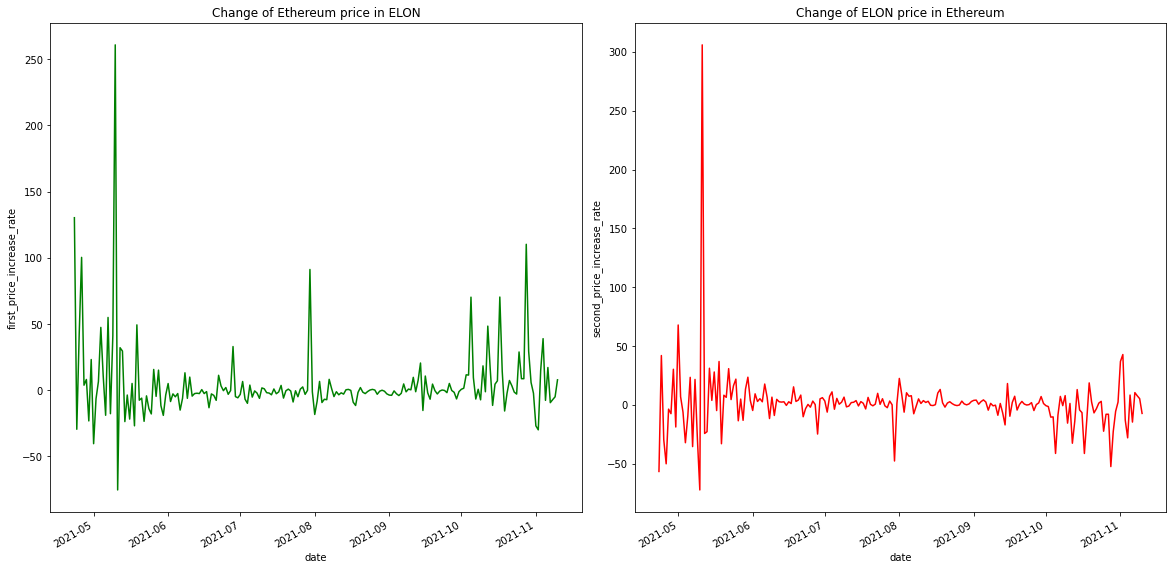

In [118]:
calc_price_and_increase_rates(elon_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=elon_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in ELON')
plt.subplot(1, 2, 2)
sns.lineplot(data=elon_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of ELON price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

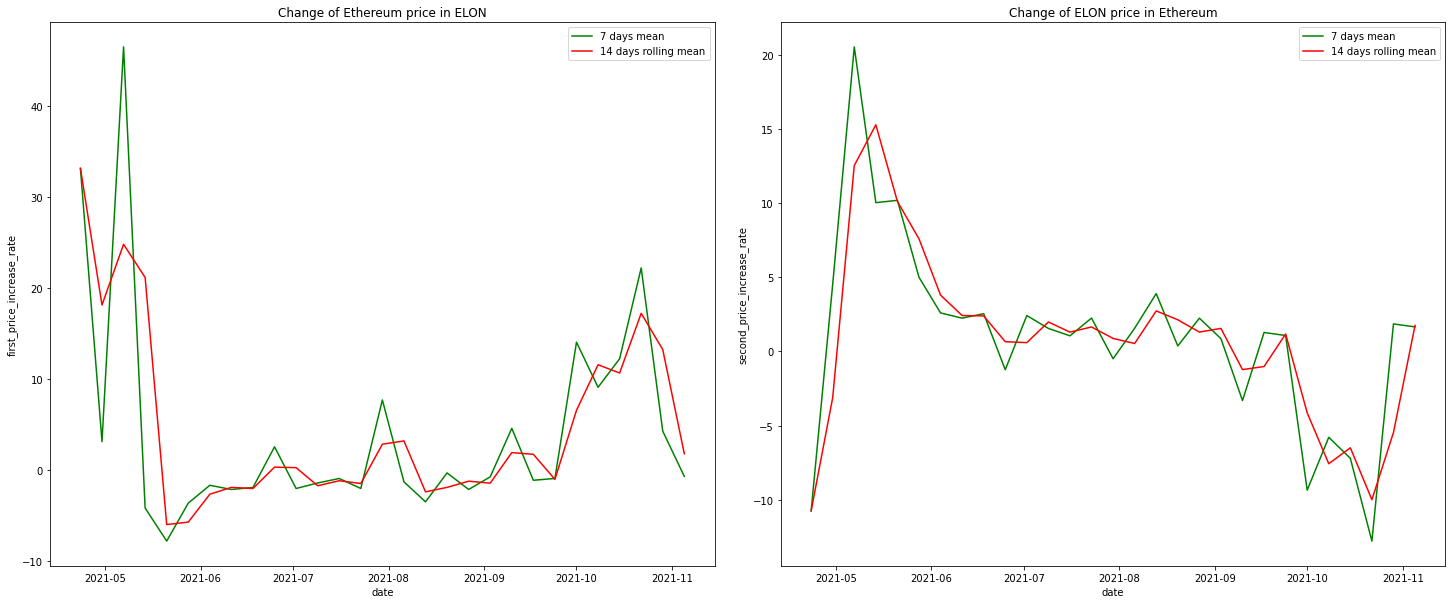

In [119]:
increase_rate_moving_averages(elon_weth_reserves_df, 'Change of Ethereum price in ELON', 'Change of ELON price in Ethereum', x_size=25, y_size=10)

## SHIB/ETH

In [120]:
shib_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\shib_weth_swaps.pkl')
shib_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\shib_weth_mints.pkl")
shib_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\shib_weth_burns.pkl")
shib_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\shib_weth_reserves.pkl")

In [172]:
shib_weth_df

token_in token_out     amount_in    amount_out    amount_usd  \
0           WETH      SHIB  4.000000e-01  1.898354e+13    139.381551   
1           WETH      SHIB  4.000000e-01  1.757930e+13    139.276591   
2           WETH      SHIB  2.000000e+00  7.144941e+13    746.446085   
3           WETH      SHIB  1.000000e-01  2.990975e+12     34.282991   
4           WETH      SHIB  1.000000e+00  2.320679e+13    353.606470   
...          ...       ...           ...           ...           ...   
1204940     WETH      SHIB  1.482560e-01  1.256766e+07    703.363025   
1204941     SHIB      WETH  5.000000e+07  5.856120e-01   2778.307967   
1204942     SHIB      WETH  4.451439e+07  5.218198e-01   2475.659643   
1204943     SHIB      WETH  1.267789e+07  1.484002e-01    704.116159   
1204944     WETH      SHIB  7.061297e+00  5.963899e+08  33499.619540   

                  timestamp  
0       2020-07-31 20:42:11  
1       2020-07-31 20:42:36  
2       2020-07-31 20:43:55  
3       2020-07-31 20:44:34  
4       2020-07-31 20:45:35  
...                     ...  
1204940 2021-11-11 15:23:31  
1204941 2021-11-11 15:23:59  
1204942 2021-11-11 15:23:59  
1204943 2021-11-11 15:26:01  
1204944 2021-11-11 15:27:08  

[1204945 rows x 6 columns]

### Plotting swapping in moving averages

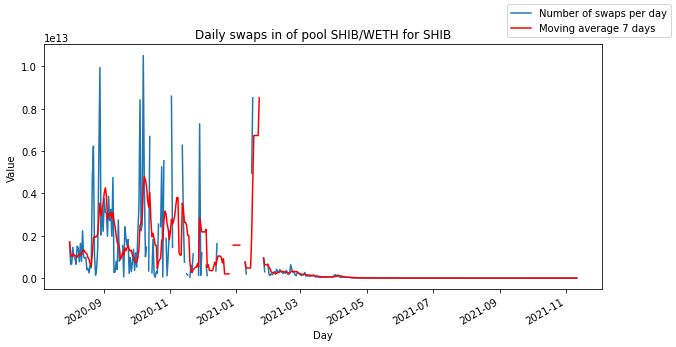

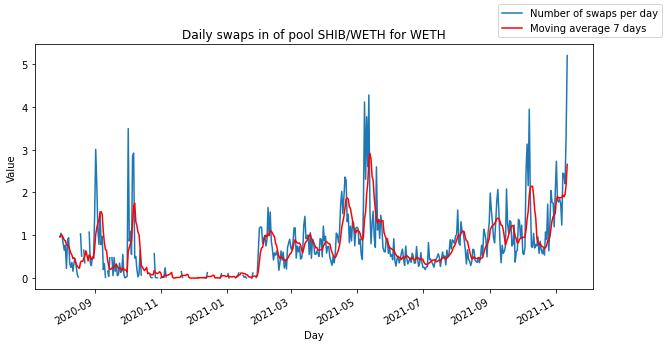

In [45]:
show_swaps_amount_in_moving_averages(swaps_df=shib_weth_df[(shib_weth_df.token_in == 'SHIB')], pool_name="SHIB/WETH for SHIB")
show_swaps_amount_in_moving_averages(swaps_df=shib_weth_df[(shib_weth_df.token_in == 'WETH')], pool_name="SHIB/WETH for WETH")

### Swapping values histograms

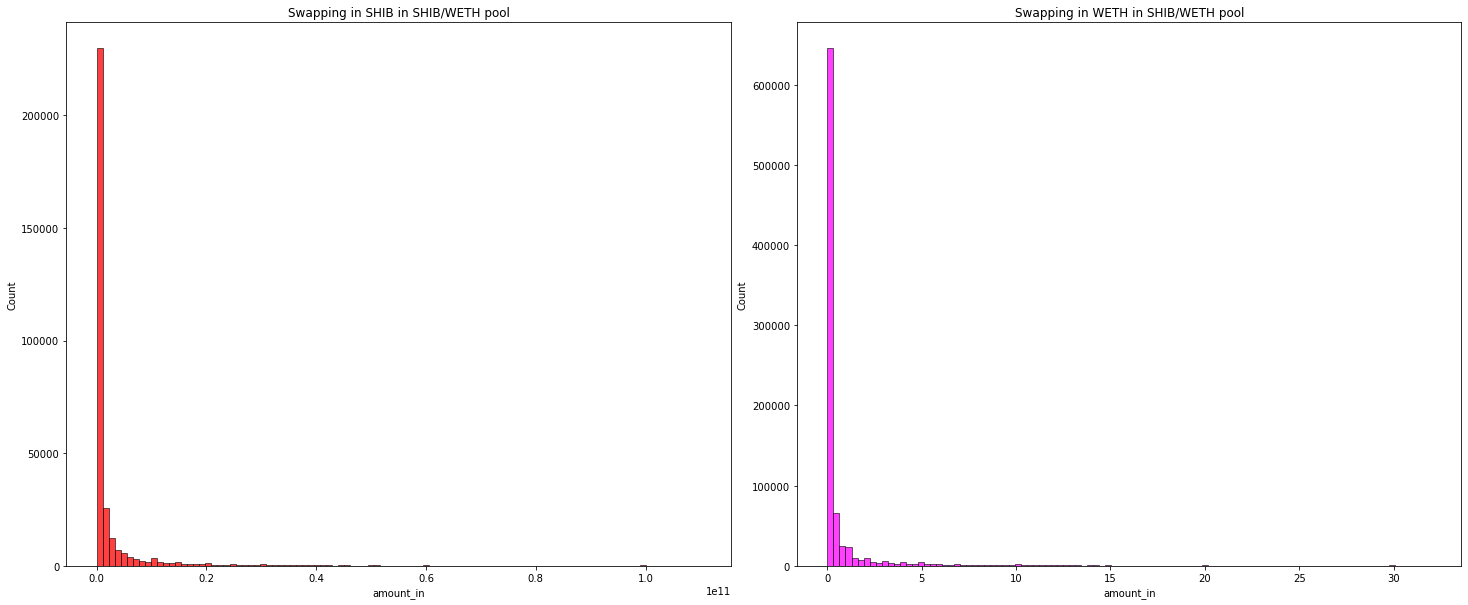

In [178]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=shib_weth_df[shib_weth_df.token_in == 'SHIB'], x='amount_in', bins=100, color='red', binrange=[0, 110000000000]).set_title("Swapping in SHIB in SHIB/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=shib_weth_df[shib_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta', binrange=[0, 32]).set_title("Swapping in WETH in SHIB/WETH pool")

plt.subplots_adjust(wspace=0.1)
plt.show()

### Plotting pool reserves

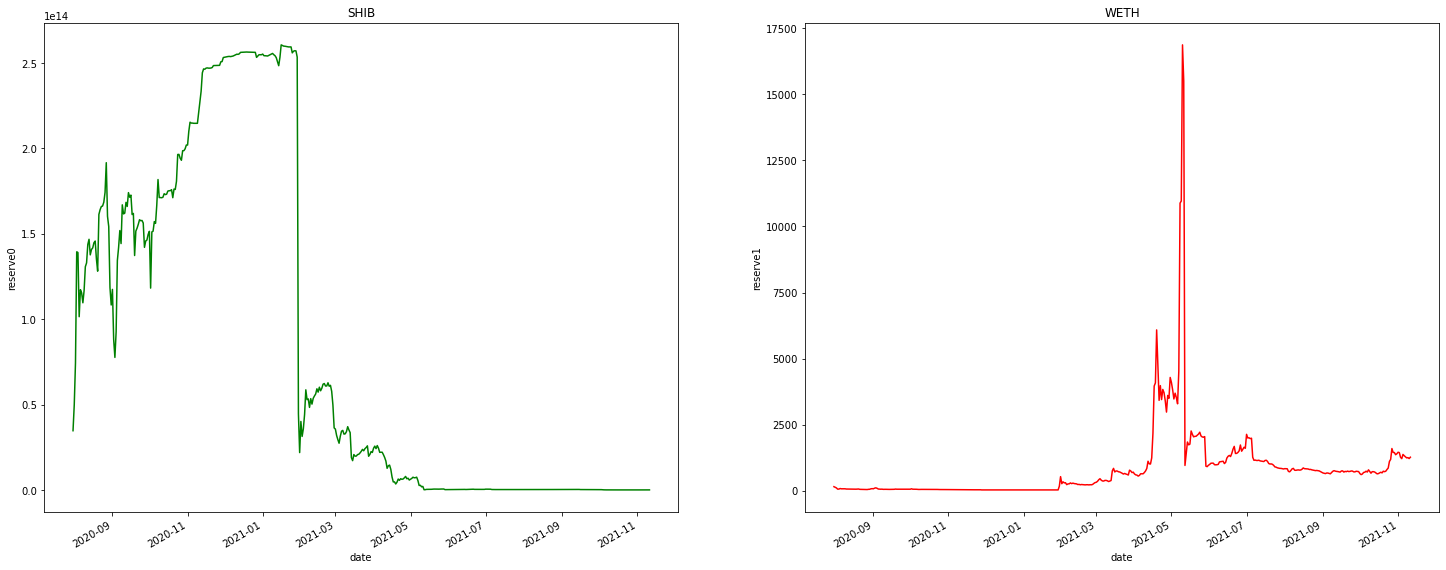

In [82]:
show_swaps_reserves_evolution_through_time(shib_weth_reserves_df, first_token_reserve_name="SHIB", second_token_reserve_name="WETH", x=25, y=10)

### Plotting pool price

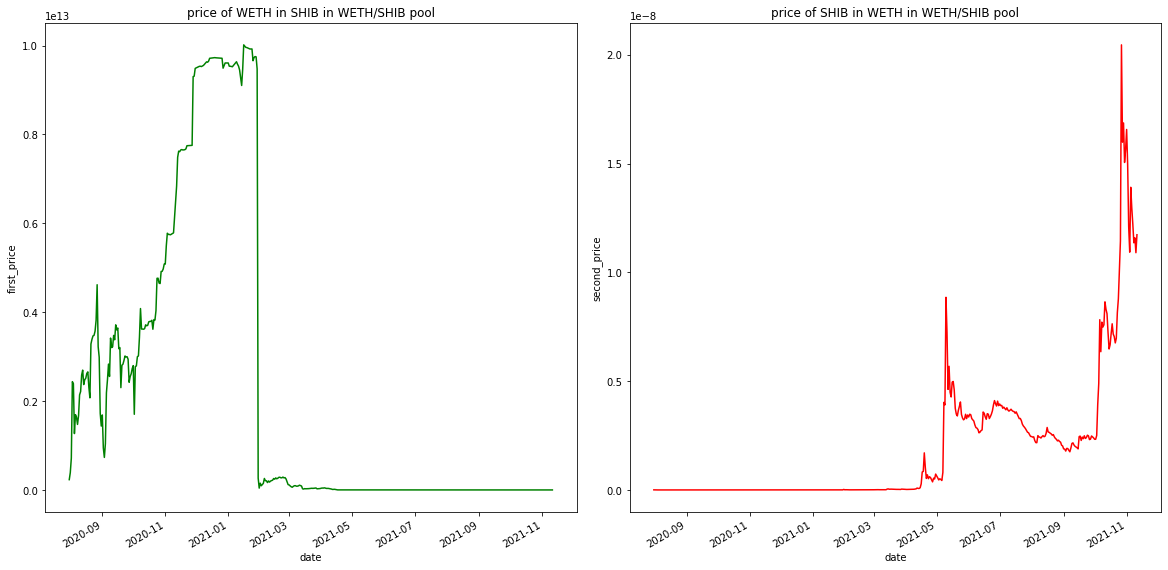

In [75]:
show_pool_price_evolution_from_reserves(shib_weth_reserves_df, first_token_price_name="price of WETH in SHIB in WETH/SHIB pool", 
                                        second_token_price_name="price of SHIB in WETH in WETH/SHIB pool", x=20, y=10, wspace=0.1)

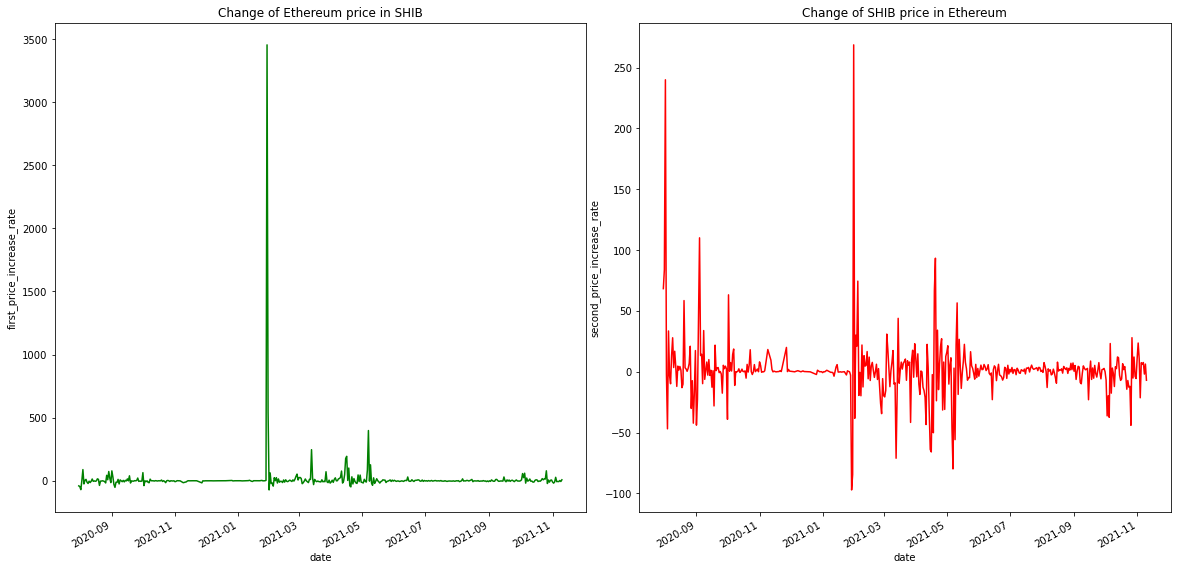

In [121]:
calc_price_and_increase_rates(shib_weth_reserves_df)

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.lineplot(data=shib_weth_reserves_df, x='date', y='first_price_increase_rate', color='green').set_title('Change of Ethereum price in SHIB')
plt.subplot(1, 2, 2)
sns.lineplot(data=shib_weth_reserves_df, x='date', y='second_price_increase_rate', color='red').set_title('Change of SHIB price in Ethereum')

fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

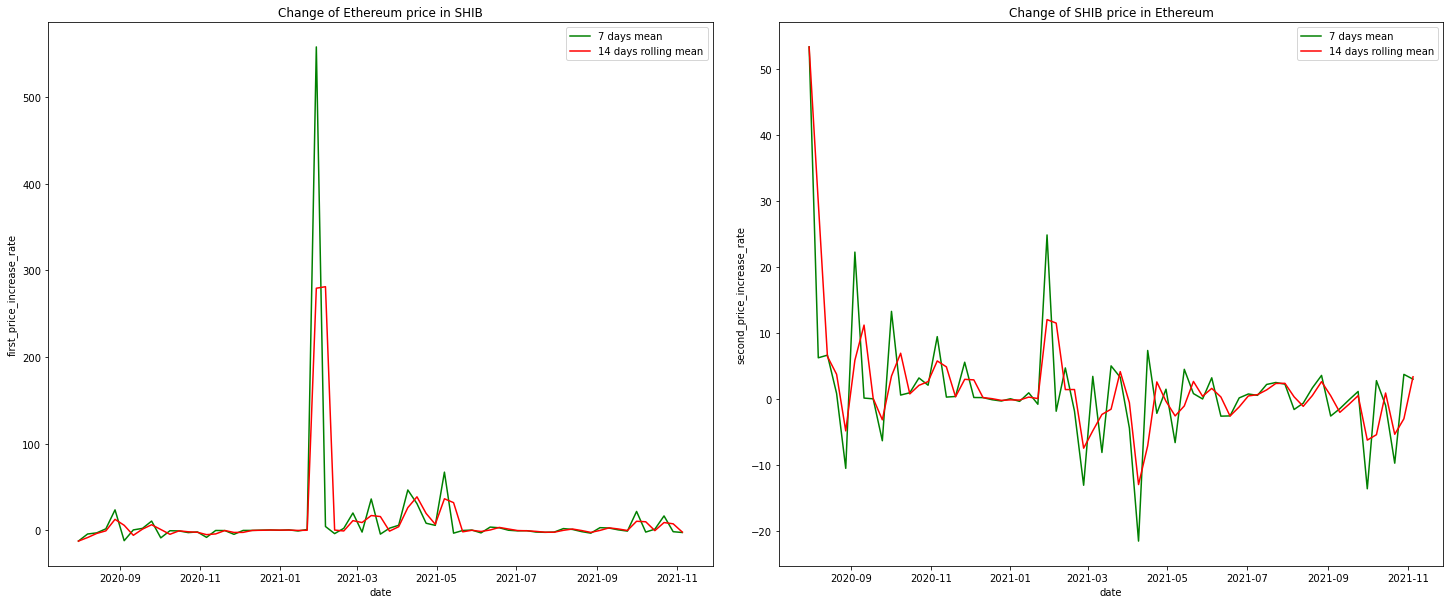

In [122]:
increase_rate_moving_averages(shib_weth_reserves_df, 'Change of Ethereum price in SHIB', 'Change of SHIB price in Ethereum', x_size=25, y_size=10)